In [1]:
import numpy as np
print("np: ", np.__version__)
import matplotlib
print("mpl: ", matplotlib.__version__)
import numpy as np
import scipy.stats as sst
import scipy as sp
print("sp: ", sp.__version__)
import matplotlib.pylab as plt
import scipy.spatial.distance as ssp
import pandas as pd

from IPython.display import Image
from IPython.display import display
from IPython.display import SVG
from ipywidgets import interact,Checkbox,Text,VBox

import helpers.theo_variogram_fct as vario

import datetime
import helpers.kriging as kri
import helpers.variogram as variokri

np:  1.16.5
mpl:  3.1.1
sp:  1.3.1


In [41]:
#import data iron concentration
data = pd.read_csv("data_iquique/data_fe.csv")
xyz = data.to_numpy()
#print(xyz[:3])

#reduce coordenate numbers
xyz[:,0]= xyz[:,0] - min(xyz[:,0])
xyz[:,1]= xyz[:,1] - min(xyz[:,1])
#print(xyz[:3])

#to define grid (to match sample points with each cell of grid)
delta_x = 1000        #meters (it depends on the data set dimensions)
delta_y = delta_x     #meters. To keep square cells

(265, 2)


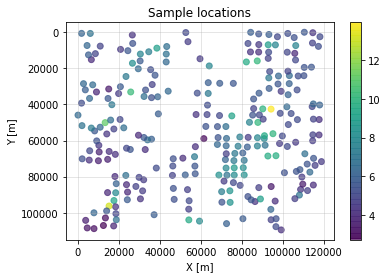

In [42]:
#Scatter plot of samples
xy = xyz[:,0:2] #the coordenate x is the second column and y the first one. 
print(xy.shape)

y = xyz[:,0] #The first coordenate is y rather than x as usual.
x = xyz[:,1]
z = xyz[:,2]


plt.scatter(x, y, c=z, alpha=0.7)
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.colorbar()
plt.title('Sample locations')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True, alpha=0.4)

265
207


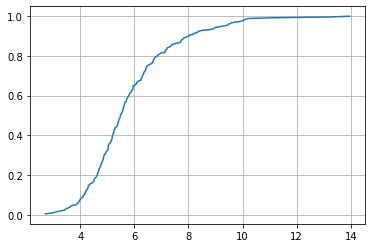

In [43]:
#Calculates the cummulative distribution function of data z
def function_cdf(z):
    s = np.sort(z)
    z_values = np.unique(s)
    pdf = []
    for i in range(len(z_values)-1):
        pdf.append(len(z[(s >= z_values[i]) & (s < z_values[i+1])])/len(s))
    cdf = np.cumsum(pdf)
    cdf = np.append(cdf,1)
    return z_values, cdf

values_cdf, cdf = function_cdf(z)

print(z.size)
print(values_cdf.size)

#Original data
plt.figure()
plt.grid()
plt.plot(values_cdf, cdf)

min = -2.9058541750122475 max = 2.861769176055261


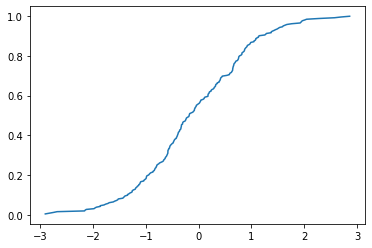

In [44]:
#Data to be transformed
np.random.seed(1000)
normal_data = np.array(np.random.normal(0,1,len(z)))
values_cdf_normal, cdf_normal = function_cdf(normal_data)

plt.figure()
plt.plot(values_cdf_normal, cdf_normal)

print("min =", min(normal_data), "max =", max(normal_data))


In [45]:
#Normalization of data z
#NOTE: DUE TO ASSIGNATION OF NEW VALUES TO z variable at the end of this cell-code, from the second execution this cell-code doesnt work properly.
#      To fix it run again the cell above to reset values of "z".
z_norm = []
for value in z:
    pos = np.where(values_cdf==value)[0][0]                        #finds cummulative probability of the value
    inter = sp.interpolate.interp1d(cdf_normal,values_cdf_normal)  #To make it continous
    z_norm.append(inter(cdf[pos]))                                 #looks for the normed value with the same cumm probability

z_norm = np.array(z_norm)

print('max z normalized value =', max(z))
print('min z normalized value =', min(z))

max z normalized value = 13.96
min z normalized value = 2.71


total number of distances = 34980
max distance = 155400.2 [m]
min distance = 1587.8 [m]
dimensions of D =  (265, 265)


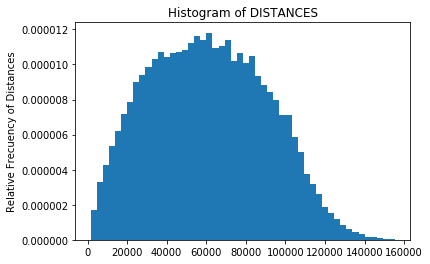

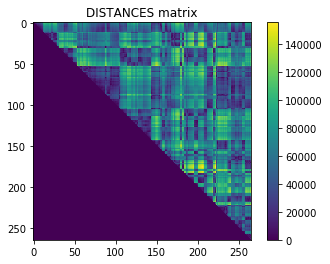

In [46]:
H = ssp.pdist(xy, metric='euclidean')
D = ssp.squareform(H)
upper = np.triu(D)
upper_vector = np.matrix.flatten(upper)
upper_vector = upper_vector[upper_vector>0]
print("total number of distances =", upper_vector.shape[0])
plt.hist(upper_vector, bins = 50, density='true') # bins = np.arange(0, np.round(max(H),0)+1 , delta_x)
plt.title("Histogram of DISTANCES")
plt.ylabel('Relative Frecuency of Distances')
print("max distance =",np.round(max(H),1),"[m]")
print("min distance =",np.round(min(H),1),"[m]")
print("dimensions of D = ",upper.shape)
plt.show()

plt.imshow(upper)
plt.title("DISTANCES matrix")
plt.colorbar()

### Correlogram

In [47]:
n = np.linspace(1000,40000,40)
bins = np.array(n)
print(bins)
print(type(bins))

[ 1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.
 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000. 20000.
 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000. 30000.
 31000. 32000. 33000. 34000. 35000. 36000. 37000. 38000. 39000. 40000.]
<class 'numpy.ndarray'>


In [48]:
ixs = []    # for measurement values at point 0
ixs_h = []  # for measurement values at point 1
rs = []     # for rs in each bin
d_mean = [] # for mean distances

ix = np.array(np.where(np.logical_and(D>bins[0], D<=bins[1])))
print(ix.shape)

(2, 8)


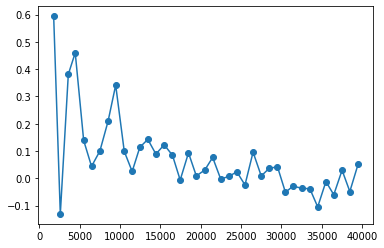

In [49]:
F = z_norm

for cur_i in range(0, len(bins)-1):
    ix = np.where(np.logical_and(D>bins[cur_i], D<=bins[cur_i+1]))
    d_mean.append(D[ix].mean())
    F_0 = F[ix[0]]
    F_1 = F[ix[1]]
    r = np.corrcoef(F_0, F_1)[1,0]
    rs.append(r)
    ixs.append(F_0)
    ixs_h.append(F_1)

#plot
plt.plot(d_mean,
         rs,
        'o-')

### Empiric Variogram

In [50]:
Z1, Z2 = np.meshgrid(F, F)
sem_var = (Z1-Z2)**2.
sem_vars = []
co_vars = []
sem_vars_v2 = []
n_pts = []

for cur_i_bin, cur_bin in enumerate(bins[:-1]):
    #print cur_i_bin, cur_bin
    ix = np.where(np.logical_and(D>bins[cur_i_bin], D<=bins[cur_i_bin+1]))
#     print len(ix)
#     print "  ", ix[0].shape, ix[0].min(), ix[0].max()
#     print "  ", ix[1].shape, ix[1].min(), ix[1].max()
    
    ## do it via the prepared large matrices
    sem_var_cur = np.sum(sem_var[ix])/(2.0 * ix[0].shape[0])
    #print sem_var_cur
    sem_vars.append(sem_var_cur)
    
    #print"      ",  ix[0].shape[0]
    sem_var_v2 = np.sum((F[ix[1]] - F[ix[0]])**2)/(2.0 * ix[0].shape[0])
    sem_vars_v2.append(sem_var_v2)
    
    mean = F[ix[1]].mean()
    covar = np.sum((F[ix[1]]-mean)* (F[ix[0]]-mean))/( ix[0].shape[0])
    co_vars.append(covar)

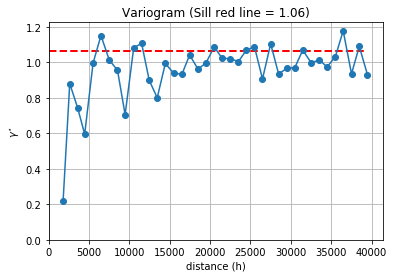

In [51]:
#Sill calculation
sill = np.var(z_norm)  #the sill is the variance of z normalized values
plt.hlines(y=sill, xmin=0, xmax=max(d_mean), colors='r', linestyles='--', lw=2) # plot sill as red dashed line.
plt.plot(d_mean, np.array(sem_vars), marker ='o')                               # plot empirical variogram
plt.grid(True)
plt.title('Variogram (Sill red line = ' + str(np.round(sill,2)) + ')')
plt.xlabel('distance (h)')
plt.ylabel('$\gamma^{\star}$')
plt.xlim(0.0,)
plt.ylim(0.0,)
plt.show()

### Initialize grid and assignation of sample values to proper cells

In [52]:
nx = 2 + int(max(x)/delta_x)       #number of required cells in x-axis
ny = 2 + int(max(y)/delta_y)       #number of required cells in y-axis
print("x max =", max(x), ", y max =", max(y))
print("This map require", nx, "cells in x-axis and", ny,"in y-xis")

x max = 118975.0 , y max = 109502.0
This map require 120 cells in x-axis and 111 in y-xis


In [53]:
#Initialize grid
X,Y = np.mgrid[0:int(delta_y+max(y)):delta_y, 0:int(delta_x+max(x)):delta_x] #is assigned y-related to row and x-related to columns

#Initialize the entire matrix with "None" values
Z = np.zeros([X.shape[0],X.shape[1]])  #it can be with X.shape or Y.shape coz both have same dimensions.
Z[:,:]=None
print('Z dimensions =',Z.shape)

##plot
# plt.imshow(Z, aspect='auto')
# plt.colorbar()
# plt.grid(True)

Z dimensions = (111, 120)


max_z_normal value = 2.861769176055261
min_z_normal value = -2.9058541750122475


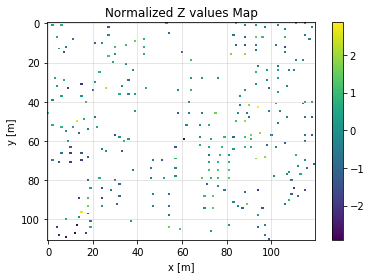

In [54]:
#Assign value of normalized samples (z) to corresponding cells in initialized matrix (Z)

i=0
observations_index = []
while i< x.shape[0]:
    x_i = int(np.round(x[i]/delta_x,0))  #return x_i = colum
    y_i = int(np.round(y[i]/delta_y,0))
    Z[y_i,x_i] = z_norm[i]
    observations_index.append([y_i,x_i])
    i = i+1

print('max_z_normal value =', max(z_norm))
print('min_z_normal value =', min(z_norm))

plt.imshow(Z)
plt.grid(True, alpha=0.4)
plt.imshow(Z, aspect='auto')
plt.colorbar()
plt.title('Normalized Z values Map')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.savefig('sample_grid_map.png', dpi=300) #save a nice .png of this map.

In [55]:
i=0
observations_index = []
while i< x.shape[0]:
    column = int(np.round(x[i]/delta_x,0))  #return x_i = colum
    raw = int(np.round(y[i]/delta_y,0))
 
    Z[raw][column] = z_norm[i]
    observations_index.append([raw,column])
    i = i+1

# Theoretical Variogram Models

In [56]:
# Define Dictionaries of Theoretical Variogram Models

# Dictionary for individual variogram models. Reference the theo_variogram_fct python file
models = {'Exponential': vario.ExponentialVariogram,
          'Spherical': vario.SphericalVariogram,
          'Gaussian': vario.GaussianVariogram,
          'Linear': vario.LinearVariogram}

# Dictionary for individual short-form variogram models to be used for composited variogram models
mods = {'Exp': vario.ExponentialVariogram,
        'Sph': vario.SphericalVariogram,
        'Gau': vario.GaussianVariogram,
        'Lin': vario.LinearVariogram}

In [57]:
# plotting for function for individual models
def plot_varmodel(Sill, Range, Model):
    v_model = Model(Sill, Range, h)
    plt.plot(h,v_model, c='red') # Model Variogram
    plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\\gamma$')
    plt.xlim(0.,max(h))
    plt.ylim(0.,)
    plt.grid(True)
    plt.show()

# plotting function for multiple variogram models 
def plot_n_varmodel(Sill, Range):
    for cur_i, var_model in enumerate(var_models):
        v_model = var_model(Sill, Range, h)
        plt.plot(h,v_model, label=models_to_plot[cur_i]) # Model Variogram
        plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
        plt.xlabel('distance')
        plt.ylabel('$\\gamma$')
        plt.xlim(0.,max(h))
        plt.ylim(0.,)
        plt.grid(True)
    plt.legend(loc='best')
    plt.show()

# plotting function for nested models   
def plot_nes_varmodel(h,mod):
    v_model = nest_vario.Variogram(h, model = mod.value)
    plt.plot(h, v_model, c='red') # Model Variogram
    plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\gamma^{\star}$')
    plt.ylim(0.,sum(var_sill)*1.5)
    plt.xlim(0.,max(h))
    plt.grid(True)
    plt.show()

In [58]:
max(d_mean)

39497.49702213335

In [59]:
# Determine first guess of sill and range from empirical variogram
var_sill = np.round(np.max(np.array(sem_vars)),decimals = 2)
h = np.linspace(0, max(d_mean),  int(max(d_mean)/10.))
var_range = np.round(np.max(np.array(d_mean)),decimals = 2)
print(np.max(np.array(sem_vars)))
print(var_sill)

1.1774450759139066
1.18


## Interactive Plot #1

With this interactive display, using slider bars, you can adjust the SILL and the RANGE for a Variogram Model selected from a dropdown list. The graph axes will update automatically.

In [60]:
# Trigger Interactive Plot
# recommended parameters : (sill = 0.9, range = 4740)
import importlib
importlib.reload(vario)
interact(plot_varmodel,
         Sill =(var_sill/100,var_sill*1.5,0.01),
         Range = (0,max(h), max(h)/100),
         Model = models)

interactive(children=(FloatSlider(value=0.8818, description='Sill', max=1.77, min=0.0118, step=0.01), FloatSli…

<function __main__.plot_varmodel(Sill, Range, Model)>

# Interpolate (Kriging)

In [61]:
# number conditioning points
n_cond = 10

# verbose output
talk_to_me = True  # True or False

In [62]:
controls = (np.dstack([x,y]))[0] #return first array of all (x,y) location of sample points.
print(controls.shape)
# print(controls)

(265, 2)


In [63]:
if len(controls.shape)<3: #to avoid in multiple runs add more dimensions
    controls = controls[:, np.newaxis, :] #para que???
print(len(controls.shape))
print(controls.shape)

3
(265, 1, 2)


In [64]:
x_min = np.min(x)
x_max = np.max(x)
y_min = np.min(y)
y_max = np.max(y)

print(f'x:  min={x_min}, max={x_max}')
print(f'y:  min={y_min}, max={y_max}')

x:  min=0.0, max=118975.0
y:  min=0.0, max=109502.0


In [65]:
i_index, j_index = np.meshgrid(range(Z.shape[0]), range(Z.shape[1]), indexing='ij')#meshgrid with index 
index = np.column_stack((np.concatenate(i_index), np.concatenate(j_index)))#rows and columns append in order to have a vector of all possible indexes (i,j) in the matrix 

index_to_simulate = [i for i in index.tolist() if i not in observations_index]#Delete from the matrix the 'observed data'

xe = Y[0,:][np.array(index_to_simulate)[:,1]]#Columns are coordinate x
ye = X[:,0][np.array(index_to_simulate)[:,0]]#Rows are coordinate y

targets = np.column_stack((xe, ye))

print("Number of cell in meshgrid =",targets.shape[0])

Number of cell in meshgrid = 13055


In [66]:
# measurement values
controlvalues = z_norm


In [67]:
var_sample = np.var(controlvalues)
print(var_sample)

1.0617075323866685


In [68]:
# Variogram Parameters
expo = variokri.ExponentialVariogram({'sill': 1.03,
                                   'range': 4344.70,
                                   'variance': var_sample})


sph = variokri.SphericalVariogram({'sill': 1.03,
                             'range': 9084.37})


fitted_variogram = variokri.CompositeVariogram()
fitted_variogram.addVariogram(expo)

In [69]:
ok_results = []
interpolation_kri = np.copy(Z)
std_kri = np.zeros((Z.shape[0],Z.shape[1]))

ok_result = kri.krige_ok(controls
                       , targets
                       , controlvalues
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
print ('ID \t x \t y \t est(z)')
for i, result in enumerate(ok_result):
    print('{0:2d}\t{1:3.2f}\t{2:3.2f}\t{3:3.2f}'.format(i, targets[i][0], targets[i][1], result[1]))
    # the weights are stored in results[0] but not saved here
    interpolation_kri[index_to_simulate[i][0], index_to_simulate[i][1]] = result[1]
    std_kri[index_to_simulate[i][0], index_to_simulate[i][1]] = result[2]
    ok_results.append([result[1], result[2]])

ID 	 x 	 y 	 est(z)
[0, 0]
 0	0.00	0.00	0.17
[0, 1]
 1	1000.00	0.00	0.27
[0, 2]
 2	2000.00	0.00	0.37
[0, 3]
 3	3000.00	0.00	0.43
[0, 4]
 4	4000.00	0.00	0.51
[0, 5]
 5	5000.00	0.00	0.60
[0, 6]
 6	6000.00	0.00	0.66
[0, 7]
 7	7000.00	0.00	0.52
[0, 8]
 8	8000.00	0.00	0.35
[0, 9]
 9	9000.00	0.00	0.19
[0, 10]
10	10000.00	0.00	0.06
[0, 11]
11	11000.00	0.00	-0.06
[0, 12]
12	12000.00	0.00	-0.06
[0, 13]
13	13000.00	0.00	-0.13
[0, 14]
14	14000.00	0.00	-0.20
[0, 15]
15	15000.00	0.00	-0.25
[0, 16]
16	16000.00	0.00	-0.30
[0, 17]
17	17000.00	0.00	-0.34
[0, 18]
18	18000.00	0.00	-0.32
[0, 19]
19	19000.00	0.00	-0.37
[0, 20]
20	20000.00	0.00	-0.38
[0, 21]
21	21000.00	0.00	-0.40
[0, 22]
22	22000.00	0.00	-0.48
[0, 23]
23	23000.00	0.00	-0.56
[0, 24]
24	24000.00	0.00	-0.67
[0, 25]
25	25000.00	0.00	-0.77
[0, 26]
26	26000.00	0.00	-0.84
[0, 27]
27	27000.00	0.00	-0.82
[0, 28]
28	28000.00	0.00	-0.65
[0, 29]
29	29000.00	0.00	-0.49
[0, 30]
30	30000.00	0.00	-0.33
[0, 31]
31	31000.00	0.00	-0.25
[0, 32]
32	32000.00	0.

[2, 33]
263	33000.00	2000.00	0.04
[2, 34]
264	34000.00	2000.00	0.14
[2, 35]
265	35000.00	2000.00	0.21
[2, 36]
266	36000.00	2000.00	0.37
[2, 37]
267	37000.00	2000.00	0.42
[2, 38]
268	38000.00	2000.00	0.36
[2, 39]
269	39000.00	2000.00	0.33
[2, 40]
270	40000.00	2000.00	0.32
[2, 41]
271	41000.00	2000.00	0.31
[2, 42]
272	42000.00	2000.00	0.27
[2, 43]
273	43000.00	2000.00	0.23
[2, 44]
274	44000.00	2000.00	0.18
[2, 45]
275	45000.00	2000.00	0.12
[2, 46]
276	46000.00	2000.00	-0.03
[2, 47]
277	47000.00	2000.00	-0.10
[2, 48]
278	48000.00	2000.00	-0.18
[2, 49]
279	49000.00	2000.00	-0.27
[2, 50]
280	50000.00	2000.00	-0.25
[2, 51]
281	51000.00	2000.00	-0.37
[2, 52]
282	52000.00	2000.00	-0.48
[2, 53]
283	53000.00	2000.00	-0.54
[2, 54]
284	54000.00	2000.00	-0.53
[2, 55]
285	55000.00	2000.00	-0.47
[2, 56]
286	56000.00	2000.00	-0.42
[2, 57]
287	57000.00	2000.00	-0.39
[2, 58]
288	58000.00	2000.00	-0.32
[2, 59]
289	59000.00	2000.00	-0.25
[2, 60]
290	60000.00	2000.00	-0.19
[2, 61]
291	61000.00	2000.00	-0.1

[4, 39]
506	39000.00	4000.00	0.57
[4, 40]
507	40000.00	4000.00	0.52
[4, 41]
508	41000.00	4000.00	0.49
[4, 42]
509	42000.00	4000.00	0.43
[4, 43]
510	43000.00	4000.00	0.37
[4, 44]
511	44000.00	4000.00	0.29
[4, 45]
512	45000.00	4000.00	0.21
[4, 46]
513	46000.00	4000.00	0.12
[4, 47]
514	47000.00	4000.00	0.02
[4, 48]
515	48000.00	4000.00	-0.09
[4, 49]
516	49000.00	4000.00	-0.12
[4, 50]
517	50000.00	4000.00	-0.26
[4, 51]
518	51000.00	4000.00	-0.40
[4, 52]
519	52000.00	4000.00	-0.55
[4, 53]
520	53000.00	4000.00	-0.68
[4, 54]
521	54000.00	4000.00	-0.72
[4, 55]
522	55000.00	4000.00	-0.65
[4, 56]
523	56000.00	4000.00	-0.54
[4, 57]
524	57000.00	4000.00	-0.43
[4, 58]
525	58000.00	4000.00	-0.33
[4, 59]
526	59000.00	4000.00	-0.33
[4, 60]
527	60000.00	4000.00	-0.27
[4, 61]
528	61000.00	4000.00	-0.18
[4, 62]
529	62000.00	4000.00	-0.29
[4, 63]
530	63000.00	4000.00	-0.10
[4, 64]
531	64000.00	4000.00	-0.06
[4, 65]
532	65000.00	4000.00	-0.03
[4, 66]
533	66000.00	4000.00	-0.18
[4, 67]
534	67000.00	4000.00	

[6, 61]
766	61000.00	6000.00	-0.25
[6, 62]
767	62000.00	6000.00	-0.11
[6, 63]
768	63000.00	6000.00	-0.16
[6, 64]
769	64000.00	6000.00	-0.08
[6, 65]
770	65000.00	6000.00	-0.08
[6, 66]
771	66000.00	6000.00	-0.16
[6, 67]
772	67000.00	6000.00	-0.20
[6, 68]
773	68000.00	6000.00	-0.18
[6, 69]
774	69000.00	6000.00	-0.16
[6, 70]
775	70000.00	6000.00	-0.15
[6, 71]
776	71000.00	6000.00	-0.13
[6, 72]
777	72000.00	6000.00	-0.12
[6, 73]
778	73000.00	6000.00	0.15
[6, 74]
779	74000.00	6000.00	0.14
[6, 75]
780	75000.00	6000.00	0.11
[6, 76]
781	76000.00	6000.00	0.42
[6, 77]
782	77000.00	6000.00	0.20
[6, 78]
783	78000.00	6000.00	0.12
[6, 79]
784	79000.00	6000.00	0.03
[6, 80]
785	80000.00	6000.00	-0.09
[6, 81]
786	81000.00	6000.00	-0.20
[6, 82]
787	82000.00	6000.00	-0.36
[6, 84]
788	84000.00	6000.00	-0.62
[6, 85]
789	85000.00	6000.00	-0.70
[6, 86]
790	86000.00	6000.00	-0.77
[6, 87]
791	87000.00	6000.00	-0.81
[6, 88]
792	88000.00	6000.00	-0.80
[6, 89]
793	89000.00	6000.00	-0.57
[6, 90]
794	90000.00	6000.0

[8, 91]
1027	91000.00	8000.00	0.06
[8, 92]
1028	92000.00	8000.00	0.55
[8, 93]
1029	93000.00	8000.00	0.91
[8, 94]
1030	94000.00	8000.00	0.96
[8, 95]
1031	95000.00	8000.00	0.91
[8, 96]
1032	96000.00	8000.00	0.85
[8, 97]
1033	97000.00	8000.00	0.68
[8, 98]
1034	98000.00	8000.00	0.48
[8, 99]
1035	99000.00	8000.00	0.28
[8, 100]
1036	100000.00	8000.00	0.12
[8, 101]
1037	101000.00	8000.00	0.03
[8, 102]
1038	102000.00	8000.00	-0.02
[8, 103]
1039	103000.00	8000.00	0.01
[8, 104]
1040	104000.00	8000.00	0.12
[8, 105]
1041	105000.00	8000.00	0.33
[8, 106]
1042	106000.00	8000.00	0.60
[8, 107]
1043	107000.00	8000.00	0.56
[8, 108]
1044	108000.00	8000.00	0.28
[8, 109]
1045	109000.00	8000.00	0.06
[8, 110]
1046	110000.00	8000.00	-0.11
[8, 111]
1047	111000.00	8000.00	-0.24
[8, 112]
1048	112000.00	8000.00	-0.33
[8, 113]
1049	113000.00	8000.00	-0.41
[8, 114]
1050	114000.00	8000.00	-0.44
[8, 115]
1051	115000.00	8000.00	-0.45
[8, 116]
1052	116000.00	8000.00	-0.42
[8, 118]
1053	118000.00	8000.00	-0.34
[8, 119]
1

[10, 111]
1283	111000.00	10000.00	-0.34
[10, 112]
1284	112000.00	10000.00	-0.36
[10, 113]
1285	113000.00	10000.00	-0.39
[10, 114]
1286	114000.00	10000.00	-0.37
[10, 115]
1287	115000.00	10000.00	-0.36
[10, 116]
1288	116000.00	10000.00	-0.35
[10, 117]
1289	117000.00	10000.00	-0.33
[10, 118]
1290	118000.00	10000.00	-0.32
[10, 119]
1291	119000.00	10000.00	-0.31
[11, 0]
1292	0.00	11000.00	0.15
[11, 1]
1293	1000.00	11000.00	0.18
[11, 2]
1294	2000.00	11000.00	0.22
[11, 3]
1295	3000.00	11000.00	0.26
[11, 4]
1296	4000.00	11000.00	0.27
[11, 5]
1297	5000.00	11000.00	0.22
[11, 6]
1298	6000.00	11000.00	0.06
[11, 7]
1299	7000.00	11000.00	-0.17
[11, 8]
1300	8000.00	11000.00	-0.37
[11, 9]
1301	9000.00	11000.00	-0.50
[11, 10]
1302	10000.00	11000.00	-0.58
[11, 11]
1303	11000.00	11000.00	-0.62
[11, 12]
1304	12000.00	11000.00	-0.64
[11, 13]
1305	13000.00	11000.00	-0.56
[11, 14]
1306	14000.00	11000.00	-0.54
[11, 15]
1307	15000.00	11000.00	-0.54
[11, 16]
1308	16000.00	11000.00	-0.65
[11, 17]
1309	17000.00	1

[12, 101]
1505	101000.00	12000.00	-0.48
[12, 102]
1506	102000.00	12000.00	-0.62
[12, 103]
1507	103000.00	12000.00	-0.78
[12, 104]
1508	104000.00	12000.00	-0.98
[12, 105]
1509	105000.00	12000.00	-1.26
[12, 107]
1510	107000.00	12000.00	-1.16
[12, 108]
1511	108000.00	12000.00	-0.86
[12, 109]
1512	109000.00	12000.00	-0.67
[12, 110]
1513	110000.00	12000.00	-0.53
[12, 111]
1514	111000.00	12000.00	-0.46
[12, 112]
1515	112000.00	12000.00	-0.41
[12, 113]
1516	113000.00	12000.00	-0.38
[12, 114]
1517	114000.00	12000.00	-0.37
[12, 115]
1518	115000.00	12000.00	-0.33
[12, 116]
1519	116000.00	12000.00	-0.32
[12, 117]
1520	117000.00	12000.00	-0.31
[12, 118]
1521	118000.00	12000.00	-0.30
[12, 119]
1522	119000.00	12000.00	-0.30
[13, 0]
1523	0.00	13000.00	0.12
[13, 1]
1524	1000.00	13000.00	0.11
[13, 2]
1525	2000.00	13000.00	0.09
[13, 3]
1526	3000.00	13000.00	0.03
[13, 4]
1527	4000.00	13000.00	0.03
[13, 6]
1528	6000.00	13000.00	-0.29
[13, 7]
1529	7000.00	13000.00	-0.57
[13, 8]
1530	8000.00	13000.00	-0.71


[14, 85]
1727	85000.00	14000.00	0.57
[14, 86]
1728	86000.00	14000.00	0.61
[14, 87]
1729	87000.00	14000.00	0.62
[14, 88]
1730	88000.00	14000.00	0.52
[14, 89]
1731	89000.00	14000.00	0.29
[14, 90]
1732	90000.00	14000.00	0.02
[14, 91]
1733	91000.00	14000.00	-0.25
[14, 92]
1734	92000.00	14000.00	-0.51
[14, 94]
1735	94000.00	14000.00	-0.62
[14, 95]
1736	95000.00	14000.00	-0.47
[14, 96]
1737	96000.00	14000.00	-0.47
[14, 97]
1738	97000.00	14000.00	-0.43
[14, 98]
1739	98000.00	14000.00	-0.43
[14, 99]
1740	99000.00	14000.00	-0.44
[14, 100]
1741	100000.00	14000.00	-0.49
[14, 101]
1742	101000.00	14000.00	-0.56
[14, 102]
1743	102000.00	14000.00	-0.64
[14, 103]
1744	103000.00	14000.00	-0.74
[14, 104]
1745	104000.00	14000.00	-0.84
[14, 105]
1746	105000.00	14000.00	-0.89
[14, 106]
1747	106000.00	14000.00	-0.90
[14, 107]
1748	107000.00	14000.00	-0.81
[14, 108]
1749	108000.00	14000.00	-0.73
[14, 109]
1750	109000.00	14000.00	-0.63
[14, 110]
1751	110000.00	14000.00	-0.52
[14, 111]
1752	111000.00	14000.00	

[16, 73]
1949	73000.00	16000.00	0.37
[16, 74]
1950	74000.00	16000.00	0.39
[16, 75]
1951	75000.00	16000.00	0.41
[16, 76]
1952	76000.00	16000.00	0.47
[16, 77]
1953	77000.00	16000.00	0.60
[16, 78]
1954	78000.00	16000.00	0.70
[16, 79]
1955	79000.00	16000.00	0.84
[16, 80]
1956	80000.00	16000.00	0.91
[16, 81]
1957	81000.00	16000.00	1.19
[16, 83]
1958	83000.00	16000.00	1.50
[16, 84]
1959	84000.00	16000.00	1.40
[16, 85]
1960	85000.00	16000.00	1.41
[16, 86]
1961	86000.00	16000.00	1.55
[16, 87]
1962	87000.00	16000.00	1.82
[16, 89]
1963	89000.00	16000.00	1.13
[16, 90]
1964	90000.00	16000.00	0.62
[16, 91]
1965	91000.00	16000.00	0.20
[16, 92]
1966	92000.00	16000.00	-0.14
[16, 93]
1967	93000.00	16000.00	-0.33
[16, 94]
1968	94000.00	16000.00	-0.41
[16, 95]
1969	95000.00	16000.00	-0.44
[16, 96]
1970	96000.00	16000.00	-0.41
[16, 97]
1971	97000.00	16000.00	-0.43
[16, 98]
1972	98000.00	16000.00	-0.45
[16, 99]
1973	99000.00	16000.00	-0.46
[16, 100]
1974	100000.00	16000.00	-0.48
[16, 101]
1975	101000.00	16

[18, 93]
2206	93000.00	18000.00	-0.11
[18, 94]
2207	94000.00	18000.00	-0.31
[18, 95]
2208	95000.00	18000.00	-0.36
[18, 96]
2209	96000.00	18000.00	-0.38
[18, 97]
2210	97000.00	18000.00	-0.39
[18, 98]
2211	98000.00	18000.00	-0.46
[18, 99]
2212	99000.00	18000.00	-0.47
[18, 100]
2213	100000.00	18000.00	-0.51
[18, 101]
2214	101000.00	18000.00	-0.55
[18, 102]
2215	102000.00	18000.00	-0.57
[18, 103]
2216	103000.00	18000.00	-0.56
[18, 104]
2217	104000.00	18000.00	-0.52
[18, 105]
2218	105000.00	18000.00	-0.50
[18, 106]
2219	106000.00	18000.00	-0.46
[18, 107]
2220	107000.00	18000.00	-0.41
[18, 108]
2221	108000.00	18000.00	-0.37
[18, 109]
2222	109000.00	18000.00	-0.32
[18, 110]
2223	110000.00	18000.00	-0.28
[18, 111]
2224	111000.00	18000.00	-0.23
[18, 112]
2225	112000.00	18000.00	-0.22
[18, 113]
2226	113000.00	18000.00	-0.19
[18, 114]
2227	114000.00	18000.00	-0.17
[18, 115]
2228	115000.00	18000.00	-0.18
[18, 116]
2229	116000.00	18000.00	-0.22
[18, 117]
2230	117000.00	18000.00	-0.26
[18, 118]
2231

[20, 79]
2428	79000.00	20000.00	0.72
[20, 80]
2429	80000.00	20000.00	0.81
[20, 81]
2430	81000.00	20000.00	0.92
[20, 82]
2431	82000.00	20000.00	1.02
[20, 83]
2432	83000.00	20000.00	1.08
[20, 84]
2433	84000.00	20000.00	1.10
[20, 85]
2434	85000.00	20000.00	1.10
[20, 86]
2435	86000.00	20000.00	1.09
[20, 87]
2436	87000.00	20000.00	1.04
[20, 88]
2437	88000.00	20000.00	0.91
[20, 89]
2438	89000.00	20000.00	0.74
[20, 90]
2439	90000.00	20000.00	0.51
[20, 91]
2440	91000.00	20000.00	0.27
[20, 92]
2441	92000.00	20000.00	0.02
[20, 93]
2442	93000.00	20000.00	-0.20
[20, 94]
2443	94000.00	20000.00	-0.30
[20, 95]
2444	95000.00	20000.00	-0.29
[20, 96]
2445	96000.00	20000.00	-0.28
[20, 97]
2446	97000.00	20000.00	-0.25
[20, 98]
2447	98000.00	20000.00	-0.30
[20, 99]
2448	99000.00	20000.00	-0.32
[20, 100]
2449	100000.00	20000.00	-0.37
[20, 101]
2450	101000.00	20000.00	-0.45
[20, 102]
2451	102000.00	20000.00	-0.56
[20, 103]
2452	103000.00	20000.00	-0.57
[20, 104]
2453	104000.00	20000.00	-0.51
[20, 105]
2454	1

[22, 61]
2649	61000.00	22000.00	0.27
[22, 62]
2650	62000.00	22000.00	0.36
[22, 63]
2651	63000.00	22000.00	0.49
[22, 64]
2652	64000.00	22000.00	0.54
[22, 65]
2653	65000.00	22000.00	0.56
[22, 66]
2654	66000.00	22000.00	0.54
[22, 67]
2655	67000.00	22000.00	0.48
[22, 68]
2656	68000.00	22000.00	0.43
[22, 69]
2657	69000.00	22000.00	0.38
[22, 70]
2658	70000.00	22000.00	0.44
[22, 71]
2659	71000.00	22000.00	0.42
[22, 72]
2660	72000.00	22000.00	0.40
[22, 73]
2661	73000.00	22000.00	0.42
[22, 74]
2662	74000.00	22000.00	0.39
[22, 75]
2663	75000.00	22000.00	0.41
[22, 76]
2664	76000.00	22000.00	0.52
[22, 77]
2665	77000.00	22000.00	0.57
[22, 78]
2666	78000.00	22000.00	0.59
[22, 79]
2667	79000.00	22000.00	0.64
[22, 80]
2668	80000.00	22000.00	0.59
[22, 81]
2669	81000.00	22000.00	0.66
[22, 82]
2670	82000.00	22000.00	0.72
[22, 83]
2671	83000.00	22000.00	0.75
[22, 84]
2672	84000.00	22000.00	0.77
[22, 85]
2673	85000.00	22000.00	0.77
[22, 86]
2674	86000.00	22000.00	0.75
[22, 87]
2675	87000.00	22000.00	0.74
[

[24, 74]
2899	74000.00	24000.00	0.32
[24, 75]
2900	75000.00	24000.00	0.39
[24, 76]
2901	76000.00	24000.00	0.42
[24, 77]
2902	77000.00	24000.00	0.45
[24, 78]
2903	78000.00	24000.00	0.50
[24, 79]
2904	79000.00	24000.00	0.50
[24, 80]
2905	80000.00	24000.00	0.48
[24, 81]
2906	81000.00	24000.00	0.52
[24, 82]
2907	82000.00	24000.00	0.56
[24, 83]
2908	83000.00	24000.00	0.53
[24, 84]
2909	84000.00	24000.00	0.55
[24, 85]
2910	85000.00	24000.00	0.64
[24, 86]
2911	86000.00	24000.00	0.64
[24, 87]
2912	87000.00	24000.00	0.62
[24, 88]
2913	88000.00	24000.00	0.58
[24, 89]
2914	89000.00	24000.00	0.53
[24, 90]
2915	90000.00	24000.00	0.51
[24, 91]
2916	91000.00	24000.00	0.47
[24, 92]
2917	92000.00	24000.00	0.43
[24, 93]
2918	93000.00	24000.00	0.41
[24, 94]
2919	94000.00	24000.00	0.36
[24, 95]
2920	95000.00	24000.00	0.33
[24, 96]
2921	96000.00	24000.00	0.34
[24, 97]
2922	97000.00	24000.00	0.40
[24, 99]
2923	99000.00	24000.00	0.37
[24, 100]
2924	100000.00	24000.00	0.29
[24, 101]
2925	101000.00	24000.00	0.

[26, 91]
3150	91000.00	26000.00	0.54
[26, 92]
3151	92000.00	26000.00	0.66
[26, 93]
3152	93000.00	26000.00	0.71
[26, 94]
3153	94000.00	26000.00	0.66
[26, 95]
3154	95000.00	26000.00	0.54
[26, 96]
3155	96000.00	26000.00	0.46
[26, 97]
3156	97000.00	26000.00	0.42
[26, 98]
3157	98000.00	26000.00	0.40
[26, 99]
3158	99000.00	26000.00	0.37
[26, 100]
3159	100000.00	26000.00	0.36
[26, 101]
3160	101000.00	26000.00	0.39
[26, 102]
3161	102000.00	26000.00	0.44
[26, 103]
3162	103000.00	26000.00	0.45
[26, 104]
3163	104000.00	26000.00	0.37
[26, 105]
3164	105000.00	26000.00	0.21
[26, 106]
3165	106000.00	26000.00	0.03
[26, 107]
3166	107000.00	26000.00	-0.12
[26, 108]
3167	108000.00	26000.00	-0.21
[26, 109]
3168	109000.00	26000.00	-0.26
[26, 110]
3169	110000.00	26000.00	-0.26
[26, 111]
3170	111000.00	26000.00	-0.25
[26, 112]
3171	112000.00	26000.00	-0.24
[26, 113]
3172	113000.00	26000.00	-0.21
[26, 114]
3173	114000.00	26000.00	-0.15
[26, 115]
3174	115000.00	26000.00	-0.13
[26, 116]
3175	116000.00	26000.00	

[28, 73]
3369	73000.00	28000.00	0.14
[28, 74]
3370	74000.00	28000.00	0.10
[28, 75]
3371	75000.00	28000.00	0.06
[28, 77]
3372	77000.00	28000.00	0.13
[28, 78]
3373	78000.00	28000.00	0.23
[28, 79]
3374	79000.00	28000.00	0.26
[28, 80]
3375	80000.00	28000.00	0.27
[28, 81]
3376	81000.00	28000.00	0.31
[28, 82]
3377	82000.00	28000.00	0.34
[28, 83]
3378	83000.00	28000.00	0.37
[28, 84]
3379	84000.00	28000.00	0.38
[28, 85]
3380	85000.00	28000.00	0.45
[28, 86]
3381	86000.00	28000.00	0.46
[28, 87]
3382	87000.00	28000.00	0.46
[28, 88]
3383	88000.00	28000.00	0.37
[28, 89]
3384	89000.00	28000.00	0.40
[28, 90]
3385	90000.00	28000.00	0.47
[28, 91]
3386	91000.00	28000.00	0.49
[28, 92]
3387	92000.00	28000.00	0.43
[28, 93]
3388	93000.00	28000.00	0.45
[28, 94]
3389	94000.00	28000.00	0.42
[28, 95]
3390	95000.00	28000.00	0.35
[28, 96]
3391	96000.00	28000.00	0.26
[28, 97]
3392	97000.00	28000.00	0.18
[28, 98]
3393	98000.00	28000.00	0.13
[28, 99]
3394	99000.00	28000.00	0.12
[28, 100]
3395	100000.00	28000.00	0.15

[30, 60]
3590	60000.00	30000.00	0.05
[30, 61]
3591	61000.00	30000.00	0.14
[30, 62]
3592	62000.00	30000.00	0.23
[30, 63]
3593	63000.00	30000.00	0.30
[30, 64]
3594	64000.00	30000.00	0.33
[30, 65]
3595	65000.00	30000.00	0.34
[30, 66]
3596	66000.00	30000.00	0.31
[30, 67]
3597	67000.00	30000.00	0.28
[30, 68]
3598	68000.00	30000.00	0.23
[30, 69]
3599	69000.00	30000.00	0.25
[30, 70]
3600	70000.00	30000.00	0.22
[30, 71]
3601	71000.00	30000.00	0.18
[30, 72]
3602	72000.00	30000.00	0.16
[30, 73]
3603	73000.00	30000.00	0.15
[30, 74]
3604	74000.00	30000.00	0.11
[30, 75]
3605	75000.00	30000.00	0.13
[30, 76]
3606	76000.00	30000.00	0.09
[30, 77]
3607	77000.00	30000.00	0.14
[30, 78]
3608	78000.00	30000.00	0.14
[30, 79]
3609	79000.00	30000.00	0.19
[30, 80]
3610	80000.00	30000.00	0.21
[30, 81]
3611	81000.00	30000.00	0.23
[30, 82]
3612	82000.00	30000.00	0.25
[30, 83]
3613	83000.00	30000.00	0.26
[30, 84]
3614	84000.00	30000.00	0.27
[30, 85]
3615	85000.00	30000.00	0.28
[30, 86]
3616	86000.00	30000.00	0.16
[

[32, 45]
3811	45000.00	32000.00	0.50
[32, 46]
3812	46000.00	32000.00	0.41
[32, 47]
3813	47000.00	32000.00	0.39
[32, 48]
3814	48000.00	32000.00	0.35
[32, 49]
3815	49000.00	32000.00	0.11
[32, 50]
3816	50000.00	32000.00	0.03
[32, 51]
3817	51000.00	32000.00	-0.02
[32, 52]
3818	52000.00	32000.00	-0.07
[32, 53]
3819	53000.00	32000.00	-0.11
[32, 54]
3820	54000.00	32000.00	-0.00
[32, 55]
3821	55000.00	32000.00	-0.05
[32, 56]
3822	56000.00	32000.00	-0.09
[32, 57]
3823	57000.00	32000.00	-0.18
[32, 58]
3824	58000.00	32000.00	-0.16
[32, 59]
3825	59000.00	32000.00	-0.05
[32, 60]
3826	60000.00	32000.00	0.08
[32, 61]
3827	61000.00	32000.00	0.21
[32, 62]
3828	62000.00	32000.00	0.37
[32, 63]
3829	63000.00	32000.00	0.49
[32, 64]
3830	64000.00	32000.00	0.54
[32, 65]
3831	65000.00	32000.00	0.50
[32, 66]
3832	66000.00	32000.00	0.43
[32, 67]
3833	67000.00	32000.00	0.35
[32, 68]
3834	68000.00	32000.00	0.36
[32, 69]
3835	69000.00	32000.00	0.31
[32, 70]
3836	70000.00	32000.00	0.27
[32, 71]
3837	71000.00	32000.

[34, 31]
4031	31000.00	34000.00	0.67
[34, 32]
4032	32000.00	34000.00	0.46
[34, 33]
4033	33000.00	34000.00	0.24
[34, 34]
4034	34000.00	34000.00	0.04
[34, 35]
4035	35000.00	34000.00	-0.09
[34, 36]
4036	36000.00	34000.00	-0.12
[34, 37]
4037	37000.00	34000.00	-0.06
[34, 38]
4038	38000.00	34000.00	0.07
[34, 39]
4039	39000.00	34000.00	0.21
[34, 40]
4040	40000.00	34000.00	0.31
[34, 41]
4041	41000.00	34000.00	0.39
[34, 42]
4042	42000.00	34000.00	0.47
[34, 43]
4043	43000.00	34000.00	0.48
[34, 44]
4044	44000.00	34000.00	0.52
[34, 45]
4045	45000.00	34000.00	0.48
[34, 46]
4046	46000.00	34000.00	0.35
[34, 47]
4047	47000.00	34000.00	0.25
[34, 48]
4048	48000.00	34000.00	0.19
[34, 49]
4049	49000.00	34000.00	0.10
[34, 50]
4050	50000.00	34000.00	0.03
[34, 51]
4051	51000.00	34000.00	-0.03
[34, 52]
4052	52000.00	34000.00	-0.12
[34, 53]
4053	53000.00	34000.00	-0.12
[34, 54]
4054	54000.00	34000.00	-0.16
[34, 55]
4055	55000.00	34000.00	-0.12
[34, 56]
4056	56000.00	34000.00	-0.18
[34, 57]
4057	57000.00	34000.

[36, 48]
4281	48000.00	36000.00	0.16
[36, 49]
4282	49000.00	36000.00	0.04
[36, 50]
4283	50000.00	36000.00	-0.02
[36, 51]
4284	51000.00	36000.00	-0.03
[36, 52]
4285	52000.00	36000.00	-0.08
[36, 53]
4286	53000.00	36000.00	-0.13
[36, 54]
4287	54000.00	36000.00	-0.15
[36, 55]
4288	55000.00	36000.00	-0.23
[36, 56]
4289	56000.00	36000.00	-0.26
[36, 57]
4290	57000.00	36000.00	-0.28
[36, 58]
4291	58000.00	36000.00	-0.26
[36, 59]
4292	59000.00	36000.00	-0.19
[36, 60]
4293	60000.00	36000.00	-0.08
[36, 61]
4294	61000.00	36000.00	0.04
[36, 62]
4295	62000.00	36000.00	0.18
[36, 63]
4296	63000.00	36000.00	0.32
[36, 64]
4297	64000.00	36000.00	0.38
[36, 65]
4298	65000.00	36000.00	0.37
[36, 66]
4299	66000.00	36000.00	0.33
[36, 67]
4300	67000.00	36000.00	0.28
[36, 68]
4301	68000.00	36000.00	0.24
[36, 69]
4302	69000.00	36000.00	0.21
[36, 70]
4303	70000.00	36000.00	0.19
[36, 71]
4304	71000.00	36000.00	0.20
[36, 72]
4305	72000.00	36000.00	0.20
[36, 73]
4306	73000.00	36000.00	0.16
[36, 74]
4307	74000.00	3600

[38, 64]
4534	64000.00	38000.00	0.03
[38, 65]
4535	65000.00	38000.00	0.07
[38, 66]
4536	66000.00	38000.00	0.09
[38, 67]
4537	67000.00	38000.00	0.10
[38, 68]
4538	68000.00	38000.00	0.11
[38, 69]
4539	69000.00	38000.00	0.13
[38, 70]
4540	70000.00	38000.00	0.17
[38, 71]
4541	71000.00	38000.00	0.22
[38, 72]
4542	72000.00	38000.00	0.24
[38, 73]
4543	73000.00	38000.00	0.19
[38, 74]
4544	74000.00	38000.00	0.21
[38, 75]
4545	75000.00	38000.00	0.24
[38, 76]
4546	76000.00	38000.00	0.23
[38, 77]
4547	77000.00	38000.00	0.20
[38, 78]
4548	78000.00	38000.00	0.20
[38, 79]
4549	79000.00	38000.00	0.21
[38, 80]
4550	80000.00	38000.00	0.16
[38, 81]
4551	81000.00	38000.00	0.26
[38, 82]
4552	82000.00	38000.00	0.19
[38, 83]
4553	83000.00	38000.00	0.10
[38, 84]
4554	84000.00	38000.00	-0.04
[38, 85]
4555	85000.00	38000.00	-0.06
[38, 86]
4556	86000.00	38000.00	-0.00
[38, 87]
4557	87000.00	38000.00	0.16
[38, 88]
4558	88000.00	38000.00	0.38
[38, 89]
4559	89000.00	38000.00	0.54
[38, 90]
4560	90000.00	38000.00	0.7

[40, 71]
4778	71000.00	40000.00	0.21
[40, 72]
4779	72000.00	40000.00	0.20
[40, 73]
4780	73000.00	40000.00	0.27
[40, 74]
4781	74000.00	40000.00	0.31
[40, 75]
4782	75000.00	40000.00	0.35
[40, 76]
4783	76000.00	40000.00	0.33
[40, 77]
4784	77000.00	40000.00	0.35
[40, 78]
4785	78000.00	40000.00	0.35
[40, 79]
4786	79000.00	40000.00	0.29
[40, 80]
4787	80000.00	40000.00	0.21
[40, 81]
4788	81000.00	40000.00	0.29
[40, 82]
4789	82000.00	40000.00	0.16
[40, 83]
4790	83000.00	40000.00	0.04
[40, 84]
4791	84000.00	40000.00	-0.09
[40, 85]
4792	85000.00	40000.00	-0.12
[40, 86]
4793	86000.00	40000.00	-0.04
[40, 87]
4794	87000.00	40000.00	0.19
[40, 88]
4795	88000.00	40000.00	0.50
[40, 89]
4796	89000.00	40000.00	0.88
[40, 90]
4797	90000.00	40000.00	1.19
[40, 91]
4798	91000.00	40000.00	1.45
[40, 92]
4799	92000.00	40000.00	1.63
[40, 93]
4800	93000.00	40000.00	1.76
[40, 94]
4801	94000.00	40000.00	1.79
[40, 95]
4802	95000.00	40000.00	1.60
[40, 96]
4803	96000.00	40000.00	1.36
[40, 97]
4804	97000.00	40000.00	1.1

[42, 55]
4998	55000.00	42000.00	-0.48
[42, 56]
4999	56000.00	42000.00	-0.57
[42, 57]
5000	57000.00	42000.00	-0.61
[42, 58]
5001	58000.00	42000.00	-0.62
[42, 59]
5002	59000.00	42000.00	-0.60
[42, 60]
5003	60000.00	42000.00	-0.57
[42, 61]
5004	61000.00	42000.00	-0.54
[42, 62]
5005	62000.00	42000.00	-0.50
[42, 63]
5006	63000.00	42000.00	-0.47
[42, 64]
5007	64000.00	42000.00	-0.41
[42, 65]
5008	65000.00	42000.00	-0.35
[42, 66]
5009	66000.00	42000.00	-0.28
[42, 67]
5010	67000.00	42000.00	-0.22
[42, 68]
5011	68000.00	42000.00	-0.15
[42, 69]
5012	69000.00	42000.00	-0.07
[42, 70]
5013	70000.00	42000.00	0.05
[42, 71]
5014	71000.00	42000.00	0.17
[42, 72]
5015	72000.00	42000.00	0.27
[42, 73]
5016	73000.00	42000.00	0.42
[42, 74]
5017	74000.00	42000.00	0.44
[42, 75]
5018	75000.00	42000.00	0.50
[42, 76]
5019	76000.00	42000.00	0.53
[42, 77]
5020	77000.00	42000.00	0.71
[42, 78]
5021	78000.00	42000.00	0.64
[42, 79]
5022	79000.00	42000.00	0.54
[42, 80]
5023	80000.00	42000.00	0.40
[42, 81]
5024	81000.00	

[44, 70]
5250	70000.00	44000.00	-0.08
[44, 71]
5251	71000.00	44000.00	0.16
[44, 72]
5252	72000.00	44000.00	0.39
[44, 73]
5253	73000.00	44000.00	0.54
[44, 74]
5254	74000.00	44000.00	0.74
[44, 75]
5255	75000.00	44000.00	0.86
[44, 76]
5256	76000.00	44000.00	0.88
[44, 77]
5257	77000.00	44000.00	0.87
[44, 78]
5258	78000.00	44000.00	0.83
[44, 79]
5259	79000.00	44000.00	0.69
[44, 80]
5260	80000.00	44000.00	0.50
[44, 81]
5261	81000.00	44000.00	0.42
[44, 82]
5262	82000.00	44000.00	0.25
[44, 83]
5263	83000.00	44000.00	0.12
[44, 84]
5264	84000.00	44000.00	-0.09
[44, 85]
5265	85000.00	44000.00	-0.26
[44, 86]
5266	86000.00	44000.00	-0.32
[44, 87]
5267	87000.00	44000.00	-0.19
[44, 88]
5268	88000.00	44000.00	0.06
[44, 89]
5269	89000.00	44000.00	0.43
[44, 90]
5270	90000.00	44000.00	0.87
[44, 91]
5271	91000.00	44000.00	1.23
[44, 92]
5272	92000.00	44000.00	1.49
[44, 93]
5273	93000.00	44000.00	1.72
[44, 94]
5274	94000.00	44000.00	1.84
[44, 95]
5275	95000.00	44000.00	1.67
[44, 96]
5276	96000.00	44000.00	1

[46, 90]
5500	90000.00	46000.00	-0.12
[46, 91]
5501	91000.00	46000.00	0.15
[46, 92]
5502	92000.00	46000.00	0.48
[46, 93]
5503	93000.00	46000.00	0.67
[46, 94]
5504	94000.00	46000.00	0.74
[46, 95]
5505	95000.00	46000.00	0.69
[46, 96]
5506	96000.00	46000.00	0.59
[46, 97]
5507	97000.00	46000.00	0.30
[46, 98]
5508	98000.00	46000.00	-0.07
[46, 99]
5509	99000.00	46000.00	-0.32
[46, 100]
5510	100000.00	46000.00	-0.36
[46, 101]
5511	101000.00	46000.00	-0.37
[46, 102]
5512	102000.00	46000.00	-0.33
[46, 103]
5513	103000.00	46000.00	-0.36
[46, 104]
5514	104000.00	46000.00	-0.38
[46, 105]
5515	105000.00	46000.00	-0.36
[46, 106]
5516	106000.00	46000.00	-0.36
[46, 107]
5517	107000.00	46000.00	-0.35
[46, 108]
5518	108000.00	46000.00	-0.37
[46, 109]
5519	109000.00	46000.00	-0.38
[46, 110]
5520	110000.00	46000.00	-0.41
[46, 111]
5521	111000.00	46000.00	-0.45
[46, 112]
5522	112000.00	46000.00	-0.48
[46, 113]
5523	113000.00	46000.00	-0.56
[46, 114]
5524	114000.00	46000.00	-0.58
[46, 115]
5525	115000.00	46

[48, 70]
5719	70000.00	48000.00	-0.05
[48, 71]
5720	71000.00	48000.00	0.21
[48, 72]
5721	72000.00	48000.00	0.49
[48, 73]
5722	73000.00	48000.00	0.78
[48, 74]
5723	74000.00	48000.00	1.02
[48, 75]
5724	75000.00	48000.00	1.19
[48, 76]
5725	76000.00	48000.00	1.21
[48, 77]
5726	77000.00	48000.00	1.14
[48, 78]
5727	78000.00	48000.00	1.03
[48, 79]
5728	79000.00	48000.00	0.87
[48, 80]
5729	80000.00	48000.00	0.78
[48, 81]
5730	81000.00	48000.00	0.72
[48, 82]
5731	82000.00	48000.00	0.70
[48, 83]
5732	83000.00	48000.00	0.66
[48, 84]
5733	84000.00	48000.00	0.63
[48, 85]
5734	85000.00	48000.00	0.63
[48, 86]
5735	86000.00	48000.00	0.64
[48, 87]
5736	87000.00	48000.00	0.60
[48, 88]
5737	88000.00	48000.00	0.42
[48, 89]
5738	89000.00	48000.00	0.03
[48, 91]
5739	91000.00	48000.00	-0.51
[48, 92]
5740	92000.00	48000.00	-0.06
[48, 93]
5741	93000.00	48000.00	0.26
[48, 94]
5742	94000.00	48000.00	0.38
[48, 95]
5743	95000.00	48000.00	0.41
[48, 96]
5744	96000.00	48000.00	0.36
[48, 97]
5745	97000.00	48000.00	0.2

[50, 92]
5973	92000.00	50000.00	0.44
[50, 93]
5974	93000.00	50000.00	0.53
[50, 94]
5975	94000.00	50000.00	0.51
[50, 95]
5976	95000.00	50000.00	0.45
[50, 96]
5977	96000.00	50000.00	0.40
[50, 97]
5978	97000.00	50000.00	0.27
[50, 98]
5979	98000.00	50000.00	0.11
[50, 99]
5980	99000.00	50000.00	-0.02
[50, 100]
5981	100000.00	50000.00	-0.14
[50, 101]
5982	101000.00	50000.00	-0.27
[50, 102]
5983	102000.00	50000.00	-0.36
[50, 103]
5984	103000.00	50000.00	-0.40
[50, 104]
5985	104000.00	50000.00	-0.41
[50, 105]
5986	105000.00	50000.00	-0.44
[50, 106]
5987	106000.00	50000.00	-0.45
[50, 107]
5988	107000.00	50000.00	-0.46
[50, 108]
5989	108000.00	50000.00	-0.45
[50, 109]
5990	109000.00	50000.00	-0.51
[50, 110]
5991	110000.00	50000.00	-0.52
[50, 111]
5992	111000.00	50000.00	-0.55
[50, 112]
5993	112000.00	50000.00	-0.59
[50, 113]
5994	113000.00	50000.00	-0.62
[50, 114]
5995	114000.00	50000.00	-0.67
[50, 115]
5996	115000.00	50000.00	-0.75
[50, 116]
5997	116000.00	50000.00	-0.87
[50, 117]
5998	117000.0

[52, 108]
6224	108000.00	52000.00	-0.57
[52, 109]
6225	109000.00	52000.00	-0.59
[52, 110]
6226	110000.00	52000.00	-0.61
[52, 111]
6227	111000.00	52000.00	-0.64
[52, 112]
6228	112000.00	52000.00	-0.67
[52, 113]
6229	113000.00	52000.00	-0.71
[52, 114]
6230	114000.00	52000.00	-0.75
[52, 115]
6231	115000.00	52000.00	-0.78
[52, 116]
6232	116000.00	52000.00	-0.87
[52, 117]
6233	117000.00	52000.00	-0.94
[52, 118]
6234	118000.00	52000.00	-0.98
[52, 119]
6235	119000.00	52000.00	-0.99
[53, 0]
6236	0.00	53000.00	0.58
[53, 1]
6237	1000.00	53000.00	0.63
[53, 2]
6238	2000.00	53000.00	0.67
[53, 3]
6239	3000.00	53000.00	0.71
[53, 4]
6240	4000.00	53000.00	0.74
[53, 5]
6241	5000.00	53000.00	0.79
[53, 7]
6242	7000.00	53000.00	0.78
[53, 8]
6243	8000.00	53000.00	0.56
[53, 9]
6244	9000.00	53000.00	0.43
[53, 10]
6245	10000.00	53000.00	0.35
[53, 12]
6246	12000.00	53000.00	0.44
[53, 13]
6247	13000.00	53000.00	0.46
[53, 14]
6248	14000.00	53000.00	0.36
[53, 15]
6249	15000.00	53000.00	0.15
[53, 16]
6250	16000.00	

[54, 117]
6469	117000.00	54000.00	-0.95
[54, 118]
6470	118000.00	54000.00	-1.00
[54, 119]
6471	119000.00	54000.00	-1.00
[55, 0]
6472	0.00	55000.00	0.46
[55, 1]
6473	1000.00	55000.00	0.49
[55, 2]
6474	2000.00	55000.00	0.50
[55, 3]
6475	3000.00	55000.00	0.51
[55, 4]
6476	4000.00	55000.00	0.51
[55, 5]
6477	5000.00	55000.00	0.49
[55, 6]
6478	6000.00	55000.00	0.42
[55, 7]
6479	7000.00	55000.00	0.26
[55, 9]
6480	9000.00	55000.00	-0.03
[55, 10]
6481	10000.00	55000.00	-0.09
[55, 11]
6482	11000.00	55000.00	-0.17
[55, 12]
6483	12000.00	55000.00	-0.28
[55, 13]
6484	13000.00	55000.00	-0.42
[55, 14]
6485	14000.00	55000.00	-0.56
[55, 15]
6486	15000.00	55000.00	-0.60
[55, 16]
6487	16000.00	55000.00	-0.62
[55, 17]
6488	17000.00	55000.00	-0.62
[55, 18]
6489	18000.00	55000.00	-0.54
[55, 19]
6490	19000.00	55000.00	-0.42
[55, 20]
6491	20000.00	55000.00	-0.22
[55, 21]
6492	21000.00	55000.00	-0.05
[55, 22]
6493	22000.00	55000.00	0.07
[55, 23]
6494	23000.00	55000.00	0.07
[55, 24]
6495	24000.00	55000.00	-0.07

[57, 8]
6717	8000.00	57000.00	-0.07
[57, 9]
6718	9000.00	57000.00	-0.18
[57, 10]
6719	10000.00	57000.00	-0.30
[57, 11]
6720	11000.00	57000.00	-0.46
[57, 12]
6721	12000.00	57000.00	-0.63
[57, 13]
6722	13000.00	57000.00	-0.86
[57, 14]
6723	14000.00	57000.00	-1.04
[57, 15]
6724	15000.00	57000.00	-0.98
[57, 16]
6725	16000.00	57000.00	-0.86
[57, 17]
6726	17000.00	57000.00	-0.74
[57, 18]
6727	18000.00	57000.00	-0.62
[57, 19]
6728	19000.00	57000.00	-0.49
[57, 20]
6729	20000.00	57000.00	-0.40
[57, 21]
6730	21000.00	57000.00	-0.38
[57, 22]
6731	22000.00	57000.00	-0.24
[57, 23]
6732	23000.00	57000.00	-0.27
[57, 24]
6733	24000.00	57000.00	-0.34
[57, 25]
6734	25000.00	57000.00	-0.49
[57, 26]
6735	26000.00	57000.00	-0.68
[57, 27]
6736	27000.00	57000.00	-0.88
[57, 28]
6737	28000.00	57000.00	-1.13
[57, 29]
6738	29000.00	57000.00	-1.41
[57, 31]
6739	31000.00	57000.00	-0.82
[57, 32]
6740	32000.00	57000.00	-0.36
[57, 33]
6741	33000.00	57000.00	-0.06
[57, 34]
6742	34000.00	57000.00	0.11
[57, 35]
6743	350

[59, 25]
6964	25000.00	59000.00	-0.61
[59, 26]
6965	26000.00	59000.00	-0.70
[59, 27]
6966	27000.00	59000.00	-0.81
[59, 28]
6967	28000.00	59000.00	-0.90
[59, 29]
6968	29000.00	59000.00	-0.92
[59, 30]
6969	30000.00	59000.00	-0.78
[59, 31]
6970	31000.00	59000.00	-0.45
[59, 32]
6971	32000.00	59000.00	-0.03
[59, 33]
6972	33000.00	59000.00	0.32
[59, 34]
6973	34000.00	59000.00	0.55
[59, 35]
6974	35000.00	59000.00	0.46
[59, 37]
6975	37000.00	59000.00	0.19
[59, 38]
6976	38000.00	59000.00	0.05
[59, 39]
6977	39000.00	59000.00	-0.03
[59, 40]
6978	40000.00	59000.00	-0.16
[59, 41]
6979	41000.00	59000.00	-0.27
[59, 42]
6980	42000.00	59000.00	-0.41
[59, 43]
6981	43000.00	59000.00	-0.46
[59, 44]
6982	44000.00	59000.00	-0.51
[59, 45]
6983	45000.00	59000.00	-0.32
[59, 46]
6984	46000.00	59000.00	-0.36
[59, 47]
6985	47000.00	59000.00	-0.77
[59, 48]
6986	48000.00	59000.00	-0.58
[59, 49]
6987	49000.00	59000.00	-0.70
[59, 50]
6988	50000.00	59000.00	-0.75
[59, 51]
6989	51000.00	59000.00	-0.84
[59, 52]
6990	520

[61, 45]
7217	45000.00	61000.00	-0.44
[61, 46]
7218	46000.00	61000.00	-0.72
[61, 47]
7219	47000.00	61000.00	-0.76
[61, 48]
7220	48000.00	61000.00	-0.78
[61, 49]
7221	49000.00	61000.00	-0.62
[61, 50]
7222	50000.00	61000.00	-0.67
[61, 51]
7223	51000.00	61000.00	-0.83
[61, 52]
7224	52000.00	61000.00	-0.74
[61, 53]
7225	53000.00	61000.00	-0.90
[61, 54]
7226	54000.00	61000.00	-1.00
[61, 55]
7227	55000.00	61000.00	-1.17
[61, 56]
7228	56000.00	61000.00	-1.25
[61, 57]
7229	57000.00	61000.00	-1.40
[61, 58]
7230	58000.00	61000.00	-1.55
[61, 59]
7231	59000.00	61000.00	-1.69
[61, 60]
7232	60000.00	61000.00	-1.80
[61, 61]
7233	61000.00	61000.00	-1.86
[61, 62]
7234	62000.00	61000.00	-1.74
[61, 63]
7235	63000.00	61000.00	-1.47
[61, 64]
7236	64000.00	61000.00	-1.11
[61, 65]
7237	65000.00	61000.00	-0.73
[61, 66]
7238	66000.00	61000.00	-0.40
[61, 67]
7239	67000.00	61000.00	-0.02
[61, 68]
7240	68000.00	61000.00	0.29
[61, 69]
7241	69000.00	61000.00	0.43
[61, 70]
7242	70000.00	61000.00	0.48
[61, 71]
7243	7

[63, 61]
7468	61000.00	63000.00	-1.24
[63, 62]
7469	62000.00	63000.00	-1.11
[63, 63]
7470	63000.00	63000.00	-0.89
[63, 64]
7471	64000.00	63000.00	-0.67
[63, 65]
7472	65000.00	63000.00	-0.41
[63, 66]
7473	66000.00	63000.00	-0.13
[63, 67]
7474	67000.00	63000.00	0.12
[63, 68]
7475	68000.00	63000.00	0.39
[63, 69]
7476	69000.00	63000.00	0.46
[63, 70]
7477	70000.00	63000.00	0.44
[63, 71]
7478	71000.00	63000.00	0.45
[63, 73]
7479	73000.00	63000.00	0.56
[63, 74]
7480	74000.00	63000.00	0.58
[63, 75]
7481	75000.00	63000.00	0.66
[63, 76]
7482	76000.00	63000.00	0.74
[63, 77]
7483	77000.00	63000.00	0.83
[63, 79]
7484	79000.00	63000.00	0.77
[63, 80]
7485	80000.00	63000.00	0.57
[63, 81]
7486	81000.00	63000.00	0.41
[63, 82]
7487	82000.00	63000.00	0.28
[63, 83]
7488	83000.00	63000.00	0.25
[63, 84]
7489	84000.00	63000.00	0.33
[63, 85]
7490	85000.00	63000.00	0.47
[63, 86]
7491	86000.00	63000.00	0.65
[63, 87]
7492	87000.00	63000.00	0.86
[63, 89]
7493	89000.00	63000.00	0.96
[63, 90]
7494	90000.00	63000.00	

[65, 78]
7716	78000.00	65000.00	0.74
[65, 79]
7717	79000.00	65000.00	0.66
[65, 80]
7718	80000.00	65000.00	0.52
[65, 81]
7719	81000.00	65000.00	0.41
[65, 82]
7720	82000.00	65000.00	0.37
[65, 83]
7721	83000.00	65000.00	0.38
[65, 84]
7722	84000.00	65000.00	0.46
[65, 85]
7723	85000.00	65000.00	0.63
[65, 86]
7724	86000.00	65000.00	0.76
[65, 87]
7725	87000.00	65000.00	0.90
[65, 88]
7726	88000.00	65000.00	0.99
[65, 89]
7727	89000.00	65000.00	1.05
[65, 90]
7728	90000.00	65000.00	1.06
[65, 91]
7729	91000.00	65000.00	1.11
[65, 92]
7730	92000.00	65000.00	1.12
[65, 93]
7731	93000.00	65000.00	1.12
[65, 94]
7732	94000.00	65000.00	1.07
[65, 95]
7733	95000.00	65000.00	0.99
[65, 96]
7734	96000.00	65000.00	0.85
[65, 97]
7735	97000.00	65000.00	0.69
[65, 98]
7736	98000.00	65000.00	0.50
[65, 99]
7737	99000.00	65000.00	0.33
[65, 100]
7738	100000.00	65000.00	0.20
[65, 101]
7739	101000.00	65000.00	0.10
[65, 102]
7740	102000.00	65000.00	0.03
[65, 103]
7741	103000.00	65000.00	-0.05
[65, 104]
7742	104000.00	6500

[67, 94]
7966	94000.00	67000.00	1.56
[67, 95]
7967	95000.00	67000.00	1.53
[67, 96]
7968	96000.00	67000.00	1.49
[67, 97]
7969	97000.00	67000.00	1.37
[67, 98]
7970	98000.00	67000.00	1.15
[67, 99]
7971	99000.00	67000.00	0.84
[67, 100]
7972	100000.00	67000.00	0.65
[67, 101]
7973	101000.00	67000.00	0.42
[67, 102]
7974	102000.00	67000.00	0.29
[67, 103]
7975	103000.00	67000.00	0.22
[67, 104]
7976	104000.00	67000.00	0.11
[67, 105]
7977	105000.00	67000.00	0.11
[67, 106]
7978	106000.00	67000.00	0.10
[67, 107]
7979	107000.00	67000.00	0.15
[67, 108]
7980	108000.00	67000.00	0.10
[67, 109]
7981	109000.00	67000.00	0.28
[67, 110]
7982	110000.00	67000.00	0.49
[67, 112]
7983	112000.00	67000.00	0.42
[67, 113]
7984	113000.00	67000.00	0.22
[67, 114]
7985	114000.00	67000.00	0.06
[67, 115]
7986	115000.00	67000.00	-0.12
[67, 116]
7987	116000.00	67000.00	-0.26
[67, 117]
7988	117000.00	67000.00	-0.38
[67, 118]
7989	118000.00	67000.00	-0.48
[67, 119]
7990	119000.00	67000.00	-0.51
[68, 0]
7991	0.00	68000.00	-0.51

[69, 77]
8185	77000.00	69000.00	0.76
[69, 78]
8186	78000.00	69000.00	0.77
[69, 79]
8187	79000.00	69000.00	0.72
[69, 80]
8188	80000.00	69000.00	0.65
[69, 81]
8189	81000.00	69000.00	0.61
[69, 82]
8190	82000.00	69000.00	0.60
[69, 83]
8191	83000.00	69000.00	0.73
[69, 84]
8192	84000.00	69000.00	0.81
[69, 85]
8193	85000.00	69000.00	0.88
[69, 86]
8194	86000.00	69000.00	0.98
[69, 87]
8195	87000.00	69000.00	1.09
[69, 88]
8196	88000.00	69000.00	1.19
[69, 89]
8197	89000.00	69000.00	1.30
[69, 90]
8198	90000.00	69000.00	1.43
[69, 91]
8199	91000.00	69000.00	1.52
[69, 92]
8200	92000.00	69000.00	1.72
[69, 94]
8201	94000.00	69000.00	1.80
[69, 95]
8202	95000.00	69000.00	1.78
[69, 96]
8203	96000.00	69000.00	1.81
[69, 97]
8204	97000.00	69000.00	1.72
[69, 98]
8205	98000.00	69000.00	1.36
[69, 99]
8206	99000.00	69000.00	1.03
[69, 100]
8207	100000.00	69000.00	0.81
[69, 101]
8208	101000.00	69000.00	0.61
[69, 102]
8209	102000.00	69000.00	0.44
[69, 103]
8210	103000.00	69000.00	0.33
[69, 104]
8211	104000.00	69000

[71, 99]
8436	99000.00	71000.00	0.91
[71, 100]
8437	100000.00	71000.00	0.73
[71, 101]
8438	101000.00	71000.00	0.55
[71, 102]
8439	102000.00	71000.00	0.42
[71, 103]
8440	103000.00	71000.00	0.33
[71, 104]
8441	104000.00	71000.00	0.23
[71, 105]
8442	105000.00	71000.00	0.22
[71, 106]
8443	106000.00	71000.00	0.27
[71, 107]
8444	107000.00	71000.00	0.07
[71, 108]
8445	108000.00	71000.00	0.12
[71, 109]
8446	109000.00	71000.00	0.13
[71, 110]
8447	110000.00	71000.00	0.11
[71, 111]
8448	111000.00	71000.00	0.09
[71, 112]
8449	112000.00	71000.00	0.03
[71, 113]
8450	113000.00	71000.00	-0.05
[71, 114]
8451	114000.00	71000.00	-0.15
[71, 115]
8452	115000.00	71000.00	-0.28
[71, 116]
8453	116000.00	71000.00	-0.44
[71, 117]
8454	117000.00	71000.00	-0.62
[71, 118]
8455	118000.00	71000.00	-0.77
[71, 119]
8456	119000.00	71000.00	-0.88
[72, 0]
8457	0.00	72000.00	-0.67
[72, 1]
8458	1000.00	72000.00	-0.64
[72, 2]
8459	2000.00	72000.00	-0.67
[72, 3]
8460	3000.00	72000.00	-0.78
[72, 4]
8461	4000.00	72000.00	-0.95

[73, 78]
8654	78000.00	73000.00	1.13
[73, 79]
8655	79000.00	73000.00	1.11
[73, 80]
8656	80000.00	73000.00	1.09
[73, 81]
8657	81000.00	73000.00	1.06
[73, 82]
8658	82000.00	73000.00	1.02
[73, 83]
8659	83000.00	73000.00	1.08
[73, 84]
8660	84000.00	73000.00	1.10
[73, 85]
8661	85000.00	73000.00	1.13
[73, 86]
8662	86000.00	73000.00	1.17
[73, 87]
8663	87000.00	73000.00	1.24
[73, 88]
8664	88000.00	73000.00	1.27
[73, 89]
8665	89000.00	73000.00	1.15
[73, 90]
8666	90000.00	73000.00	1.19
[73, 91]
8667	91000.00	73000.00	1.22
[73, 92]
8668	92000.00	73000.00	0.98
[73, 93]
8669	93000.00	73000.00	0.96
[73, 94]
8670	94000.00	73000.00	0.83
[73, 95]
8671	95000.00	73000.00	0.77
[73, 96]
8672	96000.00	73000.00	0.73
[73, 97]
8673	97000.00	73000.00	0.67
[73, 98]
8674	98000.00	73000.00	0.54
[73, 99]
8675	99000.00	73000.00	0.58
[73, 100]
8676	100000.00	73000.00	0.50
[73, 101]
8677	101000.00	73000.00	0.40
[73, 102]
8678	102000.00	73000.00	0.31
[73, 103]
8679	103000.00	73000.00	0.29
[73, 104]
8680	104000.00	73000

[75, 97]
8905	97000.00	75000.00	0.22
[75, 98]
8906	98000.00	75000.00	0.18
[75, 99]
8907	99000.00	75000.00	0.12
[75, 100]
8908	100000.00	75000.00	0.12
[75, 101]
8909	101000.00	75000.00	0.08
[75, 102]
8910	102000.00	75000.00	0.12
[75, 103]
8911	103000.00	75000.00	0.02
[75, 104]
8912	104000.00	75000.00	0.01
[75, 105]
8913	105000.00	75000.00	0.05
[75, 106]
8914	106000.00	75000.00	-0.07
[75, 107]
8915	107000.00	75000.00	-0.01
[75, 108]
8916	108000.00	75000.00	0.06
[75, 109]
8917	109000.00	75000.00	0.08
[75, 110]
8918	110000.00	75000.00	0.07
[75, 111]
8919	111000.00	75000.00	0.06
[75, 112]
8920	112000.00	75000.00	0.04
[75, 113]
8921	113000.00	75000.00	-0.01
[75, 114]
8922	114000.00	75000.00	-0.15
[75, 115]
8923	115000.00	75000.00	-0.36
[75, 116]
8924	116000.00	75000.00	-0.55
[75, 117]
8925	117000.00	75000.00	-0.65
[75, 118]
8926	118000.00	75000.00	-0.70
[75, 119]
8927	119000.00	75000.00	-0.72
[76, 0]
8928	0.00	76000.00	-0.97
[76, 1]
8929	1000.00	76000.00	-0.99
[76, 2]
8930	2000.00	76000.00	-

[77, 110]
9156	110000.00	77000.00	-0.00
[77, 111]
9157	111000.00	77000.00	0.10
[77, 112]
9158	112000.00	77000.00	0.28
[77, 114]
9159	114000.00	77000.00	0.31
[77, 115]
9160	115000.00	77000.00	-0.02
[77, 116]
9161	116000.00	77000.00	-0.29
[77, 117]
9162	117000.00	77000.00	-0.48
[77, 118]
9163	118000.00	77000.00	-0.61
[77, 119]
9164	119000.00	77000.00	-0.70
[78, 0]
9165	0.00	78000.00	-1.20
[78, 1]
9166	1000.00	78000.00	-1.21
[78, 2]
9167	2000.00	78000.00	-1.09
[78, 3]
9168	3000.00	78000.00	-1.12
[78, 4]
9169	4000.00	78000.00	-1.15
[78, 5]
9170	5000.00	78000.00	-1.18
[78, 6]
9171	6000.00	78000.00	-1.22
[78, 7]
9172	7000.00	78000.00	-1.26
[78, 8]
9173	8000.00	78000.00	-1.29
[78, 9]
9174	9000.00	78000.00	-1.32
[78, 10]
9175	10000.00	78000.00	-1.35
[78, 11]
9176	11000.00	78000.00	-1.29
[78, 12]
9177	12000.00	78000.00	-1.36
[78, 13]
9178	13000.00	78000.00	-1.37
[78, 14]
9179	14000.00	78000.00	-1.34
[78, 15]
9180	15000.00	78000.00	-1.35
[78, 16]
9181	16000.00	78000.00	-1.37
[78, 17]
9182	17000.

[80, 9]
9405	9000.00	80000.00	-1.06
[80, 10]
9406	10000.00	80000.00	-1.09
[80, 11]
9407	11000.00	80000.00	-1.16
[80, 12]
9408	12000.00	80000.00	-1.24
[80, 13]
9409	13000.00	80000.00	-1.22
[80, 14]
9410	14000.00	80000.00	-1.22
[80, 15]
9411	15000.00	80000.00	-1.27
[80, 16]
9412	16000.00	80000.00	-1.30
[80, 17]
9413	17000.00	80000.00	-1.37
[80, 19]
9414	19000.00	80000.00	-1.07
[80, 20]
9415	20000.00	80000.00	-0.68
[80, 21]
9416	21000.00	80000.00	-0.30
[80, 22]
9417	22000.00	80000.00	0.04
[80, 23]
9418	23000.00	80000.00	0.35
[80, 24]
9419	24000.00	80000.00	0.33
[80, 25]
9420	25000.00	80000.00	0.09
[80, 26]
9421	26000.00	80000.00	-0.12
[80, 27]
9422	27000.00	80000.00	-0.30
[80, 28]
9423	28000.00	80000.00	-0.44
[80, 29]
9424	29000.00	80000.00	-0.55
[80, 31]
9425	31000.00	80000.00	-0.71
[80, 32]
9426	32000.00	80000.00	-0.74
[80, 33]
9427	33000.00	80000.00	-0.77
[80, 34]
9428	34000.00	80000.00	-0.75
[80, 35]
9429	35000.00	80000.00	-0.70
[80, 36]
9430	36000.00	80000.00	-0.62
[80, 37]
9431	3700

[82, 18]
9651	18000.00	82000.00	-0.56
[82, 19]
9652	19000.00	82000.00	-0.44
[82, 20]
9653	20000.00	82000.00	-0.37
[82, 21]
9654	21000.00	82000.00	-0.36
[82, 22]
9655	22000.00	82000.00	-0.38
[82, 23]
9656	23000.00	82000.00	-0.43
[82, 24]
9657	24000.00	82000.00	-0.48
[82, 25]
9658	25000.00	82000.00	-0.52
[82, 26]
9659	26000.00	82000.00	-0.55
[82, 27]
9660	27000.00	82000.00	-0.58
[82, 28]
9661	28000.00	82000.00	-0.62
[82, 29]
9662	29000.00	82000.00	-0.67
[82, 30]
9663	30000.00	82000.00	-0.74
[82, 31]
9664	31000.00	82000.00	-0.82
[82, 33]
9665	33000.00	82000.00	-0.87
[82, 34]
9666	34000.00	82000.00	-0.82
[82, 35]
9667	35000.00	82000.00	-0.74
[82, 36]
9668	36000.00	82000.00	-0.70
[82, 37]
9669	37000.00	82000.00	-0.70
[82, 38]
9670	38000.00	82000.00	-0.63
[82, 39]
9671	39000.00	82000.00	-0.60
[82, 40]
9672	40000.00	82000.00	-0.53
[82, 41]
9673	41000.00	82000.00	-0.52
[82, 42]
9674	42000.00	82000.00	-0.52
[82, 43]
9675	43000.00	82000.00	-0.51
[82, 44]
9676	44000.00	82000.00	-0.50
[82, 45]
967

[84, 22]
9891	22000.00	84000.00	-0.75
[84, 23]
9892	23000.00	84000.00	-1.14
[84, 25]
9893	25000.00	84000.00	-1.16
[84, 26]
9894	26000.00	84000.00	-0.98
[84, 27]
9895	27000.00	84000.00	-0.84
[84, 28]
9896	28000.00	84000.00	-0.74
[84, 29]
9897	29000.00	84000.00	-0.71
[84, 30]
9898	30000.00	84000.00	-0.74
[84, 31]
9899	31000.00	84000.00	-0.78
[84, 32]
9900	32000.00	84000.00	-0.81
[84, 33]
9901	33000.00	84000.00	-0.81
[84, 34]
9902	34000.00	84000.00	-0.78
[84, 35]
9903	35000.00	84000.00	-0.80
[84, 36]
9904	36000.00	84000.00	-0.78
[84, 37]
9905	37000.00	84000.00	-0.71
[84, 38]
9906	38000.00	84000.00	-0.64
[84, 39]
9907	39000.00	84000.00	-0.61
[84, 40]
9908	40000.00	84000.00	-0.58
[84, 41]
9909	41000.00	84000.00	-0.50
[84, 42]
9910	42000.00	84000.00	-0.49
[84, 43]
9911	43000.00	84000.00	-0.46
[84, 44]
9912	44000.00	84000.00	-0.44
[84, 45]
9913	45000.00	84000.00	-0.39
[84, 46]
9914	46000.00	84000.00	-0.35
[84, 47]
9915	47000.00	84000.00	-0.34
[84, 48]
9916	48000.00	84000.00	-0.34
[84, 49]
991

[86, 1]
10104	1000.00	86000.00	-0.23
[86, 2]
10105	2000.00	86000.00	-0.26
[86, 3]
10106	3000.00	86000.00	-0.28
[86, 4]
10107	4000.00	86000.00	-0.31
[86, 5]
10108	5000.00	86000.00	-0.49
[86, 6]
10109	6000.00	86000.00	-0.53
[86, 7]
10110	7000.00	86000.00	-0.58
[86, 8]
10111	8000.00	86000.00	-0.73
[86, 9]
10112	9000.00	86000.00	-0.68
[86, 10]
10113	10000.00	86000.00	-0.75
[86, 11]
10114	11000.00	86000.00	-0.98
[86, 12]
10115	12000.00	86000.00	-1.02
[86, 13]
10116	13000.00	86000.00	-0.91
[86, 14]
10117	14000.00	86000.00	-0.87
[86, 15]
10118	15000.00	86000.00	-0.69
[86, 16]
10119	16000.00	86000.00	-0.36
[86, 17]
10120	17000.00	86000.00	-0.05
[86, 18]
10121	18000.00	86000.00	0.16
[86, 19]
10122	19000.00	86000.00	0.19
[86, 20]
10123	20000.00	86000.00	-0.01
[86, 21]
10124	21000.00	86000.00	-0.37
[86, 22]
10125	22000.00	86000.00	-0.79
[86, 23]
10126	23000.00	86000.00	-1.19
[86, 24]
10127	24000.00	86000.00	-1.40
[86, 25]
10128	25000.00	86000.00	-1.38
[86, 26]
10129	26000.00	86000.00	-1.21
[86, 2

[87, 98]
10318	98000.00	87000.00	-1.31
[87, 99]
10319	99000.00	87000.00	-1.20
[87, 100]
10320	100000.00	87000.00	-1.19
[87, 101]
10321	101000.00	87000.00	-1.12
[87, 102]
10322	102000.00	87000.00	-1.05
[87, 103]
10323	103000.00	87000.00	-0.98
[87, 104]
10324	104000.00	87000.00	-0.92
[87, 105]
10325	105000.00	87000.00	-0.87
[87, 106]
10326	106000.00	87000.00	-0.74
[87, 107]
10327	107000.00	87000.00	-0.82
[87, 108]
10328	108000.00	87000.00	-0.98
[87, 110]
10329	110000.00	87000.00	-1.08
[87, 111]
10330	111000.00	87000.00	-1.04
[87, 112]
10331	112000.00	87000.00	-1.00
[87, 113]
10332	113000.00	87000.00	-1.00
[87, 114]
10333	114000.00	87000.00	-1.02
[87, 115]
10334	115000.00	87000.00	-1.01
[87, 116]
10335	116000.00	87000.00	-1.01
[87, 117]
10336	117000.00	87000.00	-0.96
[87, 118]
10337	118000.00	87000.00	-0.90
[87, 119]
10338	119000.00	87000.00	-0.85
[88, 0]
10339	0.00	88000.00	-0.26
[88, 1]
10340	1000.00	88000.00	-0.27
[88, 2]
10341	2000.00	88000.00	-0.28
[88, 3]
10342	3000.00	88000.00	-0.5

[89, 80]
10532	80000.00	89000.00	0.03
[89, 81]
10533	81000.00	89000.00	-0.07
[89, 82]
10534	82000.00	89000.00	-0.17
[89, 83]
10535	83000.00	89000.00	-0.23
[89, 84]
10536	84000.00	89000.00	-0.26
[89, 85]
10537	85000.00	89000.00	-0.23
[89, 86]
10538	86000.00	89000.00	-0.19
[89, 87]
10539	87000.00	89000.00	-0.14
[89, 88]
10540	88000.00	89000.00	-0.09
[89, 89]
10541	89000.00	89000.00	-0.09
[89, 90]
10542	90000.00	89000.00	-0.18
[89, 91]
10543	91000.00	89000.00	-0.35
[89, 92]
10544	92000.00	89000.00	-0.59
[89, 93]
10545	93000.00	89000.00	-0.83
[89, 94]
10546	94000.00	89000.00	-1.03
[89, 95]
10547	95000.00	89000.00	-1.17
[89, 96]
10548	96000.00	89000.00	-1.18
[89, 97]
10549	97000.00	89000.00	-1.24
[89, 98]
10550	98000.00	89000.00	-1.21
[89, 99]
10551	99000.00	89000.00	-1.15
[89, 100]
10552	100000.00	89000.00	-1.08
[89, 101]
10553	101000.00	89000.00	-1.07
[89, 102]
10554	102000.00	89000.00	-0.99
[89, 103]
10555	103000.00	89000.00	-0.93
[89, 104]
10556	104000.00	89000.00	-0.83
[89, 105]
10557	

[91, 55]
10746	55000.00	91000.00	-0.46
[91, 56]
10747	56000.00	91000.00	-0.33
[91, 57]
10748	57000.00	91000.00	-0.31
[91, 58]
10749	58000.00	91000.00	-0.24
[91, 59]
10750	59000.00	91000.00	-0.17
[91, 60]
10751	60000.00	91000.00	-0.10
[91, 61]
10752	61000.00	91000.00	-0.07
[91, 62]
10753	62000.00	91000.00	-0.02
[91, 63]
10754	63000.00	91000.00	0.03
[91, 64]
10755	64000.00	91000.00	0.06
[91, 65]
10756	65000.00	91000.00	0.11
[91, 66]
10757	66000.00	91000.00	0.25
[91, 67]
10758	67000.00	91000.00	0.34
[91, 68]
10759	68000.00	91000.00	0.40
[91, 69]
10760	69000.00	91000.00	0.56
[91, 70]
10761	70000.00	91000.00	0.60
[91, 71]
10762	71000.00	91000.00	0.73
[91, 72]
10763	72000.00	91000.00	0.88
[91, 73]
10764	73000.00	91000.00	1.00
[91, 74]
10765	74000.00	91000.00	1.07
[91, 75]
10766	75000.00	91000.00	1.02
[91, 76]
10767	76000.00	91000.00	0.89
[91, 77]
10768	77000.00	91000.00	0.71
[91, 78]
10769	78000.00	91000.00	0.51
[91, 79]
10770	79000.00	91000.00	0.36
[91, 80]
10771	80000.00	91000.00	0.16
[91,

[93, 69]
10992	69000.00	93000.00	0.16
[93, 70]
10993	70000.00	93000.00	0.17
[93, 71]
10994	71000.00	93000.00	0.34
[93, 72]
10995	72000.00	93000.00	0.63
[93, 73]
10996	73000.00	93000.00	0.92
[93, 74]
10997	74000.00	93000.00	1.13
[93, 75]
10998	75000.00	93000.00	1.13
[93, 76]
10999	76000.00	93000.00	0.98
[93, 77]
11000	77000.00	93000.00	0.79
[93, 78]
11001	78000.00	93000.00	0.60
[93, 79]
11002	79000.00	93000.00	0.44
[93, 80]
11003	80000.00	93000.00	0.25
[93, 81]
11004	81000.00	93000.00	0.09
[93, 82]
11005	82000.00	93000.00	-0.03
[93, 83]
11006	83000.00	93000.00	-0.11
[93, 84]
11007	84000.00	93000.00	-0.12
[93, 86]
11008	86000.00	93000.00	-0.55
[93, 87]
11009	87000.00	93000.00	-0.33
[93, 88]
11010	88000.00	93000.00	0.36
[93, 89]
11011	89000.00	93000.00	1.00
[93, 90]
11012	90000.00	93000.00	0.90
[93, 91]
11013	91000.00	93000.00	0.52
[93, 92]
11014	92000.00	93000.00	0.15
[93, 93]
11015	93000.00	93000.00	-0.20
[93, 94]
11016	94000.00	93000.00	-0.54
[93, 95]
11017	95000.00	93000.00	-0.88
[93,

[95, 47]
11205	47000.00	95000.00	-0.25
[95, 48]
11206	48000.00	95000.00	-0.23
[95, 49]
11207	49000.00	95000.00	-0.28
[95, 50]
11208	50000.00	95000.00	-0.34
[95, 51]
11209	51000.00	95000.00	-0.40
[95, 52]
11210	52000.00	95000.00	-0.46
[95, 53]
11211	53000.00	95000.00	-0.51
[95, 54]
11212	54000.00	95000.00	-0.52
[95, 55]
11213	55000.00	95000.00	-0.46
[95, 56]
11214	56000.00	95000.00	-0.38
[95, 57]
11215	57000.00	95000.00	-0.28
[95, 58]
11216	58000.00	95000.00	-0.14
[95, 59]
11217	59000.00	95000.00	-0.04
[95, 60]
11218	60000.00	95000.00	0.04
[95, 61]
11219	61000.00	95000.00	0.14
[95, 62]
11220	62000.00	95000.00	0.18
[95, 63]
11221	63000.00	95000.00	0.21
[95, 64]
11222	64000.00	95000.00	0.23
[95, 65]
11223	65000.00	95000.00	0.08
[95, 66]
11224	66000.00	95000.00	0.07
[95, 67]
11225	67000.00	95000.00	0.08
[95, 68]
11226	68000.00	95000.00	0.04
[95, 69]
11227	69000.00	95000.00	0.04
[95, 70]
11228	70000.00	95000.00	-0.04
[95, 71]
11229	71000.00	95000.00	0.15
[95, 72]
11230	72000.00	95000.00	0.4

[97, 24]
11420	24000.00	97000.00	-0.26
[97, 25]
11421	25000.00	97000.00	-0.25
[97, 26]
11422	26000.00	97000.00	-0.24
[97, 27]
11423	27000.00	97000.00	-0.31
[97, 28]
11424	28000.00	97000.00	-0.35
[97, 29]
11425	29000.00	97000.00	-0.38
[97, 30]
11426	30000.00	97000.00	-0.40
[97, 31]
11427	31000.00	97000.00	-0.40
[97, 32]
11428	32000.00	97000.00	-0.37
[97, 33]
11429	33000.00	97000.00	-0.51
[97, 34]
11430	34000.00	97000.00	-0.46
[97, 35]
11431	35000.00	97000.00	-0.41
[97, 36]
11432	36000.00	97000.00	-0.34
[97, 37]
11433	37000.00	97000.00	-0.30
[97, 38]
11434	38000.00	97000.00	-0.29
[97, 39]
11435	39000.00	97000.00	-0.11
[97, 40]
11436	40000.00	97000.00	-0.11
[97, 41]
11437	41000.00	97000.00	-0.15
[97, 42]
11438	42000.00	97000.00	-0.16
[97, 43]
11439	43000.00	97000.00	-0.18
[97, 44]
11440	44000.00	97000.00	-0.12
[97, 45]
11441	45000.00	97000.00	-0.14
[97, 46]
11442	46000.00	97000.00	-0.15
[97, 47]
11443	47000.00	97000.00	-0.18
[97, 48]
11444	48000.00	97000.00	-0.21
[97, 49]
11445	49000.00	9

[99, 32]
11665	32000.00	99000.00	-0.23
[99, 33]
11666	33000.00	99000.00	-0.28
[99, 34]
11667	34000.00	99000.00	-0.23
[99, 35]
11668	35000.00	99000.00	-0.17
[99, 36]
11669	36000.00	99000.00	-0.14
[99, 37]
11670	37000.00	99000.00	-0.02
[99, 38]
11671	38000.00	99000.00	0.01
[99, 39]
11672	39000.00	99000.00	0.00
[99, 40]
11673	40000.00	99000.00	-0.01
[99, 41]
11674	41000.00	99000.00	-0.04
[99, 42]
11675	42000.00	99000.00	-0.03
[99, 43]
11676	43000.00	99000.00	-0.04
[99, 44]
11677	44000.00	99000.00	-0.05
[99, 45]
11678	45000.00	99000.00	-0.06
[99, 46]
11679	46000.00	99000.00	-0.06
[99, 47]
11680	47000.00	99000.00	-0.07
[99, 48]
11681	48000.00	99000.00	-0.09
[99, 49]
11682	49000.00	99000.00	-0.10
[99, 50]
11683	50000.00	99000.00	-0.06
[99, 51]
11684	51000.00	99000.00	-0.11
[99, 52]
11685	52000.00	99000.00	-0.19
[99, 53]
11686	53000.00	99000.00	-0.30
[99, 54]
11687	54000.00	99000.00	-0.37
[99, 55]
11688	55000.00	99000.00	-0.27
[99, 56]
11689	56000.00	99000.00	-0.10
[99, 57]
11690	57000.00	990

[101, 6]
11878	6000.00	101000.00	-0.46
[101, 7]
11879	7000.00	101000.00	-0.25
[101, 8]
11880	8000.00	101000.00	-0.19
[101, 9]
11881	9000.00	101000.00	-0.40
[101, 10]
11882	10000.00	101000.00	-0.69
[101, 11]
11883	11000.00	101000.00	-0.95
[101, 12]
11884	12000.00	101000.00	-1.15
[101, 13]
11885	13000.00	101000.00	-1.26
[101, 14]
11886	14000.00	101000.00	-1.22
[101, 15]
11887	15000.00	101000.00	-1.02
[101, 16]
11888	16000.00	101000.00	-0.78
[101, 17]
11889	17000.00	101000.00	-0.60
[101, 18]
11890	18000.00	101000.00	-0.48
[101, 20]
11891	20000.00	101000.00	-0.31
[101, 21]
11892	21000.00	101000.00	-0.28
[101, 22]
11893	22000.00	101000.00	-0.28
[101, 23]
11894	23000.00	101000.00	-0.33
[101, 24]
11895	24000.00	101000.00	-0.35
[101, 25]
11896	25000.00	101000.00	-0.38
[101, 26]
11897	26000.00	101000.00	-0.23
[101, 27]
11898	27000.00	101000.00	-0.28
[101, 28]
11899	28000.00	101000.00	-0.36
[101, 29]
11900	29000.00	101000.00	-0.36
[101, 30]
11901	30000.00	101000.00	-0.35
[101, 31]
11902	31000.00

[102, 101]
12091	101000.00	102000.00	-0.45
[102, 102]
12092	102000.00	102000.00	-0.46
[102, 103]
12093	103000.00	102000.00	-0.47
[102, 104]
12094	104000.00	102000.00	-0.66
[102, 105]
12095	105000.00	102000.00	-0.67
[102, 106]
12096	106000.00	102000.00	-0.68
[102, 107]
12097	107000.00	102000.00	-0.68
[102, 108]
12098	108000.00	102000.00	-0.67
[102, 109]
12099	109000.00	102000.00	-0.67
[102, 110]
12100	110000.00	102000.00	-0.67
[102, 111]
12101	111000.00	102000.00	-0.66
[102, 112]
12102	112000.00	102000.00	-0.85
[102, 113]
12103	113000.00	102000.00	-0.90
[102, 114]
12104	114000.00	102000.00	-0.91
[102, 115]
12105	115000.00	102000.00	-0.91
[102, 116]
12106	116000.00	102000.00	-0.92
[102, 117]
12107	117000.00	102000.00	-0.93
[102, 118]
12108	118000.00	102000.00	-0.93
[102, 119]
12109	119000.00	102000.00	-0.80
[103, 0]
12110	0.00	103000.00	-1.28
[103, 1]
12111	1000.00	103000.00	-1.35
[103, 2]
12112	2000.00	103000.00	-1.43
[103, 3]
12113	3000.00	103000.00	-1.49
[103, 4]
12114	4000.00	103000.

[104, 84]
12308	84000.00	104000.00	0.02
[104, 85]
12309	85000.00	104000.00	-0.02
[104, 86]
12310	86000.00	104000.00	-0.05
[104, 87]
12311	87000.00	104000.00	-0.18
[104, 88]
12312	88000.00	104000.00	-0.28
[104, 89]
12313	89000.00	104000.00	-0.31
[104, 90]
12314	90000.00	104000.00	-0.35
[104, 91]
12315	91000.00	104000.00	-0.40
[104, 92]
12316	92000.00	104000.00	-0.47
[104, 93]
12317	93000.00	104000.00	-0.56
[104, 95]
12318	95000.00	104000.00	-0.62
[104, 96]
12319	96000.00	104000.00	-0.47
[104, 97]
12320	97000.00	104000.00	-0.39
[104, 98]
12321	98000.00	104000.00	-0.40
[104, 99]
12322	99000.00	104000.00	-0.44
[104, 100]
12323	100000.00	104000.00	-0.48
[104, 101]
12324	101000.00	104000.00	-0.51
[104, 102]
12325	102000.00	104000.00	-0.51
[104, 103]
12326	103000.00	104000.00	-0.51
[104, 104]
12327	104000.00	104000.00	-0.69
[104, 105]
12328	105000.00	104000.00	-0.70
[104, 106]
12329	106000.00	104000.00	-0.70
[104, 107]
12330	107000.00	104000.00	-0.70
[104, 108]
12331	108000.00	104000.00	-0.70

[106, 60]
12522	60000.00	106000.00	1.05
[106, 61]
12523	61000.00	106000.00	0.96
[106, 62]
12524	62000.00	106000.00	0.85
[106, 63]
12525	63000.00	106000.00	0.76
[106, 64]
12526	64000.00	106000.00	0.74
[106, 65]
12527	65000.00	106000.00	0.68
[106, 66]
12528	66000.00	106000.00	0.63
[106, 67]
12529	67000.00	106000.00	0.58
[106, 68]
12530	68000.00	106000.00	0.54
[106, 69]
12531	69000.00	106000.00	0.50
[106, 70]
12532	70000.00	106000.00	0.44
[106, 71]
12533	71000.00	106000.00	0.40
[106, 72]
12534	72000.00	106000.00	0.37
[106, 74]
12535	74000.00	106000.00	0.34
[106, 75]
12536	75000.00	106000.00	0.34
[106, 76]
12537	76000.00	106000.00	0.28
[106, 77]
12538	77000.00	106000.00	0.29
[106, 78]
12539	78000.00	106000.00	0.23
[106, 79]
12540	79000.00	106000.00	0.21
[106, 80]
12541	80000.00	106000.00	0.19
[106, 81]
12542	81000.00	106000.00	0.19
[106, 82]
12543	82000.00	106000.00	0.09
[106, 83]
12544	83000.00	106000.00	0.16
[106, 84]
12545	84000.00	106000.00	0.03
[106, 85]
12546	85000.00	106000.00	-0.05

[108, 32]
12730	32000.00	108000.00	-0.73
[108, 33]
12731	33000.00	108000.00	-0.72
[108, 34]
12732	34000.00	108000.00	-0.14
[108, 35]
12733	35000.00	108000.00	-0.13
[108, 36]
12734	36000.00	108000.00	-0.14
[108, 37]
12735	37000.00	108000.00	-0.13
[108, 38]
12736	38000.00	108000.00	-0.12
[108, 39]
12737	39000.00	108000.00	0.18
[108, 40]
12738	40000.00	108000.00	0.19
[108, 41]
12739	41000.00	108000.00	0.16
[108, 42]
12740	42000.00	108000.00	0.12
[108, 43]
12741	43000.00	108000.00	0.05
[108, 44]
12742	44000.00	108000.00	0.07
[108, 45]
12743	45000.00	108000.00	0.10
[108, 46]
12744	46000.00	108000.00	0.14
[108, 47]
12745	47000.00	108000.00	0.19
[108, 48]
12746	48000.00	108000.00	0.32
[108, 49]
12747	49000.00	108000.00	0.39
[108, 50]
12748	50000.00	108000.00	0.56
[108, 51]
12749	51000.00	108000.00	0.64
[108, 52]
12750	52000.00	108000.00	0.73
[108, 53]
12751	53000.00	108000.00	0.81
[108, 54]
12752	54000.00	108000.00	0.87
[108, 55]
12753	55000.00	108000.00	0.90
[108, 56]
12754	56000.00	108000.0

[110, 10]
12946	10000.00	110000.00	-2.41
[110, 11]
12947	11000.00	110000.00	-2.38
[110, 12]
12948	12000.00	110000.00	-2.34
[110, 13]
12949	13000.00	110000.00	-2.27
[110, 14]
12950	14000.00	110000.00	-2.17
[110, 15]
12951	15000.00	110000.00	-2.05
[110, 16]
12952	16000.00	110000.00	-1.92
[110, 17]
12953	17000.00	110000.00	-1.78
[110, 18]
12954	18000.00	110000.00	-1.60
[110, 19]
12955	19000.00	110000.00	-1.44
[110, 20]
12956	20000.00	110000.00	-1.30
[110, 21]
12957	21000.00	110000.00	-1.01
[110, 22]
12958	22000.00	110000.00	-0.94
[110, 23]
12959	23000.00	110000.00	-0.82
[110, 24]
12960	24000.00	110000.00	-0.78
[110, 25]
12961	25000.00	110000.00	-0.75
[110, 26]
12962	26000.00	110000.00	-0.46
[110, 27]
12963	27000.00	110000.00	-0.75
[110, 28]
12964	28000.00	110000.00	-0.74
[110, 29]
12965	29000.00	110000.00	-0.73
[110, 30]
12966	30000.00	110000.00	-0.72
[110, 31]
12967	31000.00	110000.00	-0.72
[110, 32]
12968	32000.00	110000.00	-0.71
[110, 33]
12969	33000.00	110000.00	-0.70
[110, 34]
12970	

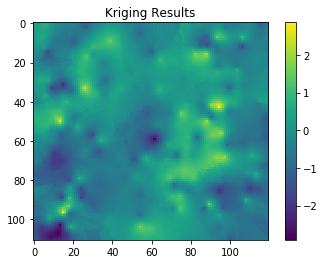

C:\Users\saryz\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


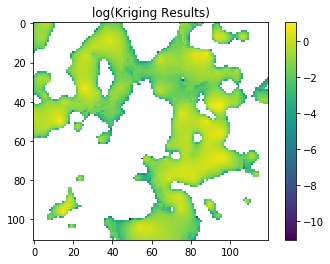

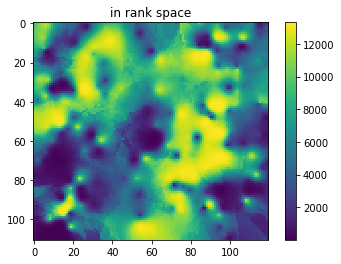

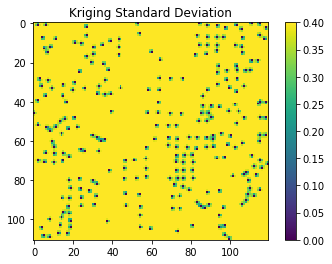

In [70]:
plt.title('Kriging Results')
plt.imshow(interpolation_kri,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('Ordinary Kriging map.png', dpi=300) #save a nice .png of this map.
plt.show()

plt.title('log(Kriging Results)')
plt.imshow(np.log(interpolation_kri),
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.

plt.show()

plt.title('in rank space')
plt.imshow(sst.rankdata(interpolation_kri.flatten()).reshape(Z.shape[0], Z.shape[1]),
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.

plt.show()

plt.title('Kriging Standard Deviation')
plt.imshow(std_kri,
          origin='lower',
          vmin=0.0,
          vmax=0.4)
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('Kriging standar deviation map.png', dpi=300) #save a nice .png of this map.
plt.show()

### Random path function

In [71]:
#Montecarlo random path

def random_path(seed, index_to_simulate): 
    #This function gives a matrix of the length of the indexes in the matrix without the observed data. it gives 
    np.random.seed(seed)
    path = np.random.choice(len(index_to_simulate),size=len(index_to_simulate), replace=False)#gives random values to change the order of the indexes according to this list
    return np.array(index_to_simulate)[path]
    
seed = 30
coord_order = random_path(seed,index_to_simulate)#Indexes random


# SGS

In [72]:
interpolation_sgs = np.copy(Z)
std_sgs = np.zeros((Z.shape[0],Z.shape[1]))
n_cond = 10
controls_sgs = controls
controlvalues_sgs = controlvalues
l =0


for n in coord_order:
    print (n)
    targets_sgs =  np.array([[Y[0,n[1]], X[n[0],0]]])#Select cell to calculate. It looks for the value of coordinates Y represents 
    print(targets_sgs)
    ok_result = kri.krige_ok(controls_sgs
                       , targets_sgs
                       , controlvalues_sgs
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
    print ('ID \t x \t y \t est(z)')    
    for i, result in enumerate(ok_result):
        print('{0:2d}\t{1:3.2f}\t{2:3.2f}\t{3:3.2f}'.format(l, targets_sgs[i][0], targets_sgs[i][1], result[1]))
        # the weights are stored in results[0] but not saved here
        interpolation_sgs[n[0], n[1]] = result[1]#Calculate kriging
        std_sgs[n[0], n[1]] = result[2]
        controlvalues_sgs = np.append(controlvalues_sgs,result[1])#Add cell to control values
    controls_sgs = np.append(controls_sgs, [targets_sgs], axis =0)#Add cell to control coordinates
    l = l+1


[ 25 102]
[[102000  25000]]
ID 	 x 	 y 	 est(z)
 0	102000.00	25000.00	0.46
[108  52]
[[ 52000 108000]]
ID 	 x 	 y 	 est(z)
 1	52000.00	108000.00	0.73
[19 66]
[[66000 19000]]
ID 	 x 	 y 	 est(z)
 2	66000.00	19000.00	0.73
[93 71]
[[71000 93000]]
ID 	 x 	 y 	 est(z)
 3	71000.00	93000.00	0.34
[51 99]
[[99000 51000]]
ID 	 x 	 y 	 est(z)
 4	99000.00	51000.00	0.05
[ 4 51]
[[51000  4000]]
ID 	 x 	 y 	 est(z)
 5	51000.00	4000.00	-0.42
[13 48]
[[48000 13000]]
ID 	 x 	 y 	 est(z)
 6	48000.00	13000.00	0.17
[90 29]
[[29000 90000]]
ID 	 x 	 y 	 est(z)
 7	29000.00	90000.00	-0.98
[32 59]
[[59000 32000]]
ID 	 x 	 y 	 est(z)
 8	59000.00	32000.00	-0.05
[ 6 70]
[[70000  6000]]
ID 	 x 	 y 	 est(z)
 9	70000.00	6000.00	-0.10
[76 77]
[[77000 76000]]
ID 	 x 	 y 	 est(z)
10	77000.00	76000.00	1.39
[56 52]
[[52000 56000]]
ID 	 x 	 y 	 est(z)
11	52000.00	56000.00	-0.85
[42  9]
[[ 9000 42000]]
ID 	 x 	 y 	 est(z)
12	9000.00	42000.00	0.51
[13 39]
[[39000 13000]]
ID 	 x 	 y 	 est(z)
13	39000.00	13000.00	0.84
[59 57]


130	69000.00	103000.00	0.48
[49 65]
[[65000 49000]]
ID 	 x 	 y 	 est(z)
131	65000.00	49000.00	-0.37
[80 49]
[[49000 80000]]
ID 	 x 	 y 	 est(z)
132	49000.00	80000.00	-0.28
[82 39]
[[39000 82000]]
ID 	 x 	 y 	 est(z)
133	39000.00	82000.00	-0.59
[ 5 94]
[[94000  5000]]
ID 	 x 	 y 	 est(z)
134	94000.00	5000.00	0.82
[101  13]
[[ 13000 101000]]
ID 	 x 	 y 	 est(z)
135	13000.00	101000.00	-1.29
[71 99]
[[99000 71000]]
ID 	 x 	 y 	 est(z)
136	99000.00	71000.00	0.87
[7 7]
[[7000 7000]]
ID 	 x 	 y 	 est(z)
137	7000.00	7000.00	0.14
[90 35]
[[35000 90000]]
ID 	 x 	 y 	 est(z)
138	35000.00	90000.00	-0.83
[ 77 114]
[[114000  77000]]
ID 	 x 	 y 	 est(z)
139	114000.00	77000.00	0.32
[ 52 112]
[[112000  52000]]
ID 	 x 	 y 	 est(z)
140	112000.00	52000.00	-0.67
[69 85]
[[85000 69000]]
ID 	 x 	 y 	 est(z)
141	85000.00	69000.00	0.88
[ 40 100]
[[100000  40000]]
ID 	 x 	 y 	 est(z)
142	100000.00	40000.00	0.64
[81 43]
[[43000 81000]]
ID 	 x 	 y 	 est(z)
143	43000.00	81000.00	-0.53
[ 48 114]
[[114000  48000]]
I

272	68000.00	27000.00	0.25
[59 41]
[[41000 59000]]
ID 	 x 	 y 	 est(z)
273	41000.00	59000.00	-0.23
[ 37 118]
[[118000  37000]]
ID 	 x 	 y 	 est(z)
274	118000.00	37000.00	0.18
[ 0 88]
[[88000     0]]
ID 	 x 	 y 	 est(z)
275	88000.00	0.00	-0.07
[ 4 11]
[[11000  4000]]
ID 	 x 	 y 	 est(z)
276	11000.00	4000.00	-0.11
[41 46]
[[46000 41000]]
ID 	 x 	 y 	 est(z)
277	46000.00	41000.00	0.03
[ 2 41]
[[41000  2000]]
ID 	 x 	 y 	 est(z)
278	41000.00	2000.00	0.49
[46 35]
[[35000 46000]]
ID 	 x 	 y 	 est(z)
279	35000.00	46000.00	0.20
[ 89 116]
[[116000  89000]]
ID 	 x 	 y 	 est(z)
280	116000.00	89000.00	-0.82
[93 41]
[[41000 93000]]
ID 	 x 	 y 	 est(z)
281	41000.00	93000.00	-0.37
[107  65]
[[ 65000 107000]]
ID 	 x 	 y 	 est(z)
282	65000.00	107000.00	0.61
[43 10]
[[10000 43000]]
ID 	 x 	 y 	 est(z)
283	10000.00	43000.00	0.67
[79  8]
[[ 8000 79000]]
ID 	 x 	 y 	 est(z)
284	8000.00	79000.00	-0.97
[58 73]
[[73000 58000]]
ID 	 x 	 y 	 est(z)
285	73000.00	58000.00	0.62
[108  80]
[[ 80000 108000]]
ID 	 x 	

397	61000.00	97000.00	0.19
[ 28 105]
[[105000  28000]]
ID 	 x 	 y 	 est(z)
398	105000.00	28000.00	0.16
[33 51]
[[51000 33000]]
ID 	 x 	 y 	 est(z)
399	51000.00	33000.00	0.05
[81 82]
[[82000 81000]]
ID 	 x 	 y 	 est(z)
400	82000.00	81000.00	0.66
[ 24 117]
[[117000  24000]]
ID 	 x 	 y 	 est(z)
401	117000.00	24000.00	-0.17
[95 87]
[[87000 95000]]
ID 	 x 	 y 	 est(z)
402	87000.00	95000.00	-0.54
[59  3]
[[ 3000 59000]]
ID 	 x 	 y 	 est(z)
403	3000.00	59000.00	0.00
[35 59]
[[59000 35000]]
ID 	 x 	 y 	 est(z)
404	59000.00	35000.00	-0.20
[57 23]
[[23000 57000]]
ID 	 x 	 y 	 est(z)
405	23000.00	57000.00	-0.31
[91 29]
[[29000 91000]]
ID 	 x 	 y 	 est(z)
406	29000.00	91000.00	-0.97
[104  36]
[[ 36000 104000]]
ID 	 x 	 y 	 est(z)
407	36000.00	104000.00	-0.08
[91  5]
[[ 5000 91000]]
ID 	 x 	 y 	 est(z)
408	5000.00	91000.00	-0.28
[54  8]
[[ 8000 54000]]
ID 	 x 	 y 	 est(z)
409	8000.00	54000.00	0.29
[32 97]
[[97000 32000]]
ID 	 x 	 y 	 est(z)
410	97000.00	32000.00	-0.29
[62 65]
[[65000 62000]]
ID 	 x

526	42000.00	10000.00	0.89
[55 28]
[[28000 55000]]
ID 	 x 	 y 	 est(z)
527	28000.00	55000.00	-0.82
[80 40]
[[40000 80000]]
ID 	 x 	 y 	 est(z)
528	40000.00	80000.00	-0.54
[54 42]
[[42000 54000]]
ID 	 x 	 y 	 est(z)
529	42000.00	54000.00	-0.21
[ 58 117]
[[117000  58000]]
ID 	 x 	 y 	 est(z)
530	117000.00	58000.00	-1.04
[56 43]
[[43000 56000]]
ID 	 x 	 y 	 est(z)
531	43000.00	56000.00	-0.29
[68 60]
[[60000 68000]]
ID 	 x 	 y 	 est(z)
532	60000.00	68000.00	0.19
[88 59]
[[59000 88000]]
ID 	 x 	 y 	 est(z)
533	59000.00	88000.00	-0.20
[ 79 107]
[[107000  79000]]
ID 	 x 	 y 	 est(z)
534	107000.00	79000.00	-0.53
[ 39 107]
[[107000  39000]]
ID 	 x 	 y 	 est(z)
535	107000.00	39000.00	0.08
[107   3]
[[  3000 107000]]
ID 	 x 	 y 	 est(z)
536	3000.00	107000.00	-1.97
[19 53]
[[53000 19000]]
ID 	 x 	 y 	 est(z)
537	53000.00	19000.00	-0.18
[78 10]
[[10000 78000]]
ID 	 x 	 y 	 est(z)
538	10000.00	78000.00	-1.10
[107  99]
[[ 99000 107000]]
ID 	 x 	 y 	 est(z)
539	99000.00	107000.00	-0.72
[ 96 107]
[[107

653	114000.00	100000.00	-0.71
[100  71]
[[ 71000 100000]]
ID 	 x 	 y 	 est(z)
654	71000.00	100000.00	0.44
[92 21]
[[21000 92000]]
ID 	 x 	 y 	 est(z)
655	21000.00	92000.00	0.37
[22 27]
[[27000 22000]]
ID 	 x 	 y 	 est(z)
656	27000.00	22000.00	0.75
[110 119]
[[119000 110000]]
ID 	 x 	 y 	 est(z)
657	119000.00	110000.00	-0.72
[68 73]
[[73000 68000]]
ID 	 x 	 y 	 est(z)
658	73000.00	68000.00	-0.38
[ 0 20]
[[20000     0]]
ID 	 x 	 y 	 est(z)
659	20000.00	0.00	-0.57
[64 39]
[[39000 64000]]
ID 	 x 	 y 	 est(z)
660	39000.00	64000.00	-0.43
[82 54]
[[54000 82000]]
ID 	 x 	 y 	 est(z)
661	54000.00	82000.00	-0.11
[28 94]
[[94000 28000]]
ID 	 x 	 y 	 est(z)
662	94000.00	28000.00	0.42
[ 13 102]
[[102000  13000]]
ID 	 x 	 y 	 est(z)
663	102000.00	13000.00	-0.68
[ 59 104]
[[104000  59000]]
ID 	 x 	 y 	 est(z)
664	104000.00	59000.00	-0.67
[19 35]
[[35000 19000]]
ID 	 x 	 y 	 est(z)
665	35000.00	19000.00	-0.01
[13 27]
[[27000 13000]]
ID 	 x 	 y 	 est(z)
666	27000.00	13000.00	0.58
[ 15 108]
[[108000  15

777	53000.00	98000.00	-0.56
[34 96]
[[96000 34000]]
ID 	 x 	 y 	 est(z)
778	96000.00	34000.00	0.13
[99  0]
[[    0 99000]]
ID 	 x 	 y 	 est(z)
779	0.00	99000.00	-1.25
[110  65]
[[ 65000 110000]]
ID 	 x 	 y 	 est(z)
780	65000.00	110000.00	0.54
[55 22]
[[22000 55000]]
ID 	 x 	 y 	 est(z)
781	22000.00	55000.00	0.05
[94 62]
[[62000 94000]]
ID 	 x 	 y 	 est(z)
782	62000.00	94000.00	0.09
[56 34]
[[34000 56000]]
ID 	 x 	 y 	 est(z)
783	34000.00	56000.00	-0.07
[ 81 114]
[[114000  81000]]
ID 	 x 	 y 	 est(z)
784	114000.00	81000.00	-0.69
[2 7]
[[7000 2000]]
ID 	 x 	 y 	 est(z)
785	7000.00	2000.00	0.51
[  9 104]
[[104000   9000]]
ID 	 x 	 y 	 est(z)
786	104000.00	9000.00	-0.17
[  0 103]
[[103000      0]]
ID 	 x 	 y 	 est(z)
787	103000.00	0.00	-0.36
[44  2]
[[ 2000 44000]]
ID 	 x 	 y 	 est(z)
788	2000.00	44000.00	0.43
[83  2]
[[ 2000 83000]]
ID 	 x 	 y 	 est(z)
789	2000.00	83000.00	-0.44
[73 99]
[[99000 73000]]
ID 	 x 	 y 	 est(z)
790	99000.00	73000.00	0.55
[17 60]
[[60000 17000]]
ID 	 x 	 y 	 est

[84 34]
[[34000 84000]]
ID 	 x 	 y 	 est(z)
892	34000.00	84000.00	-0.79
[83  6]
[[ 6000 83000]]
ID 	 x 	 y 	 est(z)
893	6000.00	83000.00	-0.58
[ 7 19]
[[19000  7000]]
ID 	 x 	 y 	 est(z)
894	19000.00	7000.00	-0.74
[27 89]
[[89000 27000]]
ID 	 x 	 y 	 est(z)
895	89000.00	27000.00	0.42
[21 80]
[[80000 21000]]
ID 	 x 	 y 	 est(z)
896	80000.00	21000.00	0.80
[52  9]
[[ 9000 52000]]
ID 	 x 	 y 	 est(z)
897	9000.00	52000.00	0.62
[ 6 44]
[[44000  6000]]
ID 	 x 	 y 	 est(z)
898	44000.00	6000.00	0.54
[52 15]
[[15000 52000]]
ID 	 x 	 y 	 est(z)
899	15000.00	52000.00	0.62
[106  68]
[[ 68000 106000]]
ID 	 x 	 y 	 est(z)
900	68000.00	106000.00	0.50
[  9 106]
[[106000   9000]]
ID 	 x 	 y 	 est(z)
901	106000.00	9000.00	0.02
[48 89]
[[89000 48000]]
ID 	 x 	 y 	 est(z)
902	89000.00	48000.00	0.07
[50 55]
[[55000 50000]]
ID 	 x 	 y 	 est(z)
903	55000.00	50000.00	-0.73
[28 55]
[[55000 28000]]
ID 	 x 	 y 	 est(z)
904	55000.00	28000.00	0.03
[18 57]
[[57000 18000]]
ID 	 x 	 y 	 est(z)
905	57000.00	18000.00	-0

1015	42000.00	79000.00	-0.53
[70 69]
[[69000 70000]]
ID 	 x 	 y 	 est(z)
1016	69000.00	70000.00	0.38
[ 54 118]
[[118000  54000]]
ID 	 x 	 y 	 est(z)
1017	118000.00	54000.00	-1.04
[104 119]
[[119000 104000]]
ID 	 x 	 y 	 est(z)
1018	119000.00	104000.00	-0.74
[ 79 104]
[[104000  79000]]
ID 	 x 	 y 	 est(z)
1019	104000.00	79000.00	-0.48
[27 50]
[[50000 27000]]
ID 	 x 	 y 	 est(z)
1020	50000.00	27000.00	0.12
[50 46]
[[46000 50000]]
ID 	 x 	 y 	 est(z)
1021	46000.00	50000.00	-0.27
[14 19]
[[19000 14000]]
ID 	 x 	 y 	 est(z)
1022	19000.00	14000.00	-0.28
[ 75 117]
[[117000  75000]]
ID 	 x 	 y 	 est(z)
1023	117000.00	75000.00	-0.67
[16  4]
[[ 4000 16000]]
ID 	 x 	 y 	 est(z)
1024	4000.00	16000.00	-0.64
[59 84]
[[84000 59000]]
ID 	 x 	 y 	 est(z)
1025	84000.00	59000.00	-0.40
[11  9]
[[ 9000 11000]]
ID 	 x 	 y 	 est(z)
1026	9000.00	11000.00	-0.50
[55 46]
[[46000 55000]]
ID 	 x 	 y 	 est(z)
1027	46000.00	55000.00	-0.45
[21 56]
[[56000 21000]]
ID 	 x 	 y 	 est(z)
1028	56000.00	21000.00	-0.07
[68 4

[28 30]
[[30000 28000]]
ID 	 x 	 y 	 est(z)
1136	30000.00	28000.00	0.45
[38 11]
[[11000 38000]]
ID 	 x 	 y 	 est(z)
1137	11000.00	38000.00	-0.01
[96 55]
[[55000 96000]]
ID 	 x 	 y 	 est(z)
1138	55000.00	96000.00	-0.49
[95 13]
[[13000 95000]]
ID 	 x 	 y 	 est(z)
1139	13000.00	95000.00	1.22
[23 11]
[[11000 23000]]
ID 	 x 	 y 	 est(z)
1140	11000.00	23000.00	-0.32
[ 93 109]
[[109000  93000]]
ID 	 x 	 y 	 est(z)
1141	109000.00	93000.00	-0.22
[107 113]
[[113000 107000]]
ID 	 x 	 y 	 est(z)
1142	113000.00	107000.00	-0.75
[52 51]
[[51000 52000]]
ID 	 x 	 y 	 est(z)
1143	51000.00	52000.00	-0.64
[84 20]
[[20000 84000]]
ID 	 x 	 y 	 est(z)
1144	20000.00	84000.00	-0.05
[72 43]
[[43000 72000]]
ID 	 x 	 y 	 est(z)
1145	43000.00	72000.00	-0.46
[40 96]
[[96000 40000]]
ID 	 x 	 y 	 est(z)
1146	96000.00	40000.00	1.57
[25 99]
[[99000 25000]]
ID 	 x 	 y 	 est(z)
1147	99000.00	25000.00	0.41
[77  4]
[[ 4000 77000]]
ID 	 x 	 y 	 est(z)
1148	4000.00	77000.00	-0.87
[79 58]
[[58000 79000]]
ID 	 x 	 y 	 est(z)
1

1270	86000.00	3000.00	-0.26
[86 72]
[[72000 86000]]
ID 	 x 	 y 	 est(z)
1271	72000.00	86000.00	0.50
[19 95]
[[95000 19000]]
ID 	 x 	 y 	 est(z)
1272	95000.00	19000.00	-0.31
[16 28]
[[28000 16000]]
ID 	 x 	 y 	 est(z)
1273	28000.00	16000.00	0.77
[47 57]
[[57000 47000]]
ID 	 x 	 y 	 est(z)
1274	57000.00	47000.00	-0.97
[86 53]
[[53000 86000]]
ID 	 x 	 y 	 est(z)
1275	53000.00	86000.00	-0.60
[82 35]
[[35000 82000]]
ID 	 x 	 y 	 est(z)
1276	35000.00	82000.00	-0.75
[92 33]
[[33000 92000]]
ID 	 x 	 y 	 est(z)
1277	33000.00	92000.00	-0.87
[82  1]
[[ 1000 82000]]
ID 	 x 	 y 	 est(z)
1278	1000.00	82000.00	-0.50
[77 54]
[[54000 77000]]
ID 	 x 	 y 	 est(z)
1279	54000.00	77000.00	0.01
[  3 107]
[[107000   3000]]
ID 	 x 	 y 	 est(z)
1280	107000.00	3000.00	-0.14
[60 17]
[[17000 60000]]
ID 	 x 	 y 	 est(z)
1281	17000.00	60000.00	-0.92
[ 93 112]
[[112000  93000]]
ID 	 x 	 y 	 est(z)
1282	112000.00	93000.00	-0.39
[106  72]
[[ 72000 106000]]
ID 	 x 	 y 	 est(z)
1283	72000.00	106000.00	0.35
[35  4]
[[ 400

1400	84000.00	67000.00	0.67
[75 73]
[[73000 75000]]
ID 	 x 	 y 	 est(z)
1401	73000.00	75000.00	1.13
[ 31 112]
[[112000  31000]]
ID 	 x 	 y 	 est(z)
1402	112000.00	31000.00	-0.13
[79 89]
[[89000 79000]]
ID 	 x 	 y 	 est(z)
1403	89000.00	79000.00	0.32
[27 72]
[[72000 27000]]
ID 	 x 	 y 	 est(z)
1404	72000.00	27000.00	0.18
[ 48 112]
[[112000  48000]]
ID 	 x 	 y 	 est(z)
1405	112000.00	48000.00	-0.55
[49 79]
[[79000 49000]]
ID 	 x 	 y 	 est(z)
1406	79000.00	49000.00	0.83
[16 13]
[[13000 16000]]
ID 	 x 	 y 	 est(z)
1407	13000.00	16000.00	-0.48
[ 2 71]
[[71000  2000]]
ID 	 x 	 y 	 est(z)
1408	71000.00	2000.00	-0.17
[56 46]
[[46000 56000]]
ID 	 x 	 y 	 est(z)
1409	46000.00	56000.00	-0.44
[93 62]
[[62000 93000]]
ID 	 x 	 y 	 est(z)
1410	62000.00	93000.00	0.08
[33 50]
[[50000 33000]]
ID 	 x 	 y 	 est(z)
1411	50000.00	33000.00	0.12
[11 10]
[[10000 11000]]
ID 	 x 	 y 	 est(z)
1412	10000.00	11000.00	-0.55
[86  2]
[[ 2000 86000]]
ID 	 x 	 y 	 est(z)
1413	2000.00	86000.00	-0.20
[100 103]
[[103000 10

1529	16000.00	3000.00	-0.40
[106  31]
[[ 31000 106000]]
ID 	 x 	 y 	 est(z)
1530	31000.00	106000.00	-0.41
[62 70]
[[70000 62000]]
ID 	 x 	 y 	 est(z)
1531	70000.00	62000.00	0.49
[55 37]
[[37000 55000]]
ID 	 x 	 y 	 est(z)
1532	37000.00	55000.00	-0.05
[100 117]
[[117000 100000]]
ID 	 x 	 y 	 est(z)
1533	117000.00	100000.00	-0.75
[58 46]
[[46000 58000]]
ID 	 x 	 y 	 est(z)
1534	46000.00	58000.00	-0.47
[43 78]
[[78000 43000]]
ID 	 x 	 y 	 est(z)
1535	78000.00	43000.00	0.58
[109  38]
[[ 38000 109000]]
ID 	 x 	 y 	 est(z)
1536	38000.00	109000.00	-0.08
[ 5 99]
[[99000  5000]]
ID 	 x 	 y 	 est(z)
1537	99000.00	5000.00	0.08
[107  78]
[[ 78000 107000]]
ID 	 x 	 y 	 est(z)
1538	78000.00	107000.00	0.20
[23 50]
[[50000 23000]]
ID 	 x 	 y 	 est(z)
1539	50000.00	23000.00	0.08
[34 89]
[[89000 34000]]
ID 	 x 	 y 	 est(z)
1540	89000.00	34000.00	0.19
[10 20]
[[20000 10000]]
ID 	 x 	 y 	 est(z)
1541	20000.00	10000.00	-0.91
[84 69]
[[69000 84000]]
ID 	 x 	 y 	 est(z)
1542	69000.00	84000.00	0.12
[105  82]


[35 69]
[[69000 35000]]
ID 	 x 	 y 	 est(z)
1662	69000.00	35000.00	0.32
[57  6]
[[ 6000 57000]]
ID 	 x 	 y 	 est(z)
1663	6000.00	57000.00	0.07
[ 9 79]
[[79000  9000]]
ID 	 x 	 y 	 est(z)
1664	79000.00	9000.00	-0.10
[68 84]
[[84000 68000]]
ID 	 x 	 y 	 est(z)
1665	84000.00	68000.00	0.74
[76 29]
[[29000 76000]]
ID 	 x 	 y 	 est(z)
1666	29000.00	76000.00	-0.47
[73 77]
[[77000 73000]]
ID 	 x 	 y 	 est(z)
1667	77000.00	73000.00	1.15
[  2 101]
[[101000   2000]]
ID 	 x 	 y 	 est(z)
1668	101000.00	2000.00	-0.29
[ 67 118]
[[118000  67000]]
ID 	 x 	 y 	 est(z)
1669	118000.00	67000.00	-0.48
[96 30]
[[30000 96000]]
ID 	 x 	 y 	 est(z)
1670	30000.00	96000.00	-0.60
[87 91]
[[91000 87000]]
ID 	 x 	 y 	 est(z)
1671	91000.00	87000.00	-0.93
[ 2 73]
[[73000  2000]]
ID 	 x 	 y 	 est(z)
1672	73000.00	2000.00	-0.14
[107 111]
[[111000 107000]]
ID 	 x 	 y 	 est(z)
1673	111000.00	107000.00	-0.75
[84 73]
[[73000 84000]]
ID 	 x 	 y 	 est(z)
1674	73000.00	84000.00	-0.13
[  9 118]
[[118000   9000]]
ID 	 x 	 y 	 es

1795	105000.00	110000.00	-0.85
[67 71]
[[71000 67000]]
ID 	 x 	 y 	 est(z)
1796	71000.00	67000.00	-0.30
[ 6 79]
[[79000  6000]]
ID 	 x 	 y 	 est(z)
1797	79000.00	6000.00	-0.20
[61 73]
[[73000 61000]]
ID 	 x 	 y 	 est(z)
1798	73000.00	61000.00	0.61
[70 62]
[[62000 70000]]
ID 	 x 	 y 	 est(z)
1799	62000.00	70000.00	0.31
[43 79]
[[79000 43000]]
ID 	 x 	 y 	 est(z)
1800	79000.00	43000.00	0.51
[110   3]
[[  3000 110000]]
ID 	 x 	 y 	 est(z)
1801	3000.00	110000.00	-1.99
[102  46]
[[ 46000 102000]]
ID 	 x 	 y 	 est(z)
1802	46000.00	102000.00	0.21
[ 28 118]
[[118000  28000]]
ID 	 x 	 y 	 est(z)
1803	118000.00	28000.00	-0.14
[101  57]
[[ 57000 101000]]
ID 	 x 	 y 	 est(z)
1804	57000.00	101000.00	0.53
[48 75]
[[75000 48000]]
ID 	 x 	 y 	 est(z)
1805	75000.00	48000.00	1.17
[13 11]
[[11000 13000]]
ID 	 x 	 y 	 est(z)
1806	11000.00	13000.00	-0.61
[62 27]
[[27000 62000]]
ID 	 x 	 y 	 est(z)
1807	27000.00	62000.00	-0.55
[12 92]
[[92000 12000]]
ID 	 x 	 y 	 est(z)
1808	92000.00	12000.00	-0.51
[99 60]


1917	40000.00	3000.00	0.60
[93 89]
[[89000 93000]]
ID 	 x 	 y 	 est(z)
1918	89000.00	93000.00	0.99
[74 76]
[[76000 74000]]
ID 	 x 	 y 	 est(z)
1919	76000.00	74000.00	1.26
[ 69 110]
[[110000  69000]]
ID 	 x 	 y 	 est(z)
1920	110000.00	69000.00	0.42
[48 12]
[[12000 48000]]
ID 	 x 	 y 	 est(z)
1921	12000.00	48000.00	1.46
[98 58]
[[58000 98000]]
ID 	 x 	 y 	 est(z)
1922	58000.00	98000.00	0.06
[69 87]
[[87000 69000]]
ID 	 x 	 y 	 est(z)
1923	87000.00	69000.00	1.04
[62 22]
[[22000 62000]]
ID 	 x 	 y 	 est(z)
1924	22000.00	62000.00	-0.65
[ 3 26]
[[26000  3000]]
ID 	 x 	 y 	 est(z)
1925	26000.00	3000.00	-0.84
[68 96]
[[96000 68000]]
ID 	 x 	 y 	 est(z)
1926	96000.00	68000.00	1.78
[68 16]
[[16000 68000]]
ID 	 x 	 y 	 est(z)
1927	16000.00	68000.00	-1.45
[13 78]
[[78000 13000]]
ID 	 x 	 y 	 est(z)
1928	78000.00	13000.00	0.29
[40 65]
[[65000 40000]]
ID 	 x 	 y 	 est(z)
1929	65000.00	40000.00	-0.21
[ 3 14]
[[14000  3000]]
ID 	 x 	 y 	 est(z)
1930	14000.00	3000.00	-0.26
[49 91]
[[91000 49000]]
ID 	 

2041	69000.00	9000.00	-0.02
[51 73]
[[73000 51000]]
ID 	 x 	 y 	 est(z)
2042	73000.00	51000.00	0.70
[73 62]
[[62000 73000]]
ID 	 x 	 y 	 est(z)
2043	62000.00	73000.00	0.34
[36 18]
[[18000 36000]]
ID 	 x 	 y 	 est(z)
2044	18000.00	36000.00	-0.33
[11  6]
[[ 6000 11000]]
ID 	 x 	 y 	 est(z)
2045	6000.00	11000.00	0.06
[105  21]
[[ 21000 105000]]
ID 	 x 	 y 	 est(z)
2046	21000.00	105000.00	-0.22
[ 13 104]
[[104000  13000]]
ID 	 x 	 y 	 est(z)
2047	104000.00	13000.00	-0.93
[104  37]
[[ 37000 104000]]
ID 	 x 	 y 	 est(z)
2048	37000.00	104000.00	-0.03
[ 72 108]
[[108000  72000]]
ID 	 x 	 y 	 est(z)
2049	108000.00	72000.00	0.14
[64 33]
[[33000 64000]]
ID 	 x 	 y 	 est(z)
2050	33000.00	64000.00	-0.97
[49 60]
[[60000 49000]]
ID 	 x 	 y 	 est(z)
2051	60000.00	49000.00	-0.63
[ 2 98]
[[98000  2000]]
ID 	 x 	 y 	 est(z)
2052	98000.00	2000.00	-0.46
[24 59]
[[59000 24000]]
ID 	 x 	 y 	 est(z)
2053	59000.00	24000.00	0.15
[78 12]
[[12000 78000]]
ID 	 x 	 y 	 est(z)
2054	12000.00	78000.00	-1.13
[23 35]
[[

2173	30000.00	85000.00	-0.77
[99 58]
[[58000 99000]]
ID 	 x 	 y 	 est(z)
2174	58000.00	99000.00	0.22
[37 20]
[[20000 37000]]
ID 	 x 	 y 	 est(z)
2175	20000.00	37000.00	0.01
[  5 119]
[[119000   5000]]
ID 	 x 	 y 	 est(z)
2176	119000.00	5000.00	-0.46
[ 5 79]
[[79000  5000]]
ID 	 x 	 y 	 est(z)
2177	79000.00	5000.00	-0.19
[45 92]
[[92000 45000]]
ID 	 x 	 y 	 est(z)
2178	92000.00	45000.00	0.91
[0 9]
[[9000    0]]
ID 	 x 	 y 	 est(z)
2179	9000.00	0.00	0.32
[110  85]
[[ 85000 110000]]
ID 	 x 	 y 	 est(z)
2180	85000.00	110000.00	-0.06
[37 88]
[[88000 37000]]
ID 	 x 	 y 	 est(z)
2181	88000.00	37000.00	0.31
[59 38]
[[38000 59000]]
ID 	 x 	 y 	 est(z)
2182	38000.00	59000.00	0.02
[48  3]
[[ 3000 48000]]
ID 	 x 	 y 	 est(z)
2183	3000.00	48000.00	0.71
[54 50]
[[50000 54000]]
ID 	 x 	 y 	 est(z)
2184	50000.00	54000.00	-0.70
[46 31]
[[31000 46000]]
ID 	 x 	 y 	 est(z)
2185	31000.00	46000.00	0.07
[27 74]
[[74000 27000]]
ID 	 x 	 y 	 est(z)
2186	74000.00	27000.00	0.15
[107  45]
[[ 45000 107000]]
ID 	 

2285	41000.00	52000.00	-0.11
[31 60]
[[60000 31000]]
ID 	 x 	 y 	 est(z)
2286	60000.00	31000.00	0.11
[34 71]
[[71000 34000]]
ID 	 x 	 y 	 est(z)
2287	71000.00	34000.00	0.27
[ 47 102]
[[102000  47000]]
ID 	 x 	 y 	 est(z)
2288	102000.00	47000.00	-0.31
[110  38]
[[ 38000 110000]]
ID 	 x 	 y 	 est(z)
2289	38000.00	110000.00	-0.07
[109  76]
[[ 76000 109000]]
ID 	 x 	 y 	 est(z)
2290	76000.00	109000.00	0.24
[73 34]
[[34000 73000]]
ID 	 x 	 y 	 est(z)
2291	34000.00	73000.00	-0.59
[22 59]
[[59000 22000]]
ID 	 x 	 y 	 est(z)
2292	59000.00	22000.00	0.13
[36 16]
[[16000 36000]]
ID 	 x 	 y 	 est(z)
2293	16000.00	36000.00	-0.26
[26 74]
[[74000 26000]]
ID 	 x 	 y 	 est(z)
2294	74000.00	26000.00	0.21
[84 76]
[[76000 84000]]
ID 	 x 	 y 	 est(z)
2295	76000.00	84000.00	-0.31
[64 42]
[[42000 64000]]
ID 	 x 	 y 	 est(z)
2296	42000.00	64000.00	-0.43
[56  7]
[[ 7000 56000]]
ID 	 x 	 y 	 est(z)
2297	7000.00	56000.00	0.08
[43 20]
[[20000 43000]]
ID 	 x 	 y 	 est(z)
2298	20000.00	43000.00	0.35
[ 1 58]
[[58000

2414	45000.00	56000.00	-0.40
[84 36]
[[36000 84000]]
ID 	 x 	 y 	 est(z)
2415	36000.00	84000.00	-0.72
[65  8]
[[ 8000 65000]]
ID 	 x 	 y 	 est(z)
2416	8000.00	65000.00	-1.03
[83 43]
[[43000 83000]]
ID 	 x 	 y 	 est(z)
2417	43000.00	83000.00	-0.49
[36 65]
[[65000 36000]]
ID 	 x 	 y 	 est(z)
2418	65000.00	36000.00	0.37
[18 31]
[[31000 18000]]
ID 	 x 	 y 	 est(z)
2419	31000.00	18000.00	0.35
[38 24]
[[24000 38000]]
ID 	 x 	 y 	 est(z)
2420	24000.00	38000.00	0.63
[ 4 54]
[[54000  4000]]
ID 	 x 	 y 	 est(z)
2421	54000.00	4000.00	-0.76
[55 12]
[[12000 55000]]
ID 	 x 	 y 	 est(z)
2422	12000.00	55000.00	-0.21
[ 1 46]
[[46000  1000]]
ID 	 x 	 y 	 est(z)
2423	46000.00	1000.00	0.22
[ 84 111]
[[111000  84000]]
ID 	 x 	 y 	 est(z)
2424	111000.00	84000.00	-1.62
[108 109]
[[109000 108000]]
ID 	 x 	 y 	 est(z)
2425	109000.00	108000.00	-0.77
[15 27]
[[27000 15000]]
ID 	 x 	 y 	 est(z)
2426	27000.00	15000.00	0.77
[79 47]
[[47000 79000]]
ID 	 x 	 y 	 est(z)
2427	47000.00	79000.00	-0.51
[68 69]
[[69000 680

[91 48]
[[48000 91000]]
ID 	 x 	 y 	 est(z)
2545	48000.00	91000.00	-0.37
[103 108]
[[108000 103000]]
ID 	 x 	 y 	 est(z)
2546	108000.00	103000.00	-0.68
[84 57]
[[57000 84000]]
ID 	 x 	 y 	 est(z)
2547	57000.00	84000.00	-0.17
[36 13]
[[13000 36000]]
ID 	 x 	 y 	 est(z)
2548	13000.00	36000.00	-0.39
[84 22]
[[22000 84000]]
ID 	 x 	 y 	 est(z)
2549	22000.00	84000.00	-0.76
[65 81]
[[81000 65000]]
ID 	 x 	 y 	 est(z)
2550	81000.00	65000.00	0.42
[102  86]
[[ 86000 102000]]
ID 	 x 	 y 	 est(z)
2551	86000.00	102000.00	-0.04
[ 8 23]
[[23000  8000]]
ID 	 x 	 y 	 est(z)
2552	23000.00	8000.00	-0.57
[41  5]
[[ 5000 41000]]
ID 	 x 	 y 	 est(z)
2553	5000.00	41000.00	0.29
[ 83 106]
[[106000  83000]]
ID 	 x 	 y 	 est(z)
2554	106000.00	83000.00	-0.93
[ 17 113]
[[113000  17000]]
ID 	 x 	 y 	 est(z)
2555	113000.00	17000.00	-0.23
[47 87]
[[87000 47000]]
ID 	 x 	 y 	 est(z)
2556	87000.00	47000.00	0.18
[  6 101]
[[101000   6000]]
ID 	 x 	 y 	 est(z)
2557	101000.00	6000.00	0.07
[46 52]
[[52000 46000]]
ID 	 x 	

[13 51]
[[51000 13000]]
ID 	 x 	 y 	 est(z)
2670	51000.00	13000.00	-0.08
[ 4 76]
[[76000  4000]]
ID 	 x 	 y 	 est(z)
2671	76000.00	4000.00	-0.10
[ 1 13]
[[13000  1000]]
ID 	 x 	 y 	 est(z)
2672	13000.00	1000.00	-0.09
[12 29]
[[29000 12000]]
ID 	 x 	 y 	 est(z)
2673	29000.00	12000.00	0.76
[52 94]
[[94000 52000]]
ID 	 x 	 y 	 est(z)
2674	94000.00	52000.00	0.75
[ 77 119]
[[119000  77000]]
ID 	 x 	 y 	 est(z)
2675	119000.00	77000.00	-0.63
[ 32 104]
[[104000  32000]]
ID 	 x 	 y 	 est(z)
2676	104000.00	32000.00	0.01
[76 31]
[[31000 76000]]
ID 	 x 	 y 	 est(z)
2677	31000.00	76000.00	-0.54
[ 55 117]
[[117000  55000]]
ID 	 x 	 y 	 est(z)
2678	117000.00	55000.00	-1.01
[ 5 70]
[[70000  5000]]
ID 	 x 	 y 	 est(z)
2679	70000.00	5000.00	-0.13
[93 27]
[[27000 93000]]
ID 	 x 	 y 	 est(z)
2680	27000.00	93000.00	-0.53
[70 27]
[[27000 70000]]
ID 	 x 	 y 	 est(z)
2681	27000.00	70000.00	-0.47
[ 89 108]
[[108000  89000]]
ID 	 x 	 y 	 est(z)
2682	108000.00	89000.00	0.01
[49 54]
[[54000 49000]]
ID 	 x 	 y 	 e

2803	31000.00	110000.00	-0.56
[ 98 112]
[[112000  98000]]
ID 	 x 	 y 	 est(z)
2804	112000.00	98000.00	-0.61
[ 5 40]
[[40000  5000]]
ID 	 x 	 y 	 est(z)
2805	40000.00	5000.00	0.76
[70 76]
[[76000 70000]]
ID 	 x 	 y 	 est(z)
2806	76000.00	70000.00	0.75
[  2 117]
[[117000   2000]]
ID 	 x 	 y 	 est(z)
2807	117000.00	2000.00	-0.67
[72 79]
[[79000 72000]]
ID 	 x 	 y 	 est(z)
2808	79000.00	72000.00	0.99
[41 97]
[[97000 41000]]
ID 	 x 	 y 	 est(z)
2809	97000.00	41000.00	1.25
[47  3]
[[ 3000 47000]]
ID 	 x 	 y 	 est(z)
2810	3000.00	47000.00	0.66
[78 93]
[[93000 78000]]
ID 	 x 	 y 	 est(z)
2811	93000.00	78000.00	0.09
[109  17]
[[ 17000 109000]]
ID 	 x 	 y 	 est(z)
2812	17000.00	109000.00	-1.84
[23 85]
[[85000 23000]]
ID 	 x 	 y 	 est(z)
2813	85000.00	23000.00	0.72
[83 39]
[[39000 83000]]
ID 	 x 	 y 	 est(z)
2814	39000.00	83000.00	-0.60
[103  45]
[[ 45000 103000]]
ID 	 x 	 y 	 est(z)
2815	45000.00	103000.00	0.22
[99 93]
[[93000 99000]]
ID 	 x 	 y 	 est(z)
2816	93000.00	99000.00	0.14
[46 41]
[[410

2924	81000.00	40000.00	0.15
[29 77]
[[77000 29000]]
ID 	 x 	 y 	 est(z)
2925	77000.00	29000.00	0.05
[ 5 33]
[[33000  5000]]
ID 	 x 	 y 	 est(z)
2926	33000.00	5000.00	0.36
[ 96 103]
[[103000  96000]]
ID 	 x 	 y 	 est(z)
2927	103000.00	96000.00	-0.71
[102 111]
[[111000 102000]]
ID 	 x 	 y 	 est(z)
2928	111000.00	102000.00	-0.69
[99 84]
[[84000 99000]]
ID 	 x 	 y 	 est(z)
2929	84000.00	99000.00	-0.00
[14  4]
[[ 4000 14000]]
ID 	 x 	 y 	 est(z)
2930	4000.00	14000.00	-0.25
[106 106]
[[106000 106000]]
ID 	 x 	 y 	 est(z)
2931	106000.00	106000.00	-0.74
[54 26]
[[26000 54000]]
ID 	 x 	 y 	 est(z)
2932	26000.00	54000.00	-0.33
[55 49]
[[49000 55000]]
ID 	 x 	 y 	 est(z)
2933	49000.00	55000.00	-0.66
[106 114]
[[114000 106000]]
ID 	 x 	 y 	 est(z)
2934	114000.00	106000.00	-0.75
[18 47]
[[47000 18000]]
ID 	 x 	 y 	 est(z)
2935	47000.00	18000.00	0.26
[ 27 110]
[[110000  27000]]
ID 	 x 	 y 	 est(z)
2936	110000.00	27000.00	-0.21
[38 76]
[[76000 38000]]
ID 	 x 	 y 	 est(z)
2937	76000.00	38000.00	0.27
[

3052	17000.00	105000.00	-0.92
[36 77]
[[77000 36000]]
ID 	 x 	 y 	 est(z)
3053	77000.00	36000.00	0.19
[14 75]
[[75000 14000]]
ID 	 x 	 y 	 est(z)
3054	75000.00	14000.00	0.31
[90 56]
[[56000 90000]]
ID 	 x 	 y 	 est(z)
3055	56000.00	90000.00	-0.41
[95 51]
[[51000 95000]]
ID 	 x 	 y 	 est(z)
3056	51000.00	95000.00	-0.38
[76 75]
[[75000 76000]]
ID 	 x 	 y 	 est(z)
3057	75000.00	76000.00	1.26
[14 82]
[[82000 14000]]
ID 	 x 	 y 	 est(z)
3058	82000.00	14000.00	0.63
[ 71 106]
[[106000  71000]]
ID 	 x 	 y 	 est(z)
3059	106000.00	71000.00	0.19
[ 70 110]
[[110000  70000]]
ID 	 x 	 y 	 est(z)
3060	110000.00	70000.00	0.29
[83 61]
[[61000 83000]]
ID 	 x 	 y 	 est(z)
3061	61000.00	83000.00	0.05
[  2 112]
[[112000   2000]]
ID 	 x 	 y 	 est(z)
3062	112000.00	2000.00	-0.37
[31 44]
[[44000 31000]]
ID 	 x 	 y 	 est(z)
3063	44000.00	31000.00	0.42
[76 13]
[[13000 76000]]
ID 	 x 	 y 	 est(z)
3064	13000.00	76000.00	-1.32
[ 56 110]
[[110000  56000]]
ID 	 x 	 y 	 est(z)
3065	110000.00	56000.00	-0.67
[110  55]


3178	6000.00	33000.00	-0.18
[79 51]
[[51000 79000]]
ID 	 x 	 y 	 est(z)
3179	51000.00	79000.00	0.00
[38 66]
[[66000 38000]]
ID 	 x 	 y 	 est(z)
3180	66000.00	38000.00	0.11
[34 57]
[[57000 34000]]
ID 	 x 	 y 	 est(z)
3181	57000.00	34000.00	-0.27
[106  50]
[[ 50000 106000]]
ID 	 x 	 y 	 est(z)
3182	50000.00	106000.00	0.64
[50 48]
[[48000 50000]]
ID 	 x 	 y 	 est(z)
3183	48000.00	50000.00	-0.36
[71 71]
[[71000 71000]]
ID 	 x 	 y 	 est(z)
3184	71000.00	71000.00	0.47
[32 85]
[[85000 32000]]
ID 	 x 	 y 	 est(z)
3185	85000.00	32000.00	0.10
[ 59 102]
[[102000  59000]]
ID 	 x 	 y 	 est(z)
3186	102000.00	59000.00	-0.58
[75 71]
[[71000 75000]]
ID 	 x 	 y 	 est(z)
3187	71000.00	75000.00	0.97
[88  3]
[[ 3000 88000]]
ID 	 x 	 y 	 est(z)
3188	3000.00	88000.00	-0.22
[22 69]
[[69000 22000]]
ID 	 x 	 y 	 est(z)
3189	69000.00	22000.00	0.45
[94 83]
[[83000 94000]]
ID 	 x 	 y 	 est(z)
3190	83000.00	94000.00	-0.09
[46 40]
[[40000 46000]]
ID 	 x 	 y 	 est(z)
3191	40000.00	46000.00	0.20
[44  5]
[[ 5000 44000]

[74 45]
[[45000 74000]]
ID 	 x 	 y 	 est(z)
3301	45000.00	74000.00	-0.44
[88  7]
[[ 7000 88000]]
ID 	 x 	 y 	 est(z)
3302	7000.00	88000.00	-0.40
[55  5]
[[ 5000 55000]]
ID 	 x 	 y 	 est(z)
3303	5000.00	55000.00	0.37
[77 70]
[[70000 77000]]
ID 	 x 	 y 	 est(z)
3304	70000.00	77000.00	1.03
[28 25]
[[25000 28000]]
ID 	 x 	 y 	 est(z)
3305	25000.00	28000.00	0.84
[72 23]
[[23000 72000]]
ID 	 x 	 y 	 est(z)
3306	23000.00	72000.00	-0.63
[67 80]
[[80000 67000]]
ID 	 x 	 y 	 est(z)
3307	80000.00	67000.00	0.42
[70 78]
[[78000 70000]]
ID 	 x 	 y 	 est(z)
3308	78000.00	70000.00	0.80
[87 85]
[[85000 87000]]
ID 	 x 	 y 	 est(z)
3309	85000.00	87000.00	-0.27
[ 62 112]
[[112000  62000]]
ID 	 x 	 y 	 est(z)
3310	112000.00	62000.00	-0.56
[45 26]
[[26000 45000]]
ID 	 x 	 y 	 est(z)
3311	26000.00	45000.00	0.05
[33 54]
[[54000 33000]]
ID 	 x 	 y 	 est(z)
3312	54000.00	33000.00	-0.05
[70 31]
[[31000 70000]]
ID 	 x 	 y 	 est(z)
3313	31000.00	70000.00	-0.67
[ 67 119]
[[119000  67000]]
ID 	 x 	 y 	 est(z)
3314	1

[77  6]
[[ 6000 77000]]
ID 	 x 	 y 	 est(z)
3426	6000.00	77000.00	-1.00
[76 39]
[[39000 76000]]
ID 	 x 	 y 	 est(z)
3427	39000.00	76000.00	-0.45
[20 10]
[[10000 20000]]
ID 	 x 	 y 	 est(z)
3428	10000.00	20000.00	-0.50
[74  0]
[[    0 74000]]
ID 	 x 	 y 	 est(z)
3429	0.00	74000.00	-0.65
[ 5 77]
[[77000  5000]]
ID 	 x 	 y 	 est(z)
3430	77000.00	5000.00	-0.11
[95 21]
[[21000 95000]]
ID 	 x 	 y 	 est(z)
3431	21000.00	95000.00	-0.06
[97 25]
[[25000 97000]]
ID 	 x 	 y 	 est(z)
3432	25000.00	97000.00	-0.33
[80 92]
[[92000 80000]]
ID 	 x 	 y 	 est(z)
3433	92000.00	80000.00	-0.23
[ 46 114]
[[114000  46000]]
ID 	 x 	 y 	 est(z)
3434	114000.00	46000.00	-0.56
[63  3]
[[ 3000 63000]]
ID 	 x 	 y 	 est(z)
3435	3000.00	63000.00	-0.36
[27  0]
[[    0 27000]]
ID 	 x 	 y 	 est(z)
3436	0.00	27000.00	0.25
[91 45]
[[45000 91000]]
ID 	 x 	 y 	 est(z)
3437	45000.00	91000.00	-0.35
[43 75]
[[75000 43000]]
ID 	 x 	 y 	 est(z)
3438	75000.00	43000.00	0.69
[108  55]
[[ 55000 108000]]
ID 	 x 	 y 	 est(z)
3439	55000.

3545	93000.00	103000.00	-0.49
[105 104]
[[104000 105000]]
ID 	 x 	 y 	 est(z)
3546	104000.00	105000.00	-0.69
[77 84]
[[84000 77000]]
ID 	 x 	 y 	 est(z)
3547	84000.00	77000.00	0.90
[79 63]
[[63000 79000]]
ID 	 x 	 y 	 est(z)
3548	63000.00	79000.00	0.38
[12 54]
[[54000 12000]]
ID 	 x 	 y 	 est(z)
3549	54000.00	12000.00	-0.34
[60 60]
[[60000 60000]]
ID 	 x 	 y 	 est(z)
3550	60000.00	60000.00	-2.05
[82 69]
[[69000 82000]]
ID 	 x 	 y 	 est(z)
3551	69000.00	82000.00	0.23
[97 49]
[[49000 97000]]
ID 	 x 	 y 	 est(z)
3552	49000.00	97000.00	-0.21
[90 30]
[[30000 90000]]
ID 	 x 	 y 	 est(z)
3553	30000.00	90000.00	-0.97
[69 43]
[[43000 69000]]
ID 	 x 	 y 	 est(z)
3554	43000.00	69000.00	-0.47
[ 63 113]
[[113000  63000]]
ID 	 x 	 y 	 est(z)
3555	113000.00	63000.00	-0.41
[100  48]
[[ 48000 100000]]
ID 	 x 	 y 	 est(z)
3556	48000.00	100000.00	0.12
[50 69]
[[69000 50000]]
ID 	 x 	 y 	 est(z)
3557	69000.00	50000.00	-0.07
[23  6]
[[ 6000 23000]]
ID 	 x 	 y 	 est(z)
3558	6000.00	23000.00	-0.21
[25 67]
[[

3665	12000.00	15000.00	-0.56
[58 52]
[[52000 58000]]
ID 	 x 	 y 	 est(z)
3666	52000.00	58000.00	-0.87
[24 96]
[[96000 24000]]
ID 	 x 	 y 	 est(z)
3667	96000.00	24000.00	0.32
[84 14]
[[14000 84000]]
ID 	 x 	 y 	 est(z)
3668	14000.00	84000.00	-0.59
[110  46]
[[ 46000 110000]]
ID 	 x 	 y 	 est(z)
3669	46000.00	110000.00	0.32
[30  0]
[[    0 30000]]
ID 	 x 	 y 	 est(z)
3670	0.00	30000.00	0.30
[72 91]
[[91000 72000]]
ID 	 x 	 y 	 est(z)
3671	91000.00	72000.00	1.27
[89 88]
[[88000 89000]]
ID 	 x 	 y 	 est(z)
3672	88000.00	89000.00	-0.16
[53 75]
[[75000 53000]]
ID 	 x 	 y 	 est(z)
3673	75000.00	53000.00	0.74
[ 83 111]
[[111000  83000]]
ID 	 x 	 y 	 est(z)
3674	111000.00	83000.00	-1.44
[ 28 109]
[[109000  28000]]
ID 	 x 	 y 	 est(z)
3675	109000.00	28000.00	-0.19
[95 50]
[[50000 95000]]
ID 	 x 	 y 	 est(z)
3676	50000.00	95000.00	-0.33
[ 45 101]
[[101000  45000]]
ID 	 x 	 y 	 est(z)
3677	101000.00	45000.00	-0.17
[90 10]
[[10000 90000]]
ID 	 x 	 y 	 est(z)
3678	10000.00	90000.00	-0.33
[ 5 73]
[[7

[12 10]
[[10000 12000]]
ID 	 x 	 y 	 est(z)
3789	10000.00	12000.00	-0.60
[13 91]
[[91000 13000]]
ID 	 x 	 y 	 est(z)
3790	91000.00	13000.00	-0.36
[ 50 115]
[[115000  50000]]
ID 	 x 	 y 	 est(z)
3791	115000.00	50000.00	-0.76
[13 90]
[[90000 13000]]
ID 	 x 	 y 	 est(z)
3792	90000.00	13000.00	-0.25
[ 61 108]
[[108000  61000]]
ID 	 x 	 y 	 est(z)
3793	108000.00	61000.00	-0.79
[70 55]
[[55000 70000]]
ID 	 x 	 y 	 est(z)
3794	55000.00	70000.00	-0.03
[91 18]
[[18000 91000]]
ID 	 x 	 y 	 est(z)
3795	18000.00	91000.00	1.09
[ 51 104]
[[104000  51000]]
ID 	 x 	 y 	 est(z)
3796	104000.00	51000.00	-0.45
[77 74]
[[74000 77000]]
ID 	 x 	 y 	 est(z)
3797	74000.00	77000.00	1.11
[20 49]
[[49000 20000]]
ID 	 x 	 y 	 est(z)
3798	49000.00	20000.00	0.09
[28 28]
[[28000 28000]]
ID 	 x 	 y 	 est(z)
3799	28000.00	28000.00	0.73
[ 0 91]
[[91000     0]]
ID 	 x 	 y 	 est(z)
3800	91000.00	0.00	0.04
[63 92]
[[92000 63000]]
ID 	 x 	 y 	 est(z)
3801	92000.00	63000.00	0.82
[64 50]
[[50000 64000]]
ID 	 x 	 y 	 est(z)
38

3910	35000.00	18000.00	0.10
[101  33]
[[ 33000 101000]]
ID 	 x 	 y 	 est(z)
3911	33000.00	101000.00	-0.23
[80 32]
[[32000 80000]]
ID 	 x 	 y 	 est(z)
3912	32000.00	80000.00	-0.75
[99 29]
[[29000 99000]]
ID 	 x 	 y 	 est(z)
3913	29000.00	99000.00	-0.43
[56 96]
[[96000 56000]]
ID 	 x 	 y 	 est(z)
3914	96000.00	56000.00	1.46
[81 11]
[[11000 81000]]
ID 	 x 	 y 	 est(z)
3915	11000.00	81000.00	-0.83
[49 51]
[[51000 49000]]
ID 	 x 	 y 	 est(z)
3916	51000.00	49000.00	-0.53
[ 51 114]
[[114000  51000]]
ID 	 x 	 y 	 est(z)
3917	114000.00	51000.00	-0.74
[ 60 111]
[[111000  60000]]
ID 	 x 	 y 	 est(z)
3918	111000.00	60000.00	-0.65
[64 41]
[[41000 64000]]
ID 	 x 	 y 	 est(z)
3919	41000.00	64000.00	-0.42
[64 45]
[[45000 64000]]
ID 	 x 	 y 	 est(z)
3920	45000.00	64000.00	-0.51
[95  4]
[[ 4000 95000]]
ID 	 x 	 y 	 est(z)
3921	4000.00	95000.00	-0.36
[66  2]
[[ 2000 66000]]
ID 	 x 	 y 	 est(z)
3922	2000.00	66000.00	-0.49
[35 19]
[[19000 35000]]
ID 	 x 	 y 	 est(z)
3923	19000.00	35000.00	-0.59
[ 34 114]
[

4032	100000.00	92000.00	-1.03
[ 68 119]
[[119000  68000]]
ID 	 x 	 y 	 est(z)
4033	119000.00	68000.00	-0.56
[55  9]
[[ 9000 55000]]
ID 	 x 	 y 	 est(z)
4034	9000.00	55000.00	-0.05
[22 80]
[[80000 22000]]
ID 	 x 	 y 	 est(z)
4035	80000.00	22000.00	0.71
[5 9]
[[9000 5000]]
ID 	 x 	 y 	 est(z)
4036	9000.00	5000.00	0.01
[ 73 118]
[[118000  73000]]
ID 	 x 	 y 	 est(z)
4037	118000.00	73000.00	-0.84
[100  81]
[[ 81000 100000]]
ID 	 x 	 y 	 est(z)
4038	81000.00	100000.00	0.18
[58 96]
[[96000 58000]]
ID 	 x 	 y 	 est(z)
4039	96000.00	58000.00	0.94
[13 58]
[[58000 13000]]
ID 	 x 	 y 	 est(z)
4040	58000.00	13000.00	-0.65
[52 25]
[[25000 52000]]
ID 	 x 	 y 	 est(z)
4041	25000.00	52000.00	-0.08
[55 50]
[[50000 55000]]
ID 	 x 	 y 	 est(z)
4042	50000.00	55000.00	-0.71
[28 88]
[[88000 28000]]
ID 	 x 	 y 	 est(z)
4043	88000.00	28000.00	0.33
[14 41]
[[41000 14000]]
ID 	 x 	 y 	 est(z)
4044	41000.00	14000.00	0.71
[81 76]
[[76000 81000]]
ID 	 x 	 y 	 est(z)
4045	76000.00	81000.00	0.38
[41 84]
[[84000 4100

[ 10 103]
[[103000  10000]]
ID 	 x 	 y 	 est(z)
4153	103000.00	10000.00	-0.42
[61 77]
[[77000 61000]]
ID 	 x 	 y 	 est(z)
4154	77000.00	61000.00	0.75
[104  60]
[[ 60000 104000]]
ID 	 x 	 y 	 est(z)
4155	60000.00	104000.00	1.07
[22 64]
[[64000 22000]]
ID 	 x 	 y 	 est(z)
4156	64000.00	22000.00	0.53
[11 29]
[[29000 11000]]
ID 	 x 	 y 	 est(z)
4157	29000.00	11000.00	0.66
[88 14]
[[14000 88000]]
ID 	 x 	 y 	 est(z)
4158	14000.00	88000.00	-1.29
[102  79]
[[ 79000 102000]]
ID 	 x 	 y 	 est(z)
4159	79000.00	102000.00	0.26
[29 49]
[[49000 29000]]
ID 	 x 	 y 	 est(z)
4160	49000.00	29000.00	0.16
[ 10 106]
[[106000  10000]]
ID 	 x 	 y 	 est(z)
4161	106000.00	10000.00	-0.57
[97 31]
[[31000 97000]]
ID 	 x 	 y 	 est(z)
4162	31000.00	97000.00	-0.53
[110 106]
[[106000 110000]]
ID 	 x 	 y 	 est(z)
4163	106000.00	110000.00	-0.83
[37 32]
[[32000 37000]]
ID 	 x 	 y 	 est(z)
4164	32000.00	37000.00	0.62
[108  95]
[[ 95000 108000]]
ID 	 x 	 y 	 est(z)
4165	95000.00	108000.00	-0.49
[109  44]
[[ 44000 109000]]

4276	45000.00	87000.00	-0.34
[61 97]
[[97000 61000]]
ID 	 x 	 y 	 est(z)
4277	97000.00	61000.00	-0.08
[87 77]
[[77000 87000]]
ID 	 x 	 y 	 est(z)
4278	77000.00	87000.00	0.26
[15 71]
[[71000 15000]]
ID 	 x 	 y 	 est(z)
4279	71000.00	15000.00	0.33
[55 17]
[[17000 55000]]
ID 	 x 	 y 	 est(z)
4280	17000.00	55000.00	-0.61
[ 88 100]
[[100000  88000]]
ID 	 x 	 y 	 est(z)
4281	100000.00	88000.00	-1.14
[13 93]
[[93000 13000]]
ID 	 x 	 y 	 est(z)
4282	93000.00	13000.00	-0.55
[ 8 27]
[[27000  8000]]
ID 	 x 	 y 	 est(z)
4283	27000.00	8000.00	0.02
[73 59]
[[59000 73000]]
ID 	 x 	 y 	 est(z)
4284	59000.00	73000.00	0.18
[44 56]
[[56000 44000]]
ID 	 x 	 y 	 est(z)
4285	56000.00	44000.00	-0.81
[88  6]
[[ 6000 88000]]
ID 	 x 	 y 	 est(z)
4286	6000.00	88000.00	-0.36
[101 112]
[[112000 101000]]
ID 	 x 	 y 	 est(z)
4287	112000.00	101000.00	-0.69
[86 39]
[[39000 86000]]
ID 	 x 	 y 	 est(z)
4288	39000.00	86000.00	-0.60
[72 27]
[[27000 72000]]
ID 	 x 	 y 	 est(z)
4289	27000.00	72000.00	-0.46
[107   0]
[[     

[66 16]
[[16000 66000]]
ID 	 x 	 y 	 est(z)
4398	16000.00	66000.00	-1.30
[ 1 40]
[[40000  1000]]
ID 	 x 	 y 	 est(z)
4399	40000.00	1000.00	0.46
[ 0 82]
[[82000     0]]
ID 	 x 	 y 	 est(z)
4400	82000.00	0.00	0.06
[52 74]
[[74000 52000]]
ID 	 x 	 y 	 est(z)
4401	74000.00	52000.00	0.75
[72 51]
[[51000 72000]]
ID 	 x 	 y 	 est(z)
4402	51000.00	72000.00	-0.71
[72 78]
[[78000 72000]]
ID 	 x 	 y 	 est(z)
4403	78000.00	72000.00	1.01
[58 59]
[[59000 58000]]
ID 	 x 	 y 	 est(z)
4404	59000.00	58000.00	-1.86
[29 89]
[[89000 29000]]
ID 	 x 	 y 	 est(z)
4405	89000.00	29000.00	0.29
[107  14]
[[ 14000 107000]]
ID 	 x 	 y 	 est(z)
4406	14000.00	107000.00	-2.46
[89  6]
[[ 6000 89000]]
ID 	 x 	 y 	 est(z)
4407	6000.00	89000.00	-0.33
[93 80]
[[80000 93000]]
ID 	 x 	 y 	 est(z)
4408	80000.00	93000.00	0.18
[13  6]
[[ 6000 13000]]
ID 	 x 	 y 	 est(z)
4409	6000.00	13000.00	-0.27
[77 85]
[[85000 77000]]
ID 	 x 	 y 	 est(z)
4410	85000.00	77000.00	0.80
[21 91]
[[91000 21000]]
ID 	 x 	 y 	 est(z)
4411	91000.00	21

[33 58]
[[58000 33000]]
ID 	 x 	 y 	 est(z)
4516	58000.00	33000.00	-0.24
[ 65 106]
[[106000  65000]]
ID 	 x 	 y 	 est(z)
4517	106000.00	65000.00	-0.12
[51 52]
[[52000 51000]]
ID 	 x 	 y 	 est(z)
4518	52000.00	51000.00	-0.65
[42 82]
[[82000 42000]]
ID 	 x 	 y 	 est(z)
4519	82000.00	42000.00	0.09
[44 60]
[[60000 44000]]
ID 	 x 	 y 	 est(z)
4520	60000.00	44000.00	-0.76
[ 1 31]
[[31000  1000]]
ID 	 x 	 y 	 est(z)
4521	31000.00	1000.00	-0.20
[61 48]
[[48000 61000]]
ID 	 x 	 y 	 est(z)
4522	48000.00	61000.00	-0.66
[24 67]
[[67000 24000]]
ID 	 x 	 y 	 est(z)
4523	67000.00	24000.00	0.39
[59 11]
[[11000 59000]]
ID 	 x 	 y 	 est(z)
4524	11000.00	59000.00	-0.57
[110  43]
[[ 43000 110000]]
ID 	 x 	 y 	 est(z)
4525	43000.00	110000.00	0.18
[88 90]
[[90000 88000]]
ID 	 x 	 y 	 est(z)
4526	90000.00	88000.00	-0.58
[58 47]
[[47000 58000]]
ID 	 x 	 y 	 est(z)
4527	47000.00	58000.00	-0.50
[35 87]
[[87000 35000]]
ID 	 x 	 y 	 est(z)
4528	87000.00	35000.00	0.10
[26 80]
[[80000 26000]]
ID 	 x 	 y 	 est(z)
45

4634	28000.00	74000.00	-0.44
[ 28 102]
[[102000  28000]]
ID 	 x 	 y 	 est(z)
4635	102000.00	28000.00	0.28
[109  19]
[[ 19000 109000]]
ID 	 x 	 y 	 est(z)
4636	19000.00	109000.00	-1.36
[54 24]
[[24000 54000]]
ID 	 x 	 y 	 est(z)
4637	24000.00	54000.00	0.09
[63 86]
[[86000 63000]]
ID 	 x 	 y 	 est(z)
4638	86000.00	63000.00	0.69
[110 111]
[[111000 110000]]
ID 	 x 	 y 	 est(z)
4639	111000.00	110000.00	-0.77
[51 75]
[[75000 51000]]
ID 	 x 	 y 	 est(z)
4640	75000.00	51000.00	0.83
[58 94]
[[94000 58000]]
ID 	 x 	 y 	 est(z)
4641	94000.00	58000.00	1.30
[108  64]
[[ 64000 108000]]
ID 	 x 	 y 	 est(z)
4642	64000.00	108000.00	0.64
[52 99]
[[99000 52000]]
ID 	 x 	 y 	 est(z)
4643	99000.00	52000.00	0.11
[90 83]
[[83000 90000]]
ID 	 x 	 y 	 est(z)
4644	83000.00	90000.00	-0.25
[54 39]
[[39000 54000]]
ID 	 x 	 y 	 est(z)
4645	39000.00	54000.00	-0.08
[62 17]
[[17000 62000]]
ID 	 x 	 y 	 est(z)
4646	17000.00	62000.00	-1.01
[19 87]
[[87000 19000]]
ID 	 x 	 y 	 est(z)
4647	87000.00	19000.00	1.17
[79 61]
[

4763	105000.00	3000.00	-0.21
[21 86]
[[86000 21000]]
ID 	 x 	 y 	 est(z)
4764	86000.00	21000.00	0.89
[77  5]
[[ 5000 77000]]
ID 	 x 	 y 	 est(z)
4765	5000.00	77000.00	-0.93
[95  8]
[[ 8000 95000]]
ID 	 x 	 y 	 est(z)
4766	8000.00	95000.00	0.08
[23 87]
[[87000 23000]]
ID 	 x 	 y 	 est(z)
4767	87000.00	23000.00	0.68
[ 69 111]
[[111000  69000]]
ID 	 x 	 y 	 est(z)
4768	111000.00	69000.00	0.40
[79 83]
[[83000 79000]]
ID 	 x 	 y 	 est(z)
4769	83000.00	79000.00	0.92
[81 97]
[[97000 81000]]
ID 	 x 	 y 	 est(z)
4770	97000.00	81000.00	-0.90
[68 24]
[[24000 68000]]
ID 	 x 	 y 	 est(z)
4771	24000.00	68000.00	-0.56
[31 54]
[[54000 31000]]
ID 	 x 	 y 	 est(z)
4772	54000.00	31000.00	-0.01
[42 63]
[[63000 42000]]
ID 	 x 	 y 	 est(z)
4773	63000.00	42000.00	-0.48
[64 34]
[[34000 64000]]
ID 	 x 	 y 	 est(z)
4774	34000.00	64000.00	-0.80
[12 69]
[[69000 12000]]
ID 	 x 	 y 	 est(z)
4775	69000.00	12000.00	0.13
[94 32]
[[32000 94000]]
ID 	 x 	 y 	 est(z)
4776	32000.00	94000.00	-0.78
[51 17]
[[17000 51000]]
I

4876	57000.00	77000.00	0.02
[18 89]
[[89000 18000]]
ID 	 x 	 y 	 est(z)
4877	89000.00	18000.00	0.92
[97 65]
[[65000 97000]]
ID 	 x 	 y 	 est(z)
4878	65000.00	97000.00	0.26
[  3 101]
[[101000   3000]]
ID 	 x 	 y 	 est(z)
4879	101000.00	3000.00	-0.19
[102  26]
[[ 26000 102000]]
ID 	 x 	 y 	 est(z)
4880	26000.00	102000.00	-0.41
[101   9]
[[  9000 101000]]
ID 	 x 	 y 	 est(z)
4881	9000.00	101000.00	-0.41
[68 78]
[[78000 68000]]
ID 	 x 	 y 	 est(z)
4882	78000.00	68000.00	0.71
[76 46]
[[46000 76000]]
ID 	 x 	 y 	 est(z)
4883	46000.00	76000.00	-0.46
[97 11]
[[11000 97000]]
ID 	 x 	 y 	 est(z)
4884	11000.00	97000.00	0.45
[50  4]
[[ 4000 50000]]
ID 	 x 	 y 	 est(z)
4885	4000.00	50000.00	0.79
[43  9]
[[ 9000 43000]]
ID 	 x 	 y 	 est(z)
4886	9000.00	43000.00	0.63
[68 94]
[[94000 68000]]
ID 	 x 	 y 	 est(z)
4887	94000.00	68000.00	1.71
[76 55]
[[55000 76000]]
ID 	 x 	 y 	 est(z)
4888	55000.00	76000.00	-0.04
[45 63]
[[63000 45000]]
ID 	 x 	 y 	 est(z)
4889	63000.00	45000.00	-0.60
[ 50 116]
[[116000 

5003	13000.00	51000.00	1.70
[41 23]
[[23000 41000]]
ID 	 x 	 y 	 est(z)
5004	23000.00	41000.00	0.40
[34 17]
[[17000 34000]]
ID 	 x 	 y 	 est(z)
5005	17000.00	34000.00	-0.85
[52 12]
[[12000 52000]]
ID 	 x 	 y 	 est(z)
5006	12000.00	52000.00	0.89
[ 53 118]
[[118000  53000]]
ID 	 x 	 y 	 est(z)
5007	118000.00	53000.00	-1.03
[63 11]
[[11000 63000]]
ID 	 x 	 y 	 est(z)
5008	11000.00	63000.00	-1.19
[34 35]
[[35000 34000]]
ID 	 x 	 y 	 est(z)
5009	35000.00	34000.00	-0.06
[60 89]
[[89000 60000]]
ID 	 x 	 y 	 est(z)
5010	89000.00	60000.00	0.99
[99 59]
[[59000 99000]]
ID 	 x 	 y 	 est(z)
5011	59000.00	99000.00	0.28
[21 62]
[[62000 21000]]
ID 	 x 	 y 	 est(z)
5012	62000.00	21000.00	0.45
[95 36]
[[36000 95000]]
ID 	 x 	 y 	 est(z)
5013	36000.00	95000.00	-0.48
[ 0 47]
[[47000     0]]
ID 	 x 	 y 	 est(z)
5014	47000.00	0.00	0.07
[14 16]
[[16000 14000]]
ID 	 x 	 y 	 est(z)
5015	16000.00	14000.00	-0.39
[43 51]
[[51000 43000]]
ID 	 x 	 y 	 est(z)
5016	51000.00	43000.00	-0.36
[ 6 67]
[[67000  6000]]
ID 	

5123	25000.00	65000.00	-0.23
[28 39]
[[39000 28000]]
ID 	 x 	 y 	 est(z)
5124	39000.00	28000.00	-0.21
[110   1]
[[  1000 110000]]
ID 	 x 	 y 	 est(z)
5125	1000.00	110000.00	-1.89
[49 98]
[[98000 49000]]
ID 	 x 	 y 	 est(z)
5126	98000.00	49000.00	0.02
[ 19 115]
[[115000  19000]]
ID 	 x 	 y 	 est(z)
5127	115000.00	19000.00	-0.11
[54 79]
[[79000 54000]]
ID 	 x 	 y 	 est(z)
5128	79000.00	54000.00	0.73
[ 83 105]
[[105000  83000]]
ID 	 x 	 y 	 est(z)
5129	105000.00	83000.00	-0.90
[71  3]
[[ 3000 71000]]
ID 	 x 	 y 	 est(z)
5130	3000.00	71000.00	-0.67
[28 84]
[[84000 28000]]
ID 	 x 	 y 	 est(z)
5131	84000.00	28000.00	0.32
[85 84]
[[84000 85000]]
ID 	 x 	 y 	 est(z)
5132	84000.00	85000.00	-0.16
[13 97]
[[97000 13000]]
ID 	 x 	 y 	 est(z)
5133	97000.00	13000.00	-0.30
[24 31]
[[31000 24000]]
ID 	 x 	 y 	 est(z)
5134	31000.00	24000.00	0.29
[20 40]
[[40000 20000]]
ID 	 x 	 y 	 est(z)
5135	40000.00	20000.00	0.21
[12 65]
[[65000 12000]]
ID 	 x 	 y 	 est(z)
5136	65000.00	12000.00	-0.06
[86  0]
[[    

[47 86]
[[86000 47000]]
ID 	 x 	 y 	 est(z)
5250	86000.00	47000.00	0.25
[109   9]
[[  9000 109000]]
ID 	 x 	 y 	 est(z)
5251	9000.00	109000.00	-2.64
[24 18]
[[18000 24000]]
ID 	 x 	 y 	 est(z)
5252	18000.00	24000.00	0.08
[31 32]
[[32000 31000]]
ID 	 x 	 y 	 est(z)
5253	32000.00	31000.00	0.05
[87 30]
[[30000 87000]]
ID 	 x 	 y 	 est(z)
5254	30000.00	87000.00	-0.84
[36 42]
[[42000 36000]]
ID 	 x 	 y 	 est(z)
5255	42000.00	36000.00	0.37
[81  8]
[[ 8000 81000]]
ID 	 x 	 y 	 est(z)
5256	8000.00	81000.00	-0.79
[105  86]
[[ 86000 105000]]
ID 	 x 	 y 	 est(z)
5257	86000.00	105000.00	-0.07
[36 58]
[[58000 36000]]
ID 	 x 	 y 	 est(z)
5258	58000.00	36000.00	-0.26
[ 97 110]
[[110000  97000]]
ID 	 x 	 y 	 est(z)
5259	110000.00	97000.00	-0.56
[106 102]
[[102000 106000]]
ID 	 x 	 y 	 est(z)
5260	102000.00	106000.00	-0.73
[15 22]
[[22000 15000]]
ID 	 x 	 y 	 est(z)
5261	22000.00	15000.00	0.21
[ 60 107]
[[107000  60000]]
ID 	 x 	 y 	 est(z)
5262	107000.00	60000.00	-0.86
[102  97]
[[ 97000 102000]]
ID 	

5385	114000.00	108000.00	-0.75
[34 65]
[[65000 34000]]
ID 	 x 	 y 	 est(z)
5386	65000.00	34000.00	0.62
[ 41 117]
[[117000  41000]]
ID 	 x 	 y 	 est(z)
5387	117000.00	41000.00	0.13
[ 23 105]
[[105000  23000]]
ID 	 x 	 y 	 est(z)
5388	105000.00	23000.00	-0.04
[109  22]
[[ 22000 109000]]
ID 	 x 	 y 	 est(z)
5389	22000.00	109000.00	-0.93
[  1 100]
[[100000   1000]]
ID 	 x 	 y 	 est(z)
5390	100000.00	1000.00	-0.34
[91 33]
[[33000 91000]]
ID 	 x 	 y 	 est(z)
5391	33000.00	91000.00	-0.89
[103  21]
[[ 21000 103000]]
ID 	 x 	 y 	 est(z)
5392	21000.00	103000.00	-0.05
[106  18]
[[ 18000 106000]]
ID 	 x 	 y 	 est(z)
5393	18000.00	106000.00	-0.93
[ 2 95]
[[95000  2000]]
ID 	 x 	 y 	 est(z)
5394	95000.00	2000.00	0.08
[51 37]
[[37000 51000]]
ID 	 x 	 y 	 est(z)
5395	37000.00	51000.00	-0.01
[ 20 109]
[[109000  20000]]
ID 	 x 	 y 	 est(z)
5396	109000.00	20000.00	-0.30
[12 44]
[[44000 12000]]
ID 	 x 	 y 	 est(z)
5397	44000.00	12000.00	0.64
[109  47]
[[ 47000 109000]]
ID 	 x 	 y 	 est(z)
5398	47000.00	10

5514	0.00	10000.00	0.21
[12 99]
[[99000 12000]]
ID 	 x 	 y 	 est(z)
5515	99000.00	12000.00	-0.29
[83 94]
[[94000 83000]]
ID 	 x 	 y 	 est(z)
5516	94000.00	83000.00	-1.36
[76 71]
[[71000 76000]]
ID 	 x 	 y 	 est(z)
5517	71000.00	76000.00	1.01
[63 49]
[[49000 63000]]
ID 	 x 	 y 	 est(z)
5518	49000.00	63000.00	-0.73
[54 37]
[[37000 54000]]
ID 	 x 	 y 	 est(z)
5519	37000.00	54000.00	-0.06
[86 36]
[[36000 86000]]
ID 	 x 	 y 	 est(z)
5520	36000.00	86000.00	-0.73
[109   0]
[[     0 109000]]
ID 	 x 	 y 	 est(z)
5521	0.00	109000.00	-1.84
[47 35]
[[35000 47000]]
ID 	 x 	 y 	 est(z)
5522	35000.00	47000.00	0.14
[60 20]
[[20000 60000]]
ID 	 x 	 y 	 est(z)
5523	20000.00	60000.00	-0.70
[86 21]
[[21000 86000]]
ID 	 x 	 y 	 est(z)
5524	21000.00	86000.00	-0.36
[44 89]
[[89000 44000]]
ID 	 x 	 y 	 est(z)
5525	89000.00	44000.00	0.44
[105  65]
[[ 65000 105000]]
ID 	 x 	 y 	 est(z)
5526	65000.00	105000.00	0.60
[ 35 110]
[[110000  35000]]
ID 	 x 	 y 	 est(z)
5527	110000.00	35000.00	-0.06
[39 20]
[[20000 3900

5652	13000.00	37000.00	-0.11
[61  3]
[[ 3000 61000]]
ID 	 x 	 y 	 est(z)
5653	3000.00	61000.00	-0.20
[64 53]
[[53000 64000]]
ID 	 x 	 y 	 est(z)
5654	53000.00	64000.00	-0.85
[64 64]
[[64000 64000]]
ID 	 x 	 y 	 est(z)
5655	64000.00	64000.00	-0.39
[110  94]
[[ 94000 110000]]
ID 	 x 	 y 	 est(z)
5656	94000.00	110000.00	-0.52
[ 67 100]
[[100000  67000]]
ID 	 x 	 y 	 est(z)
5657	100000.00	67000.00	0.61
[ 5 16]
[[16000  5000]]
ID 	 x 	 y 	 est(z)
5658	16000.00	5000.00	-0.49
[21 68]
[[68000 21000]]
ID 	 x 	 y 	 est(z)
5659	68000.00	21000.00	0.51
[37 66]
[[66000 37000]]
ID 	 x 	 y 	 est(z)
5660	66000.00	37000.00	0.24
[97 33]
[[33000 97000]]
ID 	 x 	 y 	 est(z)
5661	33000.00	97000.00	-0.48
[88 64]
[[64000 88000]]
ID 	 x 	 y 	 est(z)
5662	64000.00	88000.00	0.22
[ 9 55]
[[55000  9000]]
ID 	 x 	 y 	 est(z)
5663	55000.00	9000.00	-0.52
[71 38]
[[38000 71000]]
ID 	 x 	 y 	 est(z)
5664	38000.00	71000.00	-0.55
[ 4 34]
[[34000  4000]]
ID 	 x 	 y 	 est(z)
5665	34000.00	4000.00	0.38
[88 87]
[[87000 88000

5791	112000.00	35000.00	-0.01
[102  62]
[[ 62000 102000]]
ID 	 x 	 y 	 est(z)
5792	62000.00	102000.00	0.65
[92 71]
[[71000 92000]]
ID 	 x 	 y 	 est(z)
5793	71000.00	92000.00	0.53
[ 73 101]
[[101000  73000]]
ID 	 x 	 y 	 est(z)
5794	101000.00	73000.00	0.44
[26 70]
[[70000 26000]]
ID 	 x 	 y 	 est(z)
5795	70000.00	26000.00	0.26
[53 30]
[[30000 53000]]
ID 	 x 	 y 	 est(z)
5796	30000.00	53000.00	-0.50
[93 87]
[[87000 93000]]
ID 	 x 	 y 	 est(z)
5797	87000.00	93000.00	-0.34
[42 43]
[[43000 42000]]
ID 	 x 	 y 	 est(z)
5798	43000.00	42000.00	0.13
[15 97]
[[97000 15000]]
ID 	 x 	 y 	 est(z)
5799	97000.00	15000.00	-0.44
[ 30 113]
[[113000  30000]]
ID 	 x 	 y 	 est(z)
5800	113000.00	30000.00	-0.14
[19 79]
[[79000 19000]]
ID 	 x 	 y 	 est(z)
5801	79000.00	19000.00	0.83
[92  7]
[[ 7000 92000]]
ID 	 x 	 y 	 est(z)
5802	7000.00	92000.00	-0.17
[11 87]
[[87000 11000]]
ID 	 x 	 y 	 est(z)
5803	87000.00	11000.00	-1.00
[72  4]
[[ 4000 72000]]
ID 	 x 	 y 	 est(z)
5804	4000.00	72000.00	-0.97
[6 3]
[[3000 6

[106  27]
[[ 27000 106000]]
ID 	 x 	 y 	 est(z)
5909	27000.00	106000.00	-0.53
[91 16]
[[16000 91000]]
ID 	 x 	 y 	 est(z)
5910	16000.00	91000.00	0.41
[12  3]
[[ 3000 12000]]
ID 	 x 	 y 	 est(z)
5911	3000.00	12000.00	0.14
[47  9]
[[ 9000 47000]]
ID 	 x 	 y 	 est(z)
5912	9000.00	47000.00	0.96
[81 59]
[[59000 81000]]
ID 	 x 	 y 	 est(z)
5913	59000.00	81000.00	0.03
[20  8]
[[ 8000 20000]]
ID 	 x 	 y 	 est(z)
5914	8000.00	20000.00	-0.54
[37 55]
[[55000 37000]]
ID 	 x 	 y 	 est(z)
5915	55000.00	37000.00	-0.27
[ 41 103]
[[103000  41000]]
ID 	 x 	 y 	 est(z)
5916	103000.00	41000.00	0.47
[22 53]
[[53000 22000]]
ID 	 x 	 y 	 est(z)
5917	53000.00	22000.00	-0.02
[79 84]
[[84000 79000]]
ID 	 x 	 y 	 est(z)
5918	84000.00	79000.00	0.76
[48  7]
[[ 7000 48000]]
ID 	 x 	 y 	 est(z)
5919	7000.00	48000.00	0.86
[73 42]
[[42000 73000]]
ID 	 x 	 y 	 est(z)
5920	42000.00	73000.00	-0.48
[57 63]
[[63000 57000]]
ID 	 x 	 y 	 est(z)
5921	63000.00	57000.00	-1.50
[53 48]
[[48000 53000]]
ID 	 x 	 y 	 est(z)
5922	480

[36 30]
[[30000 36000]]
ID 	 x 	 y 	 est(z)
6027	30000.00	36000.00	0.87
[ 43 111]
[[111000  43000]]
ID 	 x 	 y 	 est(z)
6028	111000.00	43000.00	-0.37
[95 99]
[[99000 95000]]
ID 	 x 	 y 	 est(z)
6029	99000.00	95000.00	-0.84
[31 16]
[[16000 31000]]
ID 	 x 	 y 	 est(z)
6030	16000.00	31000.00	-1.54
[ 6 57]
[[57000  6000]]
ID 	 x 	 y 	 est(z)
6031	57000.00	6000.00	-0.61
[88 60]
[[60000 88000]]
ID 	 x 	 y 	 est(z)
6032	60000.00	88000.00	-0.10
[102  25]
[[ 25000 102000]]
ID 	 x 	 y 	 est(z)
6033	25000.00	102000.00	-0.39
[11 50]
[[50000 11000]]
ID 	 x 	 y 	 est(z)
6034	50000.00	11000.00	-0.05
[58 99]
[[99000 58000]]
ID 	 x 	 y 	 est(z)
6035	99000.00	58000.00	-0.20
[109 111]
[[111000 109000]]
ID 	 x 	 y 	 est(z)
6036	111000.00	109000.00	-0.76
[59 47]
[[47000 59000]]
ID 	 x 	 y 	 est(z)
6037	47000.00	59000.00	-0.54
[ 84 119]
[[119000  84000]]
ID 	 x 	 y 	 est(z)
6038	119000.00	84000.00	-0.95
[80 58]
[[58000 80000]]
ID 	 x 	 y 	 est(z)
6039	58000.00	80000.00	0.02
[76 12]
[[12000 76000]]
ID 	 x 	 

[[116000  34000]]
ID 	 x 	 y 	 est(z)
6144	116000.00	34000.00	0.04
[94 61]
[[61000 94000]]
ID 	 x 	 y 	 est(z)
6145	61000.00	94000.00	0.02
[70 79]
[[79000 70000]]
ID 	 x 	 y 	 est(z)
6146	79000.00	70000.00	0.78
[96 24]
[[24000 96000]]
ID 	 x 	 y 	 est(z)
6147	24000.00	96000.00	-0.22
[34 59]
[[59000 34000]]
ID 	 x 	 y 	 est(z)
6148	59000.00	34000.00	-0.19
[80 52]
[[52000 80000]]
ID 	 x 	 y 	 est(z)
6149	52000.00	80000.00	0.09
[32 24]
[[24000 32000]]
ID 	 x 	 y 	 est(z)
6150	24000.00	32000.00	1.17
[79 70]
[[70000 79000]]
ID 	 x 	 y 	 est(z)
6151	70000.00	79000.00	1.01
[ 97 108]
[[108000  97000]]
ID 	 x 	 y 	 est(z)
6152	108000.00	97000.00	-0.58
[48 28]
[[28000 48000]]
ID 	 x 	 y 	 est(z)
6153	28000.00	48000.00	-0.10
[ 5 75]
[[75000  5000]]
ID 	 x 	 y 	 est(z)
6154	75000.00	5000.00	-0.08
[95 76]
[[76000 95000]]
ID 	 x 	 y 	 est(z)
6155	76000.00	95000.00	0.85
[106  28]
[[ 28000 106000]]
ID 	 x 	 y 	 est(z)
6156	28000.00	106000.00	-0.51
[28 71]
[[71000 28000]]
ID 	 x 	 y 	 est(z)
6157	71000

6261	97000.00	86000.00	-1.46
[99 52]
[[52000 99000]]
ID 	 x 	 y 	 est(z)
6262	52000.00	99000.00	-0.17
[61 71]
[[71000 61000]]
ID 	 x 	 y 	 est(z)
6263	71000.00	61000.00	0.50
[22 30]
[[30000 22000]]
ID 	 x 	 y 	 est(z)
6264	30000.00	22000.00	0.49
[ 1 10]
[[10000  1000]]
ID 	 x 	 y 	 est(z)
6265	10000.00	1000.00	0.17
[  2 108]
[[108000   2000]]
ID 	 x 	 y 	 est(z)
6266	108000.00	2000.00	-0.15
[100  79]
[[ 79000 100000]]
ID 	 x 	 y 	 est(z)
6267	79000.00	100000.00	0.30
[64 27]
[[27000 64000]]
ID 	 x 	 y 	 est(z)
6268	27000.00	64000.00	-0.39
[31 61]
[[61000 31000]]
ID 	 x 	 y 	 est(z)
6269	61000.00	31000.00	0.21
[108  79]
[[ 79000 108000]]
ID 	 x 	 y 	 est(z)
6270	79000.00	108000.00	0.16
[50 37]
[[37000 50000]]
ID 	 x 	 y 	 est(z)
6271	37000.00	50000.00	0.02
[24  1]
[[ 1000 24000]]
ID 	 x 	 y 	 est(z)
6272	1000.00	24000.00	-0.00
[ 4 26]
[[26000  4000]]
ID 	 x 	 y 	 est(z)
6273	26000.00	4000.00	-0.66
[26 38]
[[38000 26000]]
ID 	 x 	 y 	 est(z)
6274	38000.00	26000.00	-0.18
[49 62]
[[62000 49

[73 88]
[[88000 73000]]
ID 	 x 	 y 	 est(z)
6388	88000.00	73000.00	1.04
[69 38]
[[38000 69000]]
ID 	 x 	 y 	 est(z)
6389	38000.00	69000.00	-0.58
[87 24]
[[24000 87000]]
ID 	 x 	 y 	 est(z)
6390	24000.00	87000.00	-1.33
[35 36]
[[36000 35000]]
ID 	 x 	 y 	 est(z)
6391	36000.00	35000.00	-0.09
[ 9 92]
[[92000  9000]]
ID 	 x 	 y 	 est(z)
6392	92000.00	9000.00	0.09
[14 52]
[[52000 14000]]
ID 	 x 	 y 	 est(z)
6393	52000.00	14000.00	-0.14
[11 43]
[[43000 11000]]
ID 	 x 	 y 	 est(z)
6394	43000.00	11000.00	0.76
[80 21]
[[21000 80000]]
ID 	 x 	 y 	 est(z)
6395	21000.00	80000.00	-0.36
[44 68]
[[68000 44000]]
ID 	 x 	 y 	 est(z)
6396	68000.00	44000.00	-0.34
[39 72]
[[72000 39000]]
ID 	 x 	 y 	 est(z)
6397	72000.00	39000.00	0.30
[ 72 105]
[[105000  72000]]
ID 	 x 	 y 	 est(z)
6398	105000.00	72000.00	0.20
[105  25]
[[ 25000 105000]]
ID 	 x 	 y 	 est(z)
6399	25000.00	105000.00	-0.49
[ 3 28]
[[28000  3000]]
ID 	 x 	 y 	 est(z)
6400	28000.00	3000.00	-0.58
[40 92]
[[92000 40000]]
ID 	 x 	 y 	 est(z)
6401

6501	53000.00	35000.00	-0.08
[39 87]
[[87000 39000]]
ID 	 x 	 y 	 est(z)
6502	87000.00	39000.00	0.18
[92 84]
[[84000 92000]]
ID 	 x 	 y 	 est(z)
6503	84000.00	92000.00	-0.16
[ 25 115]
[[115000  25000]]
ID 	 x 	 y 	 est(z)
6504	115000.00	25000.00	-0.18
[35 15]
[[15000 35000]]
ID 	 x 	 y 	 est(z)
6505	15000.00	35000.00	-0.62
[ 13 116]
[[116000  13000]]
ID 	 x 	 y 	 est(z)
6506	116000.00	13000.00	-0.32
[17 24]
[[24000 17000]]
ID 	 x 	 y 	 est(z)
6507	24000.00	17000.00	0.73
[77 99]
[[99000 77000]]
ID 	 x 	 y 	 est(z)
6508	99000.00	77000.00	-0.11
[54  3]
[[ 3000 54000]]
ID 	 x 	 y 	 est(z)
6509	3000.00	54000.00	0.54
[56 28]
[[28000 56000]]
ID 	 x 	 y 	 est(z)
6510	28000.00	56000.00	-0.97
[73  5]
[[ 5000 73000]]
ID 	 x 	 y 	 est(z)
6511	5000.00	73000.00	-1.14
[48 43]
[[43000 48000]]
ID 	 x 	 y 	 est(z)
6512	43000.00	48000.00	-0.05
[62 91]
[[91000 62000]]
ID 	 x 	 y 	 est(z)
6513	91000.00	62000.00	0.84
[52 48]
[[48000 52000]]
ID 	 x 	 y 	 est(z)
6514	48000.00	52000.00	-0.48
[79 90]
[[90000 79

6616	10000.00	76000.00	-1.30
[64 79]
[[79000 64000]]
ID 	 x 	 y 	 est(z)
6617	79000.00	64000.00	0.71
[57  9]
[[ 9000 57000]]
ID 	 x 	 y 	 est(z)
6618	9000.00	57000.00	-0.21
[21  7]
[[ 7000 21000]]
ID 	 x 	 y 	 est(z)
6619	7000.00	21000.00	-0.44
[100 104]
[[104000 100000]]
ID 	 x 	 y 	 est(z)
6620	104000.00	100000.00	-0.60
[22 70]
[[70000 22000]]
ID 	 x 	 y 	 est(z)
6621	70000.00	22000.00	0.43
[54 68]
[[68000 54000]]
ID 	 x 	 y 	 est(z)
6622	68000.00	54000.00	-0.13
[ 51 112]
[[112000  51000]]
ID 	 x 	 y 	 est(z)
6623	112000.00	51000.00	-0.65
[ 31 103]
[[103000  31000]]
ID 	 x 	 y 	 est(z)
6624	103000.00	31000.00	0.02
[41 91]
[[91000 41000]]
ID 	 x 	 y 	 est(z)
6625	91000.00	41000.00	1.64
[27 81]
[[81000 27000]]
ID 	 x 	 y 	 est(z)
6626	81000.00	27000.00	0.34
[41 79]
[[79000 41000]]
ID 	 x 	 y 	 est(z)
6627	79000.00	41000.00	0.33
[49 58]
[[58000 49000]]
ID 	 x 	 y 	 est(z)
6628	58000.00	49000.00	-0.75
[46 65]
[[65000 46000]]
ID 	 x 	 y 	 est(z)
6629	65000.00	46000.00	-0.49
[11 16]
[[1600

[10  9]
[[ 9000 10000]]
ID 	 x 	 y 	 est(z)
6728	9000.00	10000.00	-0.40
[12 93]
[[93000 12000]]
ID 	 x 	 y 	 est(z)
6729	93000.00	12000.00	-0.45
[77 61]
[[61000 77000]]
ID 	 x 	 y 	 est(z)
6730	61000.00	77000.00	0.23
[ 97 118]
[[118000  97000]]
ID 	 x 	 y 	 est(z)
6731	118000.00	97000.00	-0.70
[38 31]
[[31000 38000]]
ID 	 x 	 y 	 est(z)
6732	31000.00	38000.00	0.58
[90 65]
[[65000 90000]]
ID 	 x 	 y 	 est(z)
6733	65000.00	90000.00	0.27
[ 8 99]
[[99000  8000]]
ID 	 x 	 y 	 est(z)
6734	99000.00	8000.00	0.25
[ 67 103]
[[103000  67000]]
ID 	 x 	 y 	 est(z)
6735	103000.00	67000.00	0.17
[ 8 68]
[[68000  8000]]
ID 	 x 	 y 	 est(z)
6736	68000.00	8000.00	-0.08
[ 7 77]
[[77000  7000]]
ID 	 x 	 y 	 est(z)
6737	77000.00	7000.00	-0.07
[ 42 112]
[[112000  42000]]
ID 	 x 	 y 	 est(z)
6738	112000.00	42000.00	-0.37
[44 34]
[[34000 44000]]
ID 	 x 	 y 	 est(z)
6739	34000.00	44000.00	0.21
[83 30]
[[30000 83000]]
ID 	 x 	 y 	 est(z)
6740	30000.00	83000.00	-0.77
[29  6]
[[ 6000 29000]]
ID 	 x 	 y 	 est(z)
67

6865	74000.00	87000.00	1.02
[15 28]
[[28000 15000]]
ID 	 x 	 y 	 est(z)
6866	28000.00	15000.00	0.67
[83 24]
[[24000 83000]]
ID 	 x 	 y 	 est(z)
6867	24000.00	83000.00	-0.87
[11 92]
[[92000 11000]]
ID 	 x 	 y 	 est(z)
6868	92000.00	11000.00	-0.42
[ 85 118]
[[118000  85000]]
ID 	 x 	 y 	 est(z)
6869	118000.00	85000.00	-1.02
[37 42]
[[42000 37000]]
ID 	 x 	 y 	 est(z)
6870	42000.00	37000.00	0.32
[51  7]
[[ 7000 51000]]
ID 	 x 	 y 	 est(z)
6871	7000.00	51000.00	0.85
[47 67]
[[67000 47000]]
ID 	 x 	 y 	 est(z)
6872	67000.00	47000.00	-0.42
[41 81]
[[81000 41000]]
ID 	 x 	 y 	 est(z)
6873	81000.00	41000.00	0.18
[25 65]
[[65000 25000]]
ID 	 x 	 y 	 est(z)
6874	65000.00	25000.00	0.33
[16 33]
[[33000 16000]]
ID 	 x 	 y 	 est(z)
6875	33000.00	16000.00	0.38
[90  1]
[[ 1000 90000]]
ID 	 x 	 y 	 est(z)
6876	1000.00	90000.00	-0.31
[ 8 52]
[[52000  8000]]
ID 	 x 	 y 	 est(z)
6877	52000.00	8000.00	-0.38
[76 25]
[[25000 76000]]
ID 	 x 	 y 	 est(z)
6878	25000.00	76000.00	-0.24
[80  6]
[[ 6000 80000]]
ID 

[27 87]
[[87000 27000]]
ID 	 x 	 y 	 est(z)
6978	87000.00	27000.00	0.39
[62  9]
[[ 9000 62000]]
ID 	 x 	 y 	 est(z)
6979	9000.00	62000.00	-0.75
[ 3 50]
[[50000  3000]]
ID 	 x 	 y 	 est(z)
6980	50000.00	3000.00	-0.29
[25 19]
[[19000 25000]]
ID 	 x 	 y 	 est(z)
6981	19000.00	25000.00	0.14
[ 95 116]
[[116000  95000]]
ID 	 x 	 y 	 est(z)
6982	116000.00	95000.00	-0.63
[ 16 102]
[[102000  16000]]
ID 	 x 	 y 	 est(z)
6983	102000.00	16000.00	-0.58
[101   0]
[[     0 101000]]
ID 	 x 	 y 	 est(z)
6984	0.00	101000.00	-1.46
[76 36]
[[36000 76000]]
ID 	 x 	 y 	 est(z)
6985	36000.00	76000.00	-0.53
[ 93 103]
[[103000  93000]]
ID 	 x 	 y 	 est(z)
6986	103000.00	93000.00	-0.82
[62 32]
[[32000 62000]]
ID 	 x 	 y 	 est(z)
6987	32000.00	62000.00	-0.42
[54  9]
[[ 9000 54000]]
ID 	 x 	 y 	 est(z)
6988	9000.00	54000.00	0.17
[58 18]
[[18000 58000]]
ID 	 x 	 y 	 est(z)
6989	18000.00	58000.00	-0.71
[96 72]
[[72000 96000]]
ID 	 x 	 y 	 est(z)
6990	72000.00	96000.00	0.48
[35 37]
[[37000 35000]]
ID 	 x 	 y 	 est(z

[108 112]
[[112000 108000]]
ID 	 x 	 y 	 est(z)
7092	112000.00	108000.00	-0.76
[ 75 104]
[[104000  75000]]
ID 	 x 	 y 	 est(z)
7093	104000.00	75000.00	-0.02
[51 27]
[[27000 51000]]
ID 	 x 	 y 	 est(z)
7094	27000.00	51000.00	-0.28
[  4 100]
[[100000   4000]]
ID 	 x 	 y 	 est(z)
7095	100000.00	4000.00	-0.09
[99 10]
[[10000 99000]]
ID 	 x 	 y 	 est(z)
7096	10000.00	99000.00	0.02
[11 30]
[[30000 11000]]
ID 	 x 	 y 	 est(z)
7097	30000.00	11000.00	0.78
[82 38]
[[38000 82000]]
ID 	 x 	 y 	 est(z)
7098	38000.00	82000.00	-0.62
[ 3 17]
[[17000  3000]]
ID 	 x 	 y 	 est(z)
7099	17000.00	3000.00	-0.47
[104  63]
[[ 63000 104000]]
ID 	 x 	 y 	 est(z)
7100	63000.00	104000.00	0.73
[71 28]
[[28000 71000]]
ID 	 x 	 y 	 est(z)
7101	28000.00	71000.00	-0.48
[75 18]
[[18000 75000]]
ID 	 x 	 y 	 est(z)
7102	18000.00	75000.00	-1.27
[60 57]
[[57000 60000]]
ID 	 x 	 y 	 est(z)
7103	57000.00	60000.00	-1.46
[64 60]
[[60000 64000]]
ID 	 x 	 y 	 est(z)
7104	60000.00	64000.00	-0.87
[23  5]
[[ 5000 23000]]
ID 	 x 	 y 

[53  1]
[[ 1000 53000]]
ID 	 x 	 y 	 est(z)
7206	1000.00	53000.00	0.63
[39 28]
[[28000 39000]]
ID 	 x 	 y 	 est(z)
7207	28000.00	39000.00	0.61
[33 88]
[[88000 33000]]
ID 	 x 	 y 	 est(z)
7208	88000.00	33000.00	0.12
[15 11]
[[11000 15000]]
ID 	 x 	 y 	 est(z)
7209	11000.00	15000.00	-0.65
[108  18]
[[ 18000 108000]]
ID 	 x 	 y 	 est(z)
7210	18000.00	108000.00	-1.60
[52  5]
[[ 5000 52000]]
ID 	 x 	 y 	 est(z)
7211	5000.00	52000.00	0.78
[104  80]
[[ 80000 104000]]
ID 	 x 	 y 	 est(z)
7212	80000.00	104000.00	0.18
[30 83]
[[83000 30000]]
ID 	 x 	 y 	 est(z)
7213	83000.00	30000.00	0.17
[46 97]
[[97000 46000]]
ID 	 x 	 y 	 est(z)
7214	97000.00	46000.00	0.24
[92 28]
[[28000 92000]]
ID 	 x 	 y 	 est(z)
7215	28000.00	92000.00	-0.77
[68 92]
[[92000 68000]]
ID 	 x 	 y 	 est(z)
7216	92000.00	68000.00	1.65
[86  9]
[[ 9000 86000]]
ID 	 x 	 y 	 est(z)
7217	9000.00	86000.00	-0.57
[82 59]
[[59000 82000]]
ID 	 x 	 y 	 est(z)
7218	59000.00	82000.00	0.00
[  4 108]
[[108000   4000]]
ID 	 x 	 y 	 est(z)
7219	

[75 22]
[[22000 75000]]
ID 	 x 	 y 	 est(z)
7318	22000.00	75000.00	-0.59
[ 9 48]
[[48000  9000]]
ID 	 x 	 y 	 est(z)
7319	48000.00	9000.00	0.10
[76  5]
[[ 5000 76000]]
ID 	 x 	 y 	 est(z)
7320	5000.00	76000.00	-0.99
[6 2]
[[2000 6000]]
ID 	 x 	 y 	 est(z)
7321	2000.00	6000.00	0.45
[63 38]
[[38000 63000]]
ID 	 x 	 y 	 est(z)
7322	38000.00	63000.00	-0.35
[41 38]
[[38000 41000]]
ID 	 x 	 y 	 est(z)
7323	38000.00	41000.00	0.21
[ 2 18]
[[18000  2000]]
ID 	 x 	 y 	 est(z)
7324	18000.00	2000.00	-0.49
[44 75]
[[75000 44000]]
ID 	 x 	 y 	 est(z)
7325	75000.00	44000.00	0.87
[69 68]
[[68000 69000]]
ID 	 x 	 y 	 est(z)
7326	68000.00	69000.00	0.32
[13 52]
[[52000 13000]]
ID 	 x 	 y 	 est(z)
7327	52000.00	13000.00	-0.16
[83 38]
[[38000 83000]]
ID 	 x 	 y 	 est(z)
7328	38000.00	83000.00	-0.63
[98 84]
[[84000 98000]]
ID 	 x 	 y 	 est(z)
7329	84000.00	98000.00	-0.04
[65 85]
[[85000 65000]]
ID 	 x 	 y 	 est(z)
7330	85000.00	65000.00	0.65
[105  96]
[[ 96000 105000]]
ID 	 x 	 y 	 est(z)
7331	96000.00	1050

7431	77000.00	109000.00	0.21
[ 62 107]
[[107000  62000]]
ID 	 x 	 y 	 est(z)
7432	107000.00	62000.00	-0.72
[16 20]
[[20000 16000]]
ID 	 x 	 y 	 est(z)
7433	20000.00	16000.00	0.02
[30 69]
[[69000 30000]]
ID 	 x 	 y 	 est(z)
7434	69000.00	30000.00	0.23
[36 41]
[[41000 36000]]
ID 	 x 	 y 	 est(z)
7435	41000.00	36000.00	0.37
[23 23]
[[23000 23000]]
ID 	 x 	 y 	 est(z)
7436	23000.00	23000.00	0.71
[47  2]
[[ 2000 47000]]
ID 	 x 	 y 	 est(z)
7437	2000.00	47000.00	0.65
[98 62]
[[62000 98000]]
ID 	 x 	 y 	 est(z)
7438	62000.00	98000.00	0.30
[ 3 33]
[[33000  3000]]
ID 	 x 	 y 	 est(z)
7439	33000.00	3000.00	0.20
[54 13]
[[13000 54000]]
ID 	 x 	 y 	 est(z)
7440	13000.00	54000.00	0.02
[84 56]
[[56000 84000]]
ID 	 x 	 y 	 est(z)
7441	56000.00	84000.00	-0.24
[41 22]
[[22000 41000]]
ID 	 x 	 y 	 est(z)
7442	22000.00	41000.00	0.39
[8 0]
[[   0 8000]]
ID 	 x 	 y 	 est(z)
7443	0.00	8000.00	0.34
[51  2]
[[ 2000 51000]]
ID 	 x 	 y 	 est(z)
7444	2000.00	51000.00	0.76
[25 83]
[[83000 25000]]
ID 	 x 	 y 	 est

7543	36000.00	68000.00	-0.69
[ 2 19]
[[19000  2000]]
ID 	 x 	 y 	 est(z)
7544	19000.00	2000.00	-0.54
[19 14]
[[14000 19000]]
ID 	 x 	 y 	 est(z)
7545	14000.00	19000.00	-0.31
[53 96]
[[96000 53000]]
ID 	 x 	 y 	 est(z)
7546	96000.00	53000.00	0.75
[96 47]
[[47000 96000]]
ID 	 x 	 y 	 est(z)
7547	47000.00	96000.00	-0.22
[78 56]
[[56000 78000]]
ID 	 x 	 y 	 est(z)
7548	56000.00	78000.00	0.03
[22 52]
[[52000 22000]]
ID 	 x 	 y 	 est(z)
7549	52000.00	22000.00	0.00
[99 65]
[[65000 99000]]
ID 	 x 	 y 	 est(z)
7550	65000.00	99000.00	0.35
[9 6]
[[6000 9000]]
ID 	 x 	 y 	 est(z)
7551	6000.00	9000.00	0.18
[73 37]
[[37000 73000]]
ID 	 x 	 y 	 est(z)
7552	37000.00	73000.00	-0.52
[77 55]
[[55000 77000]]
ID 	 x 	 y 	 est(z)
7553	55000.00	77000.00	0.00
[ 9 32]
[[32000  9000]]
ID 	 x 	 y 	 est(z)
7554	32000.00	9000.00	0.66
[  4 115]
[[115000   4000]]
ID 	 x 	 y 	 est(z)
7555	115000.00	4000.00	-0.59
[ 38 103]
[[103000  38000]]
ID 	 x 	 y 	 est(z)
7556	103000.00	38000.00	0.40
[ 74 113]
[[113000  74000]]
I

[22 16]
[[16000 22000]]
ID 	 x 	 y 	 est(z)
7656	16000.00	22000.00	-0.14
[ 80 105]
[[105000  80000]]
ID 	 x 	 y 	 est(z)
7657	105000.00	80000.00	-0.61
[108   8]
[[  8000 108000]]
ID 	 x 	 y 	 est(z)
7658	8000.00	108000.00	-2.54
[  4 118]
[[118000   4000]]
ID 	 x 	 y 	 est(z)
7659	118000.00	4000.00	-0.50
[ 38 117]
[[117000  38000]]
ID 	 x 	 y 	 est(z)
7660	117000.00	38000.00	0.28
[43 98]
[[98000 43000]]
ID 	 x 	 y 	 est(z)
7661	98000.00	43000.00	0.61
[ 3 54]
[[54000  3000]]
ID 	 x 	 y 	 est(z)
7662	54000.00	3000.00	-0.67
[41  3]
[[ 3000 41000]]
ID 	 x 	 y 	 est(z)
7663	3000.00	41000.00	0.11
[79 49]
[[49000 79000]]
ID 	 x 	 y 	 est(z)
7664	49000.00	79000.00	-0.27
[97 38]
[[38000 97000]]
ID 	 x 	 y 	 est(z)
7665	38000.00	97000.00	-0.23
[ 73 110]
[[110000  73000]]
ID 	 x 	 y 	 est(z)
7666	110000.00	73000.00	0.05
[19 58]
[[58000 19000]]
ID 	 x 	 y 	 est(z)
7667	58000.00	19000.00	-0.13
[86 76]
[[76000 86000]]
ID 	 x 	 y 	 est(z)
7668	76000.00	86000.00	0.25
[95 45]
[[45000 95000]]
ID 	 x 	 y 

7795	49000.00	93000.00	-0.36
[102  10]
[[ 10000 102000]]
ID 	 x 	 y 	 est(z)
7796	10000.00	102000.00	-1.10
[51 92]
[[92000 51000]]
ID 	 x 	 y 	 est(z)
7797	92000.00	51000.00	0.62
[67 88]
[[88000 67000]]
ID 	 x 	 y 	 est(z)
7798	88000.00	67000.00	1.03
[74 38]
[[38000 74000]]
ID 	 x 	 y 	 est(z)
7799	38000.00	74000.00	-0.47
[66 60]
[[60000 66000]]
ID 	 x 	 y 	 est(z)
7800	60000.00	66000.00	-0.35
[21 69]
[[69000 21000]]
ID 	 x 	 y 	 est(z)
7801	69000.00	21000.00	0.48
[101  41]
[[ 41000 101000]]
ID 	 x 	 y 	 est(z)
7802	41000.00	101000.00	0.06
[59  7]
[[ 7000 59000]]
ID 	 x 	 y 	 est(z)
7803	7000.00	59000.00	-0.16
[42 52]
[[52000 42000]]
ID 	 x 	 y 	 est(z)
7804	52000.00	42000.00	-0.39
[66 51]
[[51000 66000]]
ID 	 x 	 y 	 est(z)
7805	51000.00	66000.00	-0.81
[110  42]
[[ 42000 110000]]
ID 	 x 	 y 	 est(z)
7806	42000.00	110000.00	0.13
[ 52 119]
[[119000  52000]]
ID 	 x 	 y 	 est(z)
7807	119000.00	52000.00	-1.05
[78 89]
[[89000 78000]]
ID 	 x 	 y 	 est(z)
7808	89000.00	78000.00	0.45
[ 8 40]
[

7932	114000.00	44000.00	-0.51
[44 71]
[[71000 44000]]
ID 	 x 	 y 	 est(z)
7933	71000.00	44000.00	0.18
[60 92]
[[92000 60000]]
ID 	 x 	 y 	 est(z)
7934	92000.00	60000.00	1.01
[33 18]
[[18000 33000]]
ID 	 x 	 y 	 est(z)
7935	18000.00	33000.00	-0.95
[26 87]
[[87000 26000]]
ID 	 x 	 y 	 est(z)
7936	87000.00	26000.00	0.48
[ 7 51]
[[51000  7000]]
ID 	 x 	 y 	 est(z)
7937	51000.00	7000.00	-0.36
[67 11]
[[11000 67000]]
ID 	 x 	 y 	 est(z)
7938	11000.00	67000.00	-1.80
[100  34]
[[ 34000 100000]]
ID 	 x 	 y 	 est(z)
7939	34000.00	100000.00	-0.20
[61 99]
[[99000 61000]]
ID 	 x 	 y 	 est(z)
7940	99000.00	61000.00	-0.68
[90  3]
[[ 3000 90000]]
ID 	 x 	 y 	 est(z)
7941	3000.00	90000.00	-0.30
[ 92 111]
[[111000  92000]]
ID 	 x 	 y 	 est(z)
7942	111000.00	92000.00	-0.22
[60 47]
[[47000 60000]]
ID 	 x 	 y 	 est(z)
7943	47000.00	60000.00	-0.57
[40 74]
[[74000 40000]]
ID 	 x 	 y 	 est(z)
7944	74000.00	40000.00	0.38
[ 5 66]
[[66000  5000]]
ID 	 x 	 y 	 est(z)
7945	66000.00	5000.00	-0.22
[106  35]
[[ 35000

8070	85000.00	27000.00	0.42
[39 70]
[[70000 39000]]
ID 	 x 	 y 	 est(z)
8071	70000.00	39000.00	0.16
[94 39]
[[39000 94000]]
ID 	 x 	 y 	 est(z)
8072	39000.00	94000.00	-0.41
[ 74 102]
[[102000  74000]]
ID 	 x 	 y 	 est(z)
8073	102000.00	74000.00	0.22
[ 92 107]
[[107000  92000]]
ID 	 x 	 y 	 est(z)
8074	107000.00	92000.00	-0.38
[98 60]
[[60000 98000]]
ID 	 x 	 y 	 est(z)
8075	60000.00	98000.00	0.21
[63 70]
[[70000 63000]]
ID 	 x 	 y 	 est(z)
8076	70000.00	63000.00	0.45
[14 54]
[[54000 14000]]
ID 	 x 	 y 	 est(z)
8077	54000.00	14000.00	-0.29
[71 84]
[[84000 71000]]
ID 	 x 	 y 	 est(z)
8078	84000.00	71000.00	0.93
[21 27]
[[27000 21000]]
ID 	 x 	 y 	 est(z)
8079	27000.00	21000.00	0.77
[105  77]
[[ 77000 105000]]
ID 	 x 	 y 	 est(z)
8080	77000.00	105000.00	0.26
[67 15]
[[15000 67000]]
ID 	 x 	 y 	 est(z)
8081	15000.00	67000.00	-1.44
[  9 101]
[[101000   9000]]
ID 	 x 	 y 	 est(z)
8082	101000.00	9000.00	-0.11
[54 56]
[[56000 54000]]
ID 	 x 	 y 	 est(z)
8083	56000.00	54000.00	-0.79
[105  20]
[

[41 92]
[[92000 41000]]
ID 	 x 	 y 	 est(z)
8207	92000.00	41000.00	1.81
[54 17]
[[17000 54000]]
ID 	 x 	 y 	 est(z)
8208	17000.00	54000.00	-0.55
[86 32]
[[32000 86000]]
ID 	 x 	 y 	 est(z)
8209	32000.00	86000.00	-0.82
[94 25]
[[25000 94000]]
ID 	 x 	 y 	 est(z)
8210	25000.00	94000.00	-0.16
[79 12]
[[12000 79000]]
ID 	 x 	 y 	 est(z)
8211	12000.00	79000.00	-1.03
[63 98]
[[98000 63000]]
ID 	 x 	 y 	 est(z)
8212	98000.00	63000.00	-0.15
[110  77]
[[ 77000 110000]]
ID 	 x 	 y 	 est(z)
8213	77000.00	110000.00	0.21
[99 73]
[[73000 99000]]
ID 	 x 	 y 	 est(z)
8214	73000.00	99000.00	0.48
[15 18]
[[18000 15000]]
ID 	 x 	 y 	 est(z)
8215	18000.00	15000.00	-0.26
[48 72]
[[72000 48000]]
ID 	 x 	 y 	 est(z)
8216	72000.00	48000.00	0.47
[ 9 10]
[[10000  9000]]
ID 	 x 	 y 	 est(z)
8217	10000.00	9000.00	-0.45
[ 2 48]
[[48000  2000]]
ID 	 x 	 y 	 est(z)
8218	48000.00	2000.00	-0.02
[26 52]
[[52000 26000]]
ID 	 x 	 y 	 est(z)
8219	52000.00	26000.00	0.08
[75 96]
[[96000 75000]]
ID 	 x 	 y 	 est(z)
8220	9600

[24 22]
[[22000 24000]]
ID 	 x 	 y 	 est(z)
8344	22000.00	24000.00	0.61
[ 90 100]
[[100000  90000]]
ID 	 x 	 y 	 est(z)
8345	100000.00	90000.00	-1.07
[50 76]
[[76000 50000]]
ID 	 x 	 y 	 est(z)
8346	76000.00	50000.00	0.93
[ 60 118]
[[118000  60000]]
ID 	 x 	 y 	 est(z)
8347	118000.00	60000.00	-0.92
[68 27]
[[27000 68000]]
ID 	 x 	 y 	 est(z)
8348	27000.00	68000.00	-0.46
[104  30]
[[ 30000 104000]]
ID 	 x 	 y 	 est(z)
8349	30000.00	104000.00	-0.37
[ 19 100]
[[100000  19000]]
ID 	 x 	 y 	 est(z)
8350	100000.00	19000.00	-0.44
[68 64]
[[64000 68000]]
ID 	 x 	 y 	 est(z)
8351	64000.00	68000.00	0.14
[88  2]
[[ 2000 88000]]
ID 	 x 	 y 	 est(z)
8352	2000.00	88000.00	-0.20
[ 96 102]
[[102000  96000]]
ID 	 x 	 y 	 est(z)
8353	102000.00	96000.00	-0.71
[65 66]
[[66000 65000]]
ID 	 x 	 y 	 est(z)
8354	66000.00	65000.00	0.01
[26 85]
[[85000 26000]]
ID 	 x 	 y 	 est(z)
8355	85000.00	26000.00	0.50
[56 63]
[[63000 56000]]
ID 	 x 	 y 	 est(z)
8356	63000.00	56000.00	-1.21
[ 52 116]
[[116000  52000]]
ID 	

[ 1 11]
[[11000  1000]]
ID 	 x 	 y 	 est(z)
8479	11000.00	1000.00	0.07
[63 59]
[[59000 63000]]
ID 	 x 	 y 	 est(z)
8480	59000.00	63000.00	-1.20
[53 35]
[[35000 53000]]
ID 	 x 	 y 	 est(z)
8481	35000.00	53000.00	-0.13
[ 26 108]
[[108000  26000]]
ID 	 x 	 y 	 est(z)
8482	108000.00	26000.00	-0.20
[49 87]
[[87000 49000]]
ID 	 x 	 y 	 est(z)
8483	87000.00	49000.00	1.15
[  9 109]
[[109000   9000]]
ID 	 x 	 y 	 est(z)
8484	109000.00	9000.00	-0.22
[38 62]
[[62000 38000]]
ID 	 x 	 y 	 est(z)
8485	62000.00	38000.00	-0.12
[ 73 108]
[[108000  73000]]
ID 	 x 	 y 	 est(z)
8486	108000.00	73000.00	0.09
[74 86]
[[86000 74000]]
ID 	 x 	 y 	 est(z)
8487	86000.00	74000.00	0.96
[102  12]
[[ 12000 102000]]
ID 	 x 	 y 	 est(z)
8488	12000.00	102000.00	-1.70
[37 27]
[[27000 37000]]
ID 	 x 	 y 	 est(z)
8489	27000.00	37000.00	0.93
[12 19]
[[19000 12000]]
ID 	 x 	 y 	 est(z)
8490	19000.00	12000.00	-0.50
[82 74]
[[74000 82000]]
ID 	 x 	 y 	 est(z)
8491	74000.00	82000.00	-0.02
[94 81]
[[81000 94000]]
ID 	 x 	 y 	 e

8614	105000.00	24000.00	0.12
[47 92]
[[92000 47000]]
ID 	 x 	 y 	 est(z)
8615	92000.00	47000.00	0.16
[94 84]
[[84000 94000]]
ID 	 x 	 y 	 est(z)
8616	84000.00	94000.00	-0.18
[77 32]
[[32000 77000]]
ID 	 x 	 y 	 est(z)
8617	32000.00	77000.00	-0.59
[21  6]
[[ 6000 21000]]
ID 	 x 	 y 	 est(z)
8618	6000.00	21000.00	-0.41
[ 15 115]
[[115000  15000]]
ID 	 x 	 y 	 est(z)
8619	115000.00	15000.00	-0.28
[25  1]
[[ 1000 25000]]
ID 	 x 	 y 	 est(z)
8620	1000.00	25000.00	0.08
[45 13]
[[13000 45000]]
ID 	 x 	 y 	 est(z)
8621	13000.00	45000.00	0.86
[90  8]
[[ 8000 90000]]
ID 	 x 	 y 	 est(z)
8622	8000.00	90000.00	-0.28
[55 90]
[[90000 55000]]
ID 	 x 	 y 	 est(z)
8623	90000.00	55000.00	1.36
[ 65 119]
[[119000  65000]]
ID 	 x 	 y 	 est(z)
8624	119000.00	65000.00	-0.58
[22  7]
[[ 7000 22000]]
ID 	 x 	 y 	 est(z)
8625	7000.00	22000.00	-0.34
[61 91]
[[91000 61000]]
ID 	 x 	 y 	 est(z)
8626	91000.00	61000.00	0.93
[13 83]
[[83000 13000]]
ID 	 x 	 y 	 est(z)
8627	83000.00	13000.00	0.13
[55 59]
[[59000 55000]

[ 16 101]
[[101000  16000]]
ID 	 x 	 y 	 est(z)
8749	101000.00	16000.00	-0.55
[57 60]
[[60000 57000]]
ID 	 x 	 y 	 est(z)
8750	60000.00	57000.00	-1.77
[47 97]
[[97000 47000]]
ID 	 x 	 y 	 est(z)
8751	97000.00	47000.00	0.13
[32 61]
[[61000 32000]]
ID 	 x 	 y 	 est(z)
8752	61000.00	32000.00	0.21
[87 61]
[[61000 87000]]
ID 	 x 	 y 	 est(z)
8753	61000.00	87000.00	0.01
[ 88 105]
[[105000  88000]]
ID 	 x 	 y 	 est(z)
8754	105000.00	88000.00	-0.77
[42 47]
[[47000 42000]]
ID 	 x 	 y 	 est(z)
8755	47000.00	42000.00	-0.07
[91 74]
[[74000 91000]]
ID 	 x 	 y 	 est(z)
8756	74000.00	91000.00	0.99
[61 78]
[[78000 61000]]
ID 	 x 	 y 	 est(z)
8757	78000.00	61000.00	0.75
[22 82]
[[82000 22000]]
ID 	 x 	 y 	 est(z)
8758	82000.00	22000.00	0.78
[ 23 112]
[[112000  23000]]
ID 	 x 	 y 	 est(z)
8759	112000.00	23000.00	-0.23
[108  19]
[[ 19000 108000]]
ID 	 x 	 y 	 est(z)
8760	19000.00	108000.00	-1.24
[103  18]
[[ 18000 103000]]
ID 	 x 	 y 	 est(z)
8761	18000.00	103000.00	-0.03
[106  59]
[[ 59000 106000]]
ID 	

[76 74]
[[74000 76000]]
ID 	 x 	 y 	 est(z)
8883	74000.00	76000.00	1.17
[ 30 104]
[[104000  30000]]
ID 	 x 	 y 	 est(z)
8884	104000.00	30000.00	0.10
[86 33]
[[33000 86000]]
ID 	 x 	 y 	 est(z)
8885	33000.00	86000.00	-0.81
[87 65]
[[65000 87000]]
ID 	 x 	 y 	 est(z)
8886	65000.00	87000.00	0.29
[ 57 112]
[[112000  57000]]
ID 	 x 	 y 	 est(z)
8887	112000.00	57000.00	-0.69
[76 76]
[[76000 76000]]
ID 	 x 	 y 	 est(z)
8888	76000.00	76000.00	1.34
[19  1]
[[ 1000 19000]]
ID 	 x 	 y 	 est(z)
8889	1000.00	19000.00	-0.28
[44 31]
[[31000 44000]]
ID 	 x 	 y 	 est(z)
8890	31000.00	44000.00	0.17
[93 30]
[[30000 93000]]
ID 	 x 	 y 	 est(z)
8891	30000.00	93000.00	-0.95
[76 72]
[[72000 76000]]
ID 	 x 	 y 	 est(z)
8892	72000.00	76000.00	1.07
[60 91]
[[91000 60000]]
ID 	 x 	 y 	 est(z)
8893	91000.00	60000.00	1.02
[10 26]
[[26000 10000]]
ID 	 x 	 y 	 est(z)
8894	26000.00	10000.00	0.15
[67 31]
[[31000 67000]]
ID 	 x 	 y 	 est(z)
8895	31000.00	67000.00	-0.84
[86 66]
[[66000 86000]]
ID 	 x 	 y 	 est(z)
8896	6

9017	34000.00	13000.00	0.75
[ 5 84]
[[84000  5000]]
ID 	 x 	 y 	 est(z)
9018	84000.00	5000.00	-0.50
[38 49]
[[49000 38000]]
ID 	 x 	 y 	 est(z)
9019	49000.00	38000.00	0.01
[93 59]
[[59000 93000]]
ID 	 x 	 y 	 est(z)
9020	59000.00	93000.00	-0.15
[22 56]
[[56000 22000]]
ID 	 x 	 y 	 est(z)
9021	56000.00	22000.00	-0.02
[ 33 105]
[[105000  33000]]
ID 	 x 	 y 	 est(z)
9022	105000.00	33000.00	-0.02
[58 89]
[[89000 58000]]
ID 	 x 	 y 	 est(z)
9023	89000.00	58000.00	1.21
[ 56 108]
[[108000  56000]]
ID 	 x 	 y 	 est(z)
9024	108000.00	56000.00	-0.65
[50 24]
[[24000 50000]]
ID 	 x 	 y 	 est(z)
9025	24000.00	50000.00	-0.09
[46 15]
[[15000 46000]]
ID 	 x 	 y 	 est(z)
9026	15000.00	46000.00	0.80
[18 55]
[[55000 18000]]
ID 	 x 	 y 	 est(z)
9027	55000.00	18000.00	-0.23
[90 69]
[[69000 90000]]
ID 	 x 	 y 	 est(z)
9028	69000.00	90000.00	0.62
[60 63]
[[63000 60000]]
ID 	 x 	 y 	 est(z)
9029	63000.00	60000.00	-1.58
[90 81]
[[81000 90000]]
ID 	 x 	 y 	 est(z)
9030	81000.00	90000.00	-0.07
[ 0 48]
[[48000   

[20 83]
[[83000 20000]]
ID 	 x 	 y 	 est(z)
9150	83000.00	20000.00	1.07
[ 6 99]
[[99000  6000]]
ID 	 x 	 y 	 est(z)
9151	99000.00	6000.00	0.22
[ 55 107]
[[107000  55000]]
ID 	 x 	 y 	 est(z)
9152	107000.00	55000.00	-0.60
[46 72]
[[72000 46000]]
ID 	 x 	 y 	 est(z)
9153	72000.00	46000.00	0.43
[63 89]
[[89000 63000]]
ID 	 x 	 y 	 est(z)
9154	89000.00	63000.00	0.93
[28  2]
[[ 2000 28000]]
ID 	 x 	 y 	 est(z)
9155	2000.00	28000.00	0.47
[57 14]
[[14000 57000]]
ID 	 x 	 y 	 est(z)
9156	14000.00	57000.00	-1.01
[ 39 114]
[[114000  39000]]
ID 	 x 	 y 	 est(z)
9157	114000.00	39000.00	0.20
[ 17 109]
[[109000  17000]]
ID 	 x 	 y 	 est(z)
9158	109000.00	17000.00	-0.40
[55 36]
[[36000 55000]]
ID 	 x 	 y 	 est(z)
9159	36000.00	55000.00	-0.05
[52 45]
[[45000 52000]]
ID 	 x 	 y 	 est(z)
9160	45000.00	52000.00	-0.31
[66 34]
[[34000 66000]]
ID 	 x 	 y 	 est(z)
9161	34000.00	66000.00	-0.97
[91 68]
[[68000 91000]]
ID 	 x 	 y 	 est(z)
9162	68000.00	91000.00	0.42
[2 2]
[[2000 2000]]
ID 	 x 	 y 	 est(z)
9163	

9282	9000.00	100000.00	-0.00
[ 84 108]
[[108000  84000]]
ID 	 x 	 y 	 est(z)
9283	108000.00	84000.00	-1.37
[37  4]
[[ 4000 37000]]
ID 	 x 	 y 	 est(z)
9284	4000.00	37000.00	0.28
[89 11]
[[11000 89000]]
ID 	 x 	 y 	 est(z)
9285	11000.00	89000.00	-0.57
[ 73 103]
[[103000  73000]]
ID 	 x 	 y 	 est(z)
9286	103000.00	73000.00	0.26
[ 37 104]
[[104000  37000]]
ID 	 x 	 y 	 est(z)
9287	104000.00	37000.00	0.31
[21  3]
[[ 3000 21000]]
ID 	 x 	 y 	 est(z)
9288	3000.00	21000.00	-0.30
[21 95]
[[95000 21000]]
ID 	 x 	 y 	 est(z)
9289	95000.00	21000.00	-0.27
[85 93]
[[93000 85000]]
ID 	 x 	 y 	 est(z)
9290	93000.00	85000.00	-1.55
[27 57]
[[57000 27000]]
ID 	 x 	 y 	 est(z)
9291	57000.00	27000.00	0.08
[36 46]
[[46000 36000]]
ID 	 x 	 y 	 est(z)
9292	46000.00	36000.00	0.29
[82  8]
[[ 8000 82000]]
ID 	 x 	 y 	 est(z)
9293	8000.00	82000.00	-0.72
[72 50]
[[50000 72000]]
ID 	 x 	 y 	 est(z)
9294	50000.00	72000.00	-0.71
[ 2 90]
[[90000  2000]]
ID 	 x 	 y 	 est(z)
9295	90000.00	2000.00	-0.06
[103  51]
[[ 510

[65 52]
[[52000 65000]]
ID 	 x 	 y 	 est(z)
9414	52000.00	65000.00	-0.80
[98 40]
[[40000 98000]]
ID 	 x 	 y 	 est(z)
9415	40000.00	98000.00	-0.12
[1 3]
[[3000 1000]]
ID 	 x 	 y 	 est(z)
9416	3000.00	1000.00	0.50
[37 11]
[[11000 37000]]
ID 	 x 	 y 	 est(z)
9417	11000.00	37000.00	-0.27
[76 54]
[[54000 76000]]
ID 	 x 	 y 	 est(z)
9418	54000.00	76000.00	-0.08
[94 58]
[[58000 94000]]
ID 	 x 	 y 	 est(z)
9419	58000.00	94000.00	-0.21
[ 43 116]
[[116000  43000]]
ID 	 x 	 y 	 est(z)
9420	116000.00	43000.00	-0.38
[ 99 116]
[[116000  99000]]
ID 	 x 	 y 	 est(z)
9421	116000.00	99000.00	-0.72
[57 28]
[[28000 57000]]
ID 	 x 	 y 	 est(z)
9422	28000.00	57000.00	-1.04
[80 76]
[[76000 80000]]
ID 	 x 	 y 	 est(z)
9423	76000.00	80000.00	0.76
[52 23]
[[23000 52000]]
ID 	 x 	 y 	 est(z)
9424	23000.00	52000.00	0.29
[ 31 111]
[[111000  31000]]
ID 	 x 	 y 	 est(z)
9425	111000.00	31000.00	-0.15
[107  61]
[[ 61000 107000]]
ID 	 x 	 y 	 est(z)
9426	61000.00	107000.00	0.90
[73 24]
[[24000 73000]]
ID 	 x 	 y 	 est(

[74 59]
[[59000 74000]]
ID 	 x 	 y 	 est(z)
9546	59000.00	74000.00	0.13
[  4 103]
[[103000   4000]]
ID 	 x 	 y 	 est(z)
9547	103000.00	4000.00	-0.07
[ 60 116]
[[116000  60000]]
ID 	 x 	 y 	 est(z)
9548	116000.00	60000.00	-0.89
[76  7]
[[ 7000 76000]]
ID 	 x 	 y 	 est(z)
9549	7000.00	76000.00	-1.13
[ 1 71]
[[71000  1000]]
ID 	 x 	 y 	 est(z)
9550	71000.00	1000.00	-0.18
[94 53]
[[53000 94000]]
ID 	 x 	 y 	 est(z)
9551	53000.00	94000.00	-0.45
[56 15]
[[15000 56000]]
ID 	 x 	 y 	 est(z)
9552	15000.00	56000.00	-0.86
[81 31]
[[31000 81000]]
ID 	 x 	 y 	 est(z)
9553	31000.00	81000.00	-0.78
[77 66]
[[66000 77000]]
ID 	 x 	 y 	 est(z)
9554	66000.00	77000.00	0.74
[ 60 108]
[[108000  60000]]
ID 	 x 	 y 	 est(z)
9555	108000.00	60000.00	-0.78
[11 52]
[[52000 11000]]
ID 	 x 	 y 	 est(z)
9556	52000.00	11000.00	-0.21
[35 88]
[[88000 35000]]
ID 	 x 	 y 	 est(z)
9557	88000.00	35000.00	0.18
[56 24]
[[24000 56000]]
ID 	 x 	 y 	 est(z)
9558	24000.00	56000.00	-0.27
[ 7 14]
[[14000  7000]]
ID 	 x 	 y 	 est(z

[94 16]
[[16000 94000]]
ID 	 x 	 y 	 est(z)
9676	16000.00	94000.00	1.33
[  1 105]
[[105000   1000]]
ID 	 x 	 y 	 est(z)
9677	105000.00	1000.00	-0.30
[34 95]
[[95000 34000]]
ID 	 x 	 y 	 est(z)
9678	95000.00	34000.00	0.27
[ 80 103]
[[103000  80000]]
ID 	 x 	 y 	 est(z)
9679	103000.00	80000.00	-0.60
[29 96]
[[96000 29000]]
ID 	 x 	 y 	 est(z)
9680	96000.00	29000.00	0.16
[86 29]
[[29000 86000]]
ID 	 x 	 y 	 est(z)
9681	29000.00	86000.00	-0.77
[37 62]
[[62000 37000]]
ID 	 x 	 y 	 est(z)
9682	62000.00	37000.00	0.01
[72 10]
[[10000 72000]]
ID 	 x 	 y 	 est(z)
9683	10000.00	72000.00	-1.78
[86 75]
[[75000 86000]]
ID 	 x 	 y 	 est(z)
9684	75000.00	86000.00	0.43
[23 25]
[[25000 23000]]
ID 	 x 	 y 	 est(z)
9685	25000.00	23000.00	0.79
[ 15 118]
[[118000  15000]]
ID 	 x 	 y 	 est(z)
9686	118000.00	15000.00	-0.27
[35 50]
[[50000 35000]]
ID 	 x 	 y 	 est(z)
9687	50000.00	35000.00	0.06
[106  69]
[[ 69000 106000]]
ID 	 x 	 y 	 est(z)
9688	69000.00	106000.00	0.47
[ 87 106]
[[106000  87000]]
ID 	 x 	 y 	

9806	76000.00	6000.00	-0.06
[84 64]
[[64000 84000]]
ID 	 x 	 y 	 est(z)
9807	64000.00	84000.00	0.26
[ 59 116]
[[116000  59000]]
ID 	 x 	 y 	 est(z)
9808	116000.00	59000.00	-0.91
[ 43 115]
[[115000  43000]]
ID 	 x 	 y 	 est(z)
9809	115000.00	43000.00	-0.45
[63 50]
[[50000 63000]]
ID 	 x 	 y 	 est(z)
9810	50000.00	63000.00	-0.77
[96 93]
[[93000 96000]]
ID 	 x 	 y 	 est(z)
9811	93000.00	96000.00	0.06
[107 117]
[[117000 107000]]
ID 	 x 	 y 	 est(z)
9812	117000.00	107000.00	-0.74
[49 42]
[[42000 49000]]
ID 	 x 	 y 	 est(z)
9813	42000.00	49000.00	-0.04
[24 70]
[[70000 24000]]
ID 	 x 	 y 	 est(z)
9814	70000.00	24000.00	0.35
[99 34]
[[34000 99000]]
ID 	 x 	 y 	 est(z)
9815	34000.00	99000.00	-0.27
[46 96]
[[96000 46000]]
ID 	 x 	 y 	 est(z)
9816	96000.00	46000.00	0.51
[ 56 119]
[[119000  56000]]
ID 	 x 	 y 	 est(z)
9817	119000.00	56000.00	-1.13
[51 57]
[[57000 51000]]
ID 	 x 	 y 	 est(z)
9818	57000.00	51000.00	-0.70
[14 73]
[[73000 14000]]
ID 	 x 	 y 	 est(z)
9819	73000.00	14000.00	0.30
[45 98]

9935	115000.00	68000.00	-0.09
[94 13]
[[13000 94000]]
ID 	 x 	 y 	 est(z)
9936	13000.00	94000.00	0.96
[62 15]
[[15000 62000]]
ID 	 x 	 y 	 est(z)
9937	15000.00	62000.00	-1.07
[83 25]
[[25000 83000]]
ID 	 x 	 y 	 est(z)
9938	25000.00	83000.00	-0.86
[ 21 116]
[[116000  21000]]
ID 	 x 	 y 	 est(z)
9939	116000.00	21000.00	-0.15
[78 74]
[[74000 78000]]
ID 	 x 	 y 	 est(z)
9940	74000.00	78000.00	1.04
[ 9 41]
[[41000  9000]]
ID 	 x 	 y 	 est(z)
9941	41000.00	9000.00	0.99
[47 58]
[[58000 47000]]
ID 	 x 	 y 	 est(z)
9942	58000.00	47000.00	-0.94
[ 92 102]
[[102000  92000]]
ID 	 x 	 y 	 est(z)
9943	102000.00	92000.00	-0.90
[  5 118]
[[118000   5000]]
ID 	 x 	 y 	 est(z)
9944	118000.00	5000.00	-0.48
[67 45]
[[45000 67000]]
ID 	 x 	 y 	 est(z)
9945	45000.00	67000.00	-0.50
[38  3]
[[ 3000 38000]]
ID 	 x 	 y 	 est(z)
9946	3000.00	38000.00	0.03
[70 41]
[[41000 70000]]
ID 	 x 	 y 	 est(z)
9947	41000.00	70000.00	-0.51
[51 70]
[[70000 51000]]
ID 	 x 	 y 	 est(z)
9948	70000.00	51000.00	0.15
[82 58]
[[5800

10065	28000.00	79000.00	-0.43
[87 51]
[[51000 87000]]
ID 	 x 	 y 	 est(z)
10066	51000.00	87000.00	-0.51
[61 17]
[[17000 61000]]
ID 	 x 	 y 	 est(z)
10067	17000.00	61000.00	-0.96
[68 21]
[[21000 68000]]
ID 	 x 	 y 	 est(z)
10068	21000.00	68000.00	-0.90
[23 28]
[[28000 23000]]
ID 	 x 	 y 	 est(z)
10069	28000.00	23000.00	0.65
[12 26]
[[26000 12000]]
ID 	 x 	 y 	 est(z)
10070	26000.00	12000.00	0.36
[36 29]
[[29000 36000]]
ID 	 x 	 y 	 est(z)
10071	29000.00	36000.00	0.98
[58 34]
[[34000 58000]]
ID 	 x 	 y 	 est(z)
10072	34000.00	58000.00	0.22
[13 65]
[[65000 13000]]
ID 	 x 	 y 	 est(z)
10073	65000.00	13000.00	0.00
[30 34]
[[34000 30000]]
ID 	 x 	 y 	 est(z)
10074	34000.00	30000.00	-0.31
[107  25]
[[ 25000 107000]]
ID 	 x 	 y 	 est(z)
10075	25000.00	107000.00	-0.63
[101   8]
[[  8000 101000]]
ID 	 x 	 y 	 est(z)
10076	8000.00	101000.00	-0.23
[ 99 113]
[[113000  99000]]
ID 	 x 	 y 	 est(z)
10077	113000.00	99000.00	-0.66
[101  73]
[[ 73000 101000]]
ID 	 x 	 y 	 est(z)
10078	73000.00	101000.00	

10194	91000.00	22000.00	0.27
[87 93]
[[93000 87000]]
ID 	 x 	 y 	 est(z)
10195	93000.00	87000.00	-1.29
[12 39]
[[39000 12000]]
ID 	 x 	 y 	 est(z)
10196	39000.00	12000.00	0.93
[  4 117]
[[117000   4000]]
ID 	 x 	 y 	 est(z)
10197	117000.00	4000.00	-0.55
[22 48]
[[48000 22000]]
ID 	 x 	 y 	 est(z)
10198	48000.00	22000.00	0.13
[109 117]
[[117000 109000]]
ID 	 x 	 y 	 est(z)
10199	117000.00	109000.00	-0.73
[27 44]
[[44000 27000]]
ID 	 x 	 y 	 est(z)
10200	44000.00	27000.00	0.17
[76 86]
[[86000 76000]]
ID 	 x 	 y 	 est(z)
10201	86000.00	76000.00	0.82
[108  62]
[[ 62000 108000]]
ID 	 x 	 y 	 est(z)
10202	62000.00	108000.00	0.77
[69 30]
[[30000 69000]]
ID 	 x 	 y 	 est(z)
10203	30000.00	69000.00	-0.64
[86  3]
[[ 3000 86000]]
ID 	 x 	 y 	 est(z)
10204	3000.00	86000.00	-0.25
[ 29 114]
[[114000  29000]]
ID 	 x 	 y 	 est(z)
10205	114000.00	29000.00	-0.15
[ 39 109]
[[109000  39000]]
ID 	 x 	 y 	 est(z)
10206	109000.00	39000.00	-0.04
[65  3]
[[ 3000 65000]]
ID 	 x 	 y 	 est(z)
10207	3000.00	65000.

10323	81000.00	54000.00	0.62
[19 15]
[[15000 19000]]
ID 	 x 	 y 	 est(z)
10324	15000.00	19000.00	-0.24
[86 40]
[[40000 86000]]
ID 	 x 	 y 	 est(z)
10325	40000.00	86000.00	-0.56
[ 97 101]
[[101000  97000]]
ID 	 x 	 y 	 est(z)
10326	101000.00	97000.00	-0.65
[91 69]
[[69000 91000]]
ID 	 x 	 y 	 est(z)
10327	69000.00	91000.00	0.50
[68 56]
[[56000 68000]]
ID 	 x 	 y 	 est(z)
10328	56000.00	68000.00	0.16
[11 86]
[[86000 11000]]
ID 	 x 	 y 	 est(z)
10329	86000.00	11000.00	-0.87
[ 80 116]
[[116000  80000]]
ID 	 x 	 y 	 est(z)
10330	116000.00	80000.00	-0.55
[41 70]
[[70000 41000]]
ID 	 x 	 y 	 est(z)
10331	70000.00	41000.00	0.10
[71 22]
[[22000 71000]]
ID 	 x 	 y 	 est(z)
10332	22000.00	71000.00	-0.77
[35 10]
[[10000 35000]]
ID 	 x 	 y 	 est(z)
10333	10000.00	35000.00	-0.90
[99  7]
[[ 7000 99000]]
ID 	 x 	 y 	 est(z)
10334	7000.00	99000.00	0.04
[96 13]
[[13000 96000]]
ID 	 x 	 y 	 est(z)
10335	13000.00	96000.00	1.23
[ 0 52]
[[52000     0]]
ID 	 x 	 y 	 est(z)
10336	52000.00	0.00	-0.47
[86 12]
[

[ 80 107]
[[107000  80000]]
ID 	 x 	 y 	 est(z)
10450	107000.00	80000.00	-0.73
[11 77]
[[77000 11000]]
ID 	 x 	 y 	 est(z)
10451	77000.00	11000.00	0.09
[75 36]
[[36000 75000]]
ID 	 x 	 y 	 est(z)
10452	36000.00	75000.00	-0.53
[88 11]
[[11000 88000]]
ID 	 x 	 y 	 est(z)
10453	11000.00	88000.00	-0.68
[ 46 101]
[[101000  46000]]
ID 	 x 	 y 	 est(z)
10454	101000.00	46000.00	-0.26
[83 42]
[[42000 83000]]
ID 	 x 	 y 	 est(z)
10455	42000.00	83000.00	-0.51
[ 32 101]
[[101000  32000]]
ID 	 x 	 y 	 est(z)
10456	101000.00	32000.00	-0.30
[102  77]
[[ 77000 102000]]
ID 	 x 	 y 	 est(z)
10457	77000.00	102000.00	0.33
[ 4 31]
[[31000  4000]]
ID 	 x 	 y 	 est(z)
10458	31000.00	4000.00	0.02
[34 44]
[[44000 34000]]
ID 	 x 	 y 	 est(z)
10459	44000.00	34000.00	0.50
[ 85 102]
[[102000  85000]]
ID 	 x 	 y 	 est(z)
10460	102000.00	85000.00	-1.01
[107   2]
[[  2000 107000]]
ID 	 x 	 y 	 est(z)
10461	2000.00	107000.00	-1.87
[28 59]
[[59000 28000]]
ID 	 x 	 y 	 est(z)
10462	59000.00	28000.00	0.12
[42 89]
[[89000

[ 76 119]
[[119000  76000]]
ID 	 x 	 y 	 est(z)
10577	119000.00	76000.00	-0.67
[42 27]
[[27000 42000]]
ID 	 x 	 y 	 est(z)
10578	27000.00	42000.00	0.29
[69 88]
[[88000 69000]]
ID 	 x 	 y 	 est(z)
10579	88000.00	69000.00	1.13
[52 77]
[[77000 52000]]
ID 	 x 	 y 	 est(z)
10580	77000.00	52000.00	0.81
[19 60]
[[60000 19000]]
ID 	 x 	 y 	 est(z)
10581	60000.00	19000.00	0.07
[ 3 82]
[[82000  3000]]
ID 	 x 	 y 	 est(z)
10582	82000.00	3000.00	-0.20
[ 7 79]
[[79000  7000]]
ID 	 x 	 y 	 est(z)
10583	79000.00	7000.00	-0.18
[ 57 116]
[[116000  57000]]
ID 	 x 	 y 	 est(z)
10584	116000.00	57000.00	-0.90
[ 8 74]
[[74000  8000]]
ID 	 x 	 y 	 est(z)
10585	74000.00	8000.00	0.03
[74 62]
[[62000 74000]]
ID 	 x 	 y 	 est(z)
10586	62000.00	74000.00	0.34
[64 28]
[[28000 64000]]
ID 	 x 	 y 	 est(z)
10587	28000.00	64000.00	-0.50
[10 81]
[[81000 10000]]
ID 	 x 	 y 	 est(z)
10588	81000.00	10000.00	-0.32
[75 80]
[[80000 75000]]
ID 	 x 	 y 	 est(z)
10589	80000.00	75000.00	1.27
[106  87]
[[ 87000 106000]]
ID 	 x 	 y

10703	24000.00	22000.00	0.75
[43 43]
[[43000 43000]]
ID 	 x 	 y 	 est(z)
10704	43000.00	43000.00	0.11
[19 71]
[[71000 19000]]
ID 	 x 	 y 	 est(z)
10705	71000.00	19000.00	0.45
[86 46]
[[46000 86000]]
ID 	 x 	 y 	 est(z)
10706	46000.00	86000.00	-0.30
[18 44]
[[44000 18000]]
ID 	 x 	 y 	 est(z)
10707	44000.00	18000.00	0.43
[ 82 118]
[[118000  82000]]
ID 	 x 	 y 	 est(z)
10708	118000.00	82000.00	-0.84
[104 118]
[[118000 104000]]
ID 	 x 	 y 	 est(z)
10709	118000.00	104000.00	-0.74
[ 6 98]
[[98000  6000]]
ID 	 x 	 y 	 est(z)
10710	98000.00	6000.00	0.40
[45 17]
[[17000 45000]]
ID 	 x 	 y 	 est(z)
10711	17000.00	45000.00	0.51
[30 96]
[[96000 30000]]
ID 	 x 	 y 	 est(z)
10712	96000.00	30000.00	0.06
[101  50]
[[ 50000 101000]]
ID 	 x 	 y 	 est(z)
10713	50000.00	101000.00	0.27
[84 30]
[[30000 84000]]
ID 	 x 	 y 	 est(z)
10714	30000.00	84000.00	-0.77
[88 52]
[[52000 88000]]
ID 	 x 	 y 	 est(z)
10715	52000.00	88000.00	-0.61
[100  83]
[[ 83000 100000]]
ID 	 x 	 y 	 est(z)
10716	83000.00	100000.00	0.

10828	47000.00	32000.00	0.32
[60 61]
[[61000 60000]]
ID 	 x 	 y 	 est(z)
10829	61000.00	60000.00	-2.14
[34 48]
[[48000 34000]]
ID 	 x 	 y 	 est(z)
10830	48000.00	34000.00	0.23
[29 23]
[[23000 29000]]
ID 	 x 	 y 	 est(z)
10831	23000.00	29000.00	0.68
[ 0 86]
[[86000     0]]
ID 	 x 	 y 	 est(z)
10832	86000.00	0.00	0.08
[14 23]
[[23000 14000]]
ID 	 x 	 y 	 est(z)
10833	23000.00	14000.00	0.21
[19 46]
[[46000 19000]]
ID 	 x 	 y 	 est(z)
10834	46000.00	19000.00	0.26
[51 55]
[[55000 51000]]
ID 	 x 	 y 	 est(z)
10835	55000.00	51000.00	-0.73
[36 21]
[[21000 36000]]
ID 	 x 	 y 	 est(z)
10836	21000.00	36000.00	-0.06
[23 52]
[[52000 23000]]
ID 	 x 	 y 	 est(z)
10837	52000.00	23000.00	0.03
[46 46]
[[46000 46000]]
ID 	 x 	 y 	 est(z)
10838	46000.00	46000.00	-0.13
[45 41]
[[41000 45000]]
ID 	 x 	 y 	 est(z)
10839	41000.00	45000.00	0.16
[39 80]
[[80000 39000]]
ID 	 x 	 y 	 est(z)
10840	80000.00	39000.00	0.18
[107  29]
[[ 29000 107000]]
ID 	 x 	 y 	 est(z)
10841	29000.00	107000.00	-0.52
[16 44]
[[44000 

[43 41]
[[41000 43000]]
ID 	 x 	 y 	 est(z)
10954	41000.00	43000.00	0.18
[6 0]
[[   0 6000]]
ID 	 x 	 y 	 est(z)
10955	0.00	6000.00	0.42
[83 13]
[[13000 83000]]
ID 	 x 	 y 	 est(z)
10956	13000.00	83000.00	-0.68
[40  6]
[[ 6000 40000]]
ID 	 x 	 y 	 est(z)
10957	6000.00	40000.00	0.31
[96 32]
[[32000 96000]]
ID 	 x 	 y 	 est(z)
10958	32000.00	96000.00	-0.59
[70 53]
[[53000 70000]]
ID 	 x 	 y 	 est(z)
10959	53000.00	70000.00	-0.65
[58 33]
[[33000 58000]]
ID 	 x 	 y 	 est(z)
10960	33000.00	58000.00	0.10
[105  99]
[[ 99000 105000]]
ID 	 x 	 y 	 est(z)
10961	99000.00	105000.00	-0.56
[71 11]
[[11000 71000]]
ID 	 x 	 y 	 est(z)
10962	11000.00	71000.00	-1.84
[91 80]
[[80000 91000]]
ID 	 x 	 y 	 est(z)
10963	80000.00	91000.00	0.08
[30 63]
[[63000 30000]]
ID 	 x 	 y 	 est(z)
10964	63000.00	30000.00	0.32
[20 72]
[[72000 20000]]
ID 	 x 	 y 	 est(z)
10965	72000.00	20000.00	0.45
[80 78]
[[78000 80000]]
ID 	 x 	 y 	 est(z)
10966	78000.00	80000.00	0.81
[60 38]
[[38000 60000]]
ID 	 x 	 y 	 est(z)
10967	3

11079	3000.00	0.00	0.51
[103  89]
[[ 89000 103000]]
ID 	 x 	 y 	 est(z)
11080	89000.00	103000.00	-0.22
[45 34]
[[34000 45000]]
ID 	 x 	 y 	 est(z)
11081	34000.00	45000.00	0.19
[56 94]
[[94000 56000]]
ID 	 x 	 y 	 est(z)
11082	94000.00	56000.00	1.60
[34 78]
[[78000 34000]]
ID 	 x 	 y 	 est(z)
11083	78000.00	34000.00	0.14
[99  8]
[[ 8000 99000]]
ID 	 x 	 y 	 est(z)
11084	8000.00	99000.00	0.23
[70 75]
[[75000 70000]]
ID 	 x 	 y 	 est(z)
11085	75000.00	70000.00	0.60
[4 7]
[[7000 4000]]
ID 	 x 	 y 	 est(z)
11086	7000.00	4000.00	0.33
[72 47]
[[47000 72000]]
ID 	 x 	 y 	 est(z)
11087	47000.00	72000.00	-0.48
[ 16 111]
[[111000  16000]]
ID 	 x 	 y 	 est(z)
11088	111000.00	16000.00	-0.36
[20 22]
[[22000 20000]]
ID 	 x 	 y 	 est(z)
11089	22000.00	20000.00	0.53
[72 83]
[[83000 72000]]
ID 	 x 	 y 	 est(z)
11090	83000.00	72000.00	0.95
[65 10]
[[10000 65000]]
ID 	 x 	 y 	 est(z)
11091	10000.00	65000.00	-1.45
[21 97]
[[97000 21000]]
ID 	 x 	 y 	 est(z)
11092	97000.00	21000.00	-0.18
[105  31]
[[ 31000 

[96 21]
[[21000 96000]]
ID 	 x 	 y 	 est(z)
11204	21000.00	96000.00	-0.30
[  0 108]
[[108000      0]]
ID 	 x 	 y 	 est(z)
11205	108000.00	0.00	-0.15
[55 94]
[[94000 55000]]
ID 	 x 	 y 	 est(z)
11206	94000.00	55000.00	1.42
[33 57]
[[57000 33000]]
ID 	 x 	 y 	 est(z)
11207	57000.00	33000.00	-0.20
[49 57]
[[57000 49000]]
ID 	 x 	 y 	 est(z)
11208	57000.00	49000.00	-0.78
[ 55 115]
[[115000  55000]]
ID 	 x 	 y 	 est(z)
11209	115000.00	55000.00	-0.82
[64 17]
[[17000 64000]]
ID 	 x 	 y 	 est(z)
11210	17000.00	64000.00	-1.12
[80 15]
[[15000 80000]]
ID 	 x 	 y 	 est(z)
11211	15000.00	80000.00	-0.98
[ 3 60]
[[60000  3000]]
ID 	 x 	 y 	 est(z)
11212	60000.00	3000.00	-0.45
[65 98]
[[98000 65000]]
ID 	 x 	 y 	 est(z)
11213	98000.00	65000.00	0.46
[41 36]
[[36000 41000]]
ID 	 x 	 y 	 est(z)
11214	36000.00	41000.00	0.22
[18  0]
[[    0 18000]]
ID 	 x 	 y 	 est(z)
11215	0.00	18000.00	-0.24
[62 18]
[[18000 62000]]
ID 	 x 	 y 	 est(z)
11216	18000.00	62000.00	-0.95
[17 18]
[[18000 17000]]
ID 	 x 	 y 	 est

[103  37]
[[ 37000 103000]]
ID 	 x 	 y 	 est(z)
11329	37000.00	103000.00	0.03
[107  88]
[[ 88000 107000]]
ID 	 x 	 y 	 est(z)
11330	88000.00	107000.00	-0.24
[67  1]
[[ 1000 67000]]
ID 	 x 	 y 	 est(z)
11331	1000.00	67000.00	-0.49
[88 23]
[[23000 88000]]
ID 	 x 	 y 	 est(z)
11332	23000.00	88000.00	-1.01
[ 7 61]
[[61000  7000]]
ID 	 x 	 y 	 est(z)
11333	61000.00	7000.00	-0.42
[11 22]
[[22000 11000]]
ID 	 x 	 y 	 est(z)
11334	22000.00	11000.00	-0.45
[70 85]
[[85000 70000]]
ID 	 x 	 y 	 est(z)
11335	85000.00	70000.00	0.93
[ 9 21]
[[21000  9000]]
ID 	 x 	 y 	 est(z)
11336	21000.00	9000.00	-0.96
[90  4]
[[ 4000 90000]]
ID 	 x 	 y 	 est(z)
11337	4000.00	90000.00	-0.29
[73 76]
[[76000 73000]]
ID 	 x 	 y 	 est(z)
11338	76000.00	73000.00	1.12
[ 29 108]
[[108000  29000]]
ID 	 x 	 y 	 est(z)
11339	108000.00	29000.00	-0.16
[35 42]
[[42000 35000]]
ID 	 x 	 y 	 est(z)
11340	42000.00	35000.00	0.39
[ 29 107]
[[107000  29000]]
ID 	 x 	 y 	 est(z)
11341	107000.00	29000.00	-0.11
[102 107]
[[107000 102000]

[ 14 101]
[[101000  14000]]
ID 	 x 	 y 	 est(z)
11453	101000.00	14000.00	-0.60
[52 19]
[[19000 52000]]
ID 	 x 	 y 	 est(z)
11454	19000.00	52000.00	-0.09
[ 6 87]
[[87000  6000]]
ID 	 x 	 y 	 est(z)
11455	87000.00	6000.00	-0.79
[54 59]
[[59000 54000]]
ID 	 x 	 y 	 est(z)
11456	59000.00	54000.00	-0.94
[80 55]
[[55000 80000]]
ID 	 x 	 y 	 est(z)
11457	55000.00	80000.00	0.02
[  8 116]
[[116000   8000]]
ID 	 x 	 y 	 est(z)
11458	116000.00	8000.00	-0.42
[55 58]
[[58000 55000]]
ID 	 x 	 y 	 est(z)
11459	58000.00	55000.00	-1.13
[109  52]
[[ 52000 109000]]
ID 	 x 	 y 	 est(z)
11460	52000.00	109000.00	0.69
[ 23 104]
[[104000  23000]]
ID 	 x 	 y 	 est(z)
11461	104000.00	23000.00	0.07
[10 56]
[[56000 10000]]
ID 	 x 	 y 	 est(z)
11462	56000.00	10000.00	-0.52
[61 23]
[[23000 61000]]
ID 	 x 	 y 	 est(z)
11463	23000.00	61000.00	-0.60
[ 46 117]
[[117000  46000]]
ID 	 x 	 y 	 est(z)
11464	117000.00	46000.00	-0.72
[29 90]
[[90000 29000]]
ID 	 x 	 y 	 est(z)
11465	90000.00	29000.00	0.32
[54 30]
[[30000 540

[ 99 112]
[[112000  99000]]
ID 	 x 	 y 	 est(z)
11577	112000.00	99000.00	-0.64
[54 94]
[[94000 54000]]
ID 	 x 	 y 	 est(z)
11578	94000.00	54000.00	1.17
[ 52 114]
[[114000  52000]]
ID 	 x 	 y 	 est(z)
11579	114000.00	52000.00	-0.75
[41 39]
[[39000 41000]]
ID 	 x 	 y 	 est(z)
11580	39000.00	41000.00	0.21
[10 57]
[[57000 10000]]
ID 	 x 	 y 	 est(z)
11581	57000.00	10000.00	-0.54
[ 43 103]
[[103000  43000]]
ID 	 x 	 y 	 est(z)
11582	103000.00	43000.00	0.11
[ 9 77]
[[77000  9000]]
ID 	 x 	 y 	 est(z)
11583	77000.00	9000.00	0.03
[ 3 92]
[[92000  3000]]
ID 	 x 	 y 	 est(z)
11584	92000.00	3000.00	0.25
[98 92]
[[92000 98000]]
ID 	 x 	 y 	 est(z)
11585	92000.00	98000.00	0.11
[36 88]
[[88000 36000]]
ID 	 x 	 y 	 est(z)
11586	88000.00	36000.00	0.24
[68 95]
[[95000 68000]]
ID 	 x 	 y 	 est(z)
11587	95000.00	68000.00	1.69
[60 82]
[[82000 60000]]
ID 	 x 	 y 	 est(z)
11588	82000.00	60000.00	-0.07
[59 55]
[[55000 59000]]
ID 	 x 	 y 	 est(z)
11589	55000.00	59000.00	-1.18
[93 72]
[[72000 93000]]
ID 	 x 	 

[27 27]
[[27000 27000]]
ID 	 x 	 y 	 est(z)
11700	27000.00	27000.00	0.76
[41 85]
[[85000 41000]]
ID 	 x 	 y 	 est(z)
11701	85000.00	41000.00	-0.23
[ 6 74]
[[74000  6000]]
ID 	 x 	 y 	 est(z)
11702	74000.00	6000.00	-0.05
[ 76 113]
[[113000  76000]]
ID 	 x 	 y 	 est(z)
11703	113000.00	76000.00	0.14
[85 70]
[[70000 85000]]
ID 	 x 	 y 	 est(z)
11704	70000.00	85000.00	0.18
[28 14]
[[14000 28000]]
ID 	 x 	 y 	 est(z)
11705	14000.00	28000.00	-0.85
[75 53]
[[53000 75000]]
ID 	 x 	 y 	 est(z)
11706	53000.00	75000.00	-0.22
[81 91]
[[91000 81000]]
ID 	 x 	 y 	 est(z)
11707	91000.00	81000.00	-0.33
[75 87]
[[87000 75000]]
ID 	 x 	 y 	 est(z)
11708	87000.00	75000.00	0.88
[70 84]
[[84000 70000]]
ID 	 x 	 y 	 est(z)
11709	84000.00	70000.00	0.87
[68 91]
[[91000 68000]]
ID 	 x 	 y 	 est(z)
11710	91000.00	68000.00	1.44
[102 102]
[[102000 102000]]
ID 	 x 	 y 	 est(z)
11711	102000.00	102000.00	-0.56
[104 112]
[[112000 104000]]
ID 	 x 	 y 	 est(z)
11712	112000.00	104000.00	-0.73
[104  52]
[[ 52000 104000]]


[108  81]
[[ 81000 108000]]
ID 	 x 	 y 	 est(z)
11822	81000.00	108000.00	0.09
[74 14]
[[14000 74000]]
ID 	 x 	 y 	 est(z)
11823	14000.00	74000.00	-1.49
[39 95]
[[95000 39000]]
ID 	 x 	 y 	 est(z)
11824	95000.00	39000.00	1.46
[89 72]
[[72000 89000]]
ID 	 x 	 y 	 est(z)
11825	72000.00	89000.00	0.97
[ 79 109]
[[109000  79000]]
ID 	 x 	 y 	 est(z)
11826	109000.00	79000.00	-0.59
[15 29]
[[29000 15000]]
ID 	 x 	 y 	 est(z)
11827	29000.00	15000.00	0.57
[32 48]
[[48000 32000]]
ID 	 x 	 y 	 est(z)
11828	48000.00	32000.00	0.25
[ 98 109]
[[109000  98000]]
ID 	 x 	 y 	 est(z)
11829	109000.00	98000.00	-0.59
[10 41]
[[41000 10000]]
ID 	 x 	 y 	 est(z)
11830	41000.00	10000.00	0.98
[64 22]
[[22000 64000]]
ID 	 x 	 y 	 est(z)
11831	22000.00	64000.00	-0.70
[49 89]
[[89000 49000]]
ID 	 x 	 y 	 est(z)
11832	89000.00	49000.00	0.61
[ 24 107]
[[107000  24000]]
ID 	 x 	 y 	 est(z)
11833	107000.00	24000.00	-0.26
[38 54]
[[54000 38000]]
ID 	 x 	 y 	 est(z)
11834	54000.00	38000.00	-0.27
[ 14 114]
[[114000  14000

11943	59000.00	65000.00	-0.69
[ 2 58]
[[58000  2000]]
ID 	 x 	 y 	 est(z)
11944	58000.00	2000.00	-0.52
[56 56]
[[56000 56000]]
ID 	 x 	 y 	 est(z)
11945	56000.00	56000.00	-1.05
[42 99]
[[99000 42000]]
ID 	 x 	 y 	 est(z)
11946	99000.00	42000.00	0.55
[81 26]
[[26000 81000]]
ID 	 x 	 y 	 est(z)
11947	26000.00	81000.00	-0.36
[47 19]
[[19000 47000]]
ID 	 x 	 y 	 est(z)
11948	19000.00	47000.00	0.01
[75 55]
[[55000 75000]]
ID 	 x 	 y 	 est(z)
11949	55000.00	75000.00	-0.11
[ 45 111]
[[111000  45000]]
ID 	 x 	 y 	 est(z)
11950	111000.00	45000.00	-0.45
[90 43]
[[43000 90000]]
ID 	 x 	 y 	 est(z)
11951	43000.00	90000.00	-0.41
[97 72]
[[72000 97000]]
ID 	 x 	 y 	 est(z)
11952	72000.00	97000.00	0.50
[65 92]
[[92000 65000]]
ID 	 x 	 y 	 est(z)
11953	92000.00	65000.00	1.11
[ 74 115]
[[115000  74000]]
ID 	 x 	 y 	 est(z)
11954	115000.00	74000.00	-0.53
[17 97]
[[97000 17000]]
ID 	 x 	 y 	 est(z)
11955	97000.00	17000.00	-0.43
[73 11]
[[11000 73000]]
ID 	 x 	 y 	 est(z)
11956	11000.00	73000.00	-1.65
[58

[18 77]
[[77000 18000]]
ID 	 x 	 y 	 est(z)
12065	77000.00	18000.00	0.65
[ 11 104]
[[104000  11000]]
ID 	 x 	 y 	 est(z)
12066	104000.00	11000.00	-0.78
[ 44 106]
[[106000  44000]]
ID 	 x 	 y 	 est(z)
12067	106000.00	44000.00	-0.19
[ 6 24]
[[24000  6000]]
ID 	 x 	 y 	 est(z)
12068	24000.00	6000.00	-0.53
[  5 100]
[[100000   5000]]
ID 	 x 	 y 	 est(z)
12069	100000.00	5000.00	0.04
[82 92]
[[92000 82000]]
ID 	 x 	 y 	 est(z)
12070	92000.00	82000.00	-0.74
[24 85]
[[85000 24000]]
ID 	 x 	 y 	 est(z)
12071	85000.00	24000.00	0.64
[50 80]
[[80000 50000]]
ID 	 x 	 y 	 est(z)
12072	80000.00	50000.00	0.81
[99 24]
[[24000 99000]]
ID 	 x 	 y 	 est(z)
12073	24000.00	99000.00	-0.35
[23 74]
[[74000 23000]]
ID 	 x 	 y 	 est(z)
12074	74000.00	23000.00	0.39
[84 99]
[[99000 84000]]
ID 	 x 	 y 	 est(z)
12075	99000.00	84000.00	-1.16
[19 77]
[[77000 19000]]
ID 	 x 	 y 	 est(z)
12076	77000.00	19000.00	0.65
[56 31]
[[31000 56000]]
ID 	 x 	 y 	 est(z)
12077	31000.00	56000.00	-0.73
[79 39]
[[39000 79000]]
ID 	 x 

12186	91000.00	75000.00	0.91
[60 15]
[[15000 60000]]
ID 	 x 	 y 	 est(z)
12187	15000.00	60000.00	-0.96
[21 84]
[[84000 21000]]
ID 	 x 	 y 	 est(z)
12188	84000.00	21000.00	0.94
[58 39]
[[39000 58000]]
ID 	 x 	 y 	 est(z)
12189	39000.00	58000.00	-0.07
[90 90]
[[90000 90000]]
ID 	 x 	 y 	 est(z)
12190	90000.00	90000.00	0.09
[ 4 60]
[[60000  4000]]
ID 	 x 	 y 	 est(z)
12191	60000.00	4000.00	-0.46
[52 42]
[[42000 52000]]
ID 	 x 	 y 	 est(z)
12192	42000.00	52000.00	-0.16
[ 55 104]
[[104000  55000]]
ID 	 x 	 y 	 est(z)
12193	104000.00	55000.00	-0.50
[109  55]
[[ 55000 109000]]
ID 	 x 	 y 	 est(z)
12194	55000.00	109000.00	0.90
[22 68]
[[68000 22000]]
ID 	 x 	 y 	 est(z)
12195	68000.00	22000.00	0.47
[83 53]
[[53000 83000]]
ID 	 x 	 y 	 est(z)
12196	53000.00	83000.00	-0.23
[62  1]
[[ 1000 62000]]
ID 	 x 	 y 	 est(z)
12197	1000.00	62000.00	-0.21
[106  42]
[[ 42000 106000]]
ID 	 x 	 y 	 est(z)
12198	42000.00	106000.00	0.13
[65 65]
[[65000 65000]]
ID 	 x 	 y 	 est(z)
12199	65000.00	65000.00	-0.12
[

12308	99000.00	13000.00	-0.40
[38 82]
[[82000 38000]]
ID 	 x 	 y 	 est(z)
12309	82000.00	38000.00	0.08
[ 40 116]
[[116000  40000]]
ID 	 x 	 y 	 est(z)
12310	116000.00	40000.00	0.28
[ 75 111]
[[111000  75000]]
ID 	 x 	 y 	 est(z)
12311	111000.00	75000.00	0.05
[ 26 111]
[[111000  26000]]
ID 	 x 	 y 	 est(z)
12312	111000.00	26000.00	-0.23
[12 55]
[[55000 12000]]
ID 	 x 	 y 	 est(z)
12313	55000.00	12000.00	-0.42
[ 65 109]
[[109000  65000]]
ID 	 x 	 y 	 est(z)
12314	109000.00	65000.00	0.06
[86 69]
[[69000 86000]]
ID 	 x 	 y 	 est(z)
12315	69000.00	86000.00	0.43
[110  59]
[[ 59000 110000]]
ID 	 x 	 y 	 est(z)
12316	59000.00	110000.00	0.86
[51 88]
[[88000 51000]]
ID 	 x 	 y 	 est(z)
12317	88000.00	51000.00	1.61
[22 93]
[[93000 22000]]
ID 	 x 	 y 	 est(z)
12318	93000.00	22000.00	-0.17
[ 12 104]
[[104000  12000]]
ID 	 x 	 y 	 est(z)
12319	104000.00	12000.00	-0.90
[  2 115]
[[115000   2000]]
ID 	 x 	 y 	 est(z)
12320	115000.00	2000.00	-0.74
[ 79 118]
[[118000  79000]]
ID 	 x 	 y 	 est(z)
12321	1

[79 87]
[[87000 79000]]
ID 	 x 	 y 	 est(z)
12429	87000.00	79000.00	0.40
[53 98]
[[98000 53000]]
ID 	 x 	 y 	 est(z)
12430	98000.00	53000.00	0.35
[87  1]
[[ 1000 87000]]
ID 	 x 	 y 	 est(z)
12431	1000.00	87000.00	-0.21
[93 99]
[[99000 93000]]
ID 	 x 	 y 	 est(z)
12432	99000.00	93000.00	-1.05
[5 8]
[[8000 5000]]
ID 	 x 	 y 	 est(z)
12433	8000.00	5000.00	0.13
[  2 110]
[[110000   2000]]
ID 	 x 	 y 	 est(z)
12434	110000.00	2000.00	-0.16
[67 78]
[[78000 67000]]
ID 	 x 	 y 	 est(z)
12435	78000.00	67000.00	0.69
[12 67]
[[67000 12000]]
ID 	 x 	 y 	 est(z)
12436	67000.00	12000.00	0.07
[33 45]
[[45000 33000]]
ID 	 x 	 y 	 est(z)
12437	45000.00	33000.00	0.51
[81 68]
[[68000 81000]]
ID 	 x 	 y 	 est(z)
12438	68000.00	81000.00	0.59
[29 78]
[[78000 29000]]
ID 	 x 	 y 	 est(z)
12439	78000.00	29000.00	0.12
[ 2 61]
[[61000  2000]]
ID 	 x 	 y 	 est(z)
12440	61000.00	2000.00	-0.41
[ 8 49]
[[49000  8000]]
ID 	 x 	 y 	 est(z)
12441	49000.00	8000.00	-0.07
[ 3 36]
[[36000  3000]]
ID 	 x 	 y 	 est(z)
12442	3

[67 60]
[[60000 67000]]
ID 	 x 	 y 	 est(z)
12549	60000.00	67000.00	-0.08
[36 67]
[[67000 36000]]
ID 	 x 	 y 	 est(z)
12550	67000.00	36000.00	0.33
[3 4]
[[4000 3000]]
ID 	 x 	 y 	 est(z)
12551	4000.00	3000.00	0.51
[97 24]
[[24000 97000]]
ID 	 x 	 y 	 est(z)
12552	24000.00	97000.00	-0.30
[95 17]
[[17000 95000]]
ID 	 x 	 y 	 est(z)
12553	17000.00	95000.00	0.91
[108  99]
[[ 99000 108000]]
ID 	 x 	 y 	 est(z)
12554	99000.00	108000.00	-0.85
[ 65 105]
[[105000  65000]]
ID 	 x 	 y 	 est(z)
12555	105000.00	65000.00	-0.17
[108  66]
[[ 66000 108000]]
ID 	 x 	 y 	 est(z)
12556	66000.00	108000.00	0.56
[85 39]
[[39000 85000]]
ID 	 x 	 y 	 est(z)
12557	39000.00	85000.00	-0.60
[50 47]
[[47000 50000]]
ID 	 x 	 y 	 est(z)
12558	47000.00	50000.00	-0.31
[59 28]
[[28000 59000]]
ID 	 x 	 y 	 est(z)
12559	28000.00	59000.00	-0.86
[13 15]
[[15000 13000]]
ID 	 x 	 y 	 est(z)
12560	15000.00	13000.00	-0.46
[13 76]
[[76000 13000]]
ID 	 x 	 y 	 est(z)
12561	76000.00	13000.00	0.26
[39  4]
[[ 4000 39000]]
ID 	 x 	 y

[97 54]
[[54000 97000]]
ID 	 x 	 y 	 est(z)
12669	54000.00	97000.00	-0.62
[22 36]
[[36000 22000]]
ID 	 x 	 y 	 est(z)
12670	36000.00	22000.00	-0.17
[84  1]
[[ 1000 84000]]
ID 	 x 	 y 	 est(z)
12671	1000.00	84000.00	-0.36
[20 78]
[[78000 20000]]
ID 	 x 	 y 	 est(z)
12672	78000.00	20000.00	0.69
[106  95]
[[ 95000 106000]]
ID 	 x 	 y 	 est(z)
12673	95000.00	106000.00	-0.53
[62 13]
[[13000 62000]]
ID 	 x 	 y 	 est(z)
12674	13000.00	62000.00	-1.06
[78 39]
[[39000 78000]]
ID 	 x 	 y 	 est(z)
12675	39000.00	78000.00	-0.52
[ 73 119]
[[119000  73000]]
ID 	 x 	 y 	 est(z)
12676	119000.00	73000.00	-0.86
[109  89]
[[ 89000 109000]]
ID 	 x 	 y 	 est(z)
12677	89000.00	109000.00	-0.30
[ 2 21]
[[21000  2000]]
ID 	 x 	 y 	 est(z)
12678	21000.00	2000.00	-0.63
[31  2]
[[ 2000 31000]]
ID 	 x 	 y 	 est(z)
12679	2000.00	31000.00	0.34
[40 12]
[[12000 40000]]
ID 	 x 	 y 	 est(z)
12680	12000.00	40000.00	0.30
[16 97]
[[97000 16000]]
ID 	 x 	 y 	 est(z)
12681	97000.00	16000.00	-0.45
[74 27]
[[27000 74000]]
ID 	 

[109  35]
[[ 35000 109000]]
ID 	 x 	 y 	 est(z)
12788	35000.00	109000.00	-0.26
[  3 108]
[[108000   3000]]
ID 	 x 	 y 	 est(z)
12789	108000.00	3000.00	-0.12
[ 94 110]
[[110000  94000]]
ID 	 x 	 y 	 est(z)
12790	110000.00	94000.00	-0.37
[96 41]
[[41000 96000]]
ID 	 x 	 y 	 est(z)
12791	41000.00	96000.00	-0.24
[71 88]
[[88000 71000]]
ID 	 x 	 y 	 est(z)
12792	88000.00	71000.00	1.12
[79  5]
[[ 5000 79000]]
ID 	 x 	 y 	 est(z)
12793	5000.00	79000.00	-0.81
[ 4 99]
[[99000  4000]]
ID 	 x 	 y 	 est(z)
12794	99000.00	4000.00	-0.09
[55 91]
[[91000 55000]]
ID 	 x 	 y 	 est(z)
12795	91000.00	55000.00	1.40
[77 20]
[[20000 77000]]
ID 	 x 	 y 	 est(z)
12796	20000.00	77000.00	-0.82
[25 62]
[[62000 25000]]
ID 	 x 	 y 	 est(z)
12797	62000.00	25000.00	0.27
[43 30]
[[30000 43000]]
ID 	 x 	 y 	 est(z)
12798	30000.00	43000.00	0.21
[27  8]
[[ 8000 27000]]
ID 	 x 	 y 	 est(z)
12799	8000.00	27000.00	0.08
[58  8]
[[ 8000 58000]]
ID 	 x 	 y 	 est(z)
12800	8000.00	58000.00	-0.17
[  8 119]
[[119000   8000]]
ID 	 

[25 27]
[[27000 25000]]
ID 	 x 	 y 	 est(z)
12907	27000.00	25000.00	0.70
[77 30]
[[30000 77000]]
ID 	 x 	 y 	 est(z)
12908	30000.00	77000.00	-0.53
[72 72]
[[72000 72000]]
ID 	 x 	 y 	 est(z)
12909	72000.00	72000.00	0.67
[70 50]
[[50000 70000]]
ID 	 x 	 y 	 est(z)
12910	50000.00	70000.00	-1.01
[ 99 104]
[[104000  99000]]
ID 	 x 	 y 	 est(z)
12911	104000.00	99000.00	-0.62
[64 88]
[[88000 64000]]
ID 	 x 	 y 	 est(z)
12912	88000.00	64000.00	0.95
[ 21 106]
[[106000  21000]]
ID 	 x 	 y 	 est(z)
12913	106000.00	21000.00	-0.36
[47  6]
[[ 6000 47000]]
ID 	 x 	 y 	 est(z)
12914	6000.00	47000.00	0.77
[38 61]
[[61000 38000]]
ID 	 x 	 y 	 est(z)
12915	61000.00	38000.00	-0.19
[20 60]
[[60000 20000]]
ID 	 x 	 y 	 est(z)
12916	60000.00	20000.00	0.15
[  3 113]
[[113000   3000]]
ID 	 x 	 y 	 est(z)
12917	113000.00	3000.00	-0.46
[4 8]
[[8000 4000]]
ID 	 x 	 y 	 est(z)
12918	8000.00	4000.00	0.21
[88 98]
[[98000 88000]]
ID 	 x 	 y 	 est(z)
12919	98000.00	88000.00	-1.25
[ 6 86]
[[86000  6000]]
ID 	 x 	 y 	 

[32 87]
[[87000 32000]]
ID 	 x 	 y 	 est(z)
13028	87000.00	32000.00	0.11
[ 21 107]
[[107000  21000]]
ID 	 x 	 y 	 est(z)
13029	107000.00	21000.00	-0.34
[19 83]
[[83000 19000]]
ID 	 x 	 y 	 est(z)
13030	83000.00	19000.00	1.22
[36 34]
[[34000 36000]]
ID 	 x 	 y 	 est(z)
13031	34000.00	36000.00	0.23
[ 0 46]
[[46000     0]]
ID 	 x 	 y 	 est(z)
13032	46000.00	0.00	0.19
[28 57]
[[57000 28000]]
ID 	 x 	 y 	 est(z)
13033	57000.00	28000.00	0.06
[ 0 63]
[[63000     0]]
ID 	 x 	 y 	 est(z)
13034	63000.00	0.00	-0.34
[29 50]
[[50000 29000]]
ID 	 x 	 y 	 est(z)
13035	50000.00	29000.00	0.13
[60  1]
[[ 1000 60000]]
ID 	 x 	 y 	 est(z)
13036	1000.00	60000.00	-0.03
[ 64 108]
[[108000  64000]]
ID 	 x 	 y 	 est(z)
13037	108000.00	64000.00	-0.21
[29 17]
[[17000 29000]]
ID 	 x 	 y 	 est(z)
13038	17000.00	29000.00	-0.76
[ 60 103]
[[103000  60000]]
ID 	 x 	 y 	 est(z)
13039	103000.00	60000.00	-0.61
[  8 106]
[[106000   8000]]
ID 	 x 	 y 	 est(z)
13040	106000.00	8000.00	0.53
[ 1 49]
[[49000  1000]]
ID 	 x 	 y 

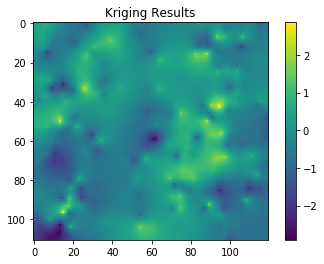

C:\Users\saryz\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


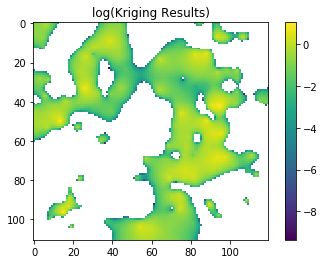

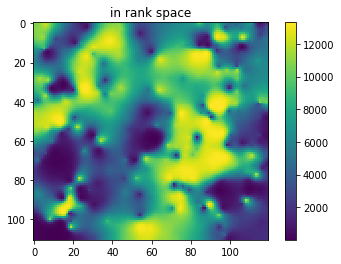

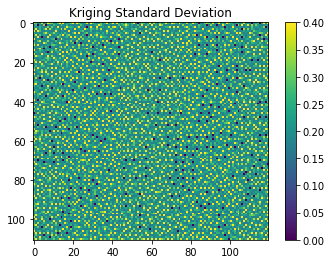

In [73]:
plt.title('SGS Results n_cond: ',n_cond, ' - seed: ',seed)
plt.imshow(interpolation_sgs,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('SGS_map_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()


plt.title('SGS Standard Deviation n_cond: ',n_cond, ' - seed: ',seed)
plt.imshow(std_sgs,
          origin='lower',
          vmin=0.0,
          vmax=0.4)
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('SGS_std_map_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()

In [76]:
#Back to original values of the data
sgs = np.zeros((interpolation_sgs.shape[0], interpolation_sgs.shape[1]))
for i in range(interpolation_sgs.shape[0]):
    for j in range(interpolation_sgs.shape[1]):
        inter_normal = sp.interpolate.interp1d(values_cdf_normal,cdf_normal)
        cdf_value = inter_normal(interpolation_sgs[i,j])
        inter = sp.interpolate.interp1d(cdf,values_cdf)
        sgs[i,j] = inter(cdf_value)

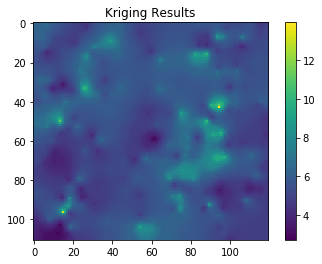

In [77]:
plt.title('SGS Results')
plt.imshow(sgs,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('Ordinary Kriging map.png', dpi=300) #save a nice .png of this map.
plt.show()